# Master Analysis Script

This script is the Master analysis script.
It needs the ID_List.csv, ScalingAnalysis_SequenceNames.ipynb and Growth_Rate_oscillation.ipynb in the same folder.

### Function:
1. Reads in ID_List.csv
2. In Folder 'Experiments' builds Folder for every ID on the List and Names it by the ID
3. Copys Scaling Analysis and Growth Rate Script in each of those folders and Changes the ID in the script
4. Runns the Scaling Analysis Script in each folder
5. Get the Results.csv from each folder and combines the Data

Copyright by Julius Nohr

In [11]:
#Import all needed funcitions
import csv
import datetime
import ipywidgets as widgets
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pathlib
import re
import seaborn as s
import shutil
import subprocess
import sys
from datetime import datetime
from IPython.display import clear_output, display
from pathlib import Path
from omero.gateway import BlitzGateway

In [12]:
# Paths to the files
analysis_folder = Path(".")  # Assumption: Script is run from the 'Analysis' folder
id_names_path = analysis_folder / "ID_all" / "ID_Names.csv"
gelaufen_path = analysis_folder / "ID_all" / "gelaufen.csv"
id_list_path = analysis_folder / "ID_all" / "ID_in_use.csv"

# ID

## ID Logger
Fetches all Omero_Id's from a project and writes them into ID_Names.csv (ID;Name) as a list in '/Analysis/ID_all'

In [ ]:
# OMERO resource to be analyzed
omero_type = "project"
project_id = []  # Change to the ID of the project
omero_id = project_id[0]

# your OMERO login credentials (replace ... with your password)
username = ""
password = ''

# prepare credentials
import logging
if not "OMERO_SERVER" in os.environ:
    logging.warning("No 'OMERO_SERVER' defined. Falling back to default OMERO_SERVER address 'omero'! This can lead to connection faults!")
if not "OMERO_WEB" in os.environ:
    logging.warning("No 'OMERO_WEB' defined. Links to view OMERO data in web viewer might not work!")

credentials = dict(
    serverUrl=os.environ.get('OMERO_SERVER', 'omero'),
    username=username,
    password=password,
    port=int(os.environ.get('OMERO_PORT', '4064'))
)

omero_cred = dict(
    host=credentials['serverUrl'],
    username=credentials['username'],
    passwd=credentials['password'],
    port=credentials['port'],
    secure=True
)

omero_web = os.environ.get("OMERO_WEB", "<Your OMERO_WEB address should be here>")

from omero.rtypes import rlong

dataset_ids = []
dataset_names = {}

with BlitzGateway(**omero_cred) as conn:
    if omero_type.lower() == "project":
        project = conn.getObject("Project", rlong(omero_id))
        if project:
            for dataset in project.listChildren():
                dataset_ids.append(dataset.getId())
                dataset_names[dataset.getId()] = Path(dataset.getName()).name  # Only the pure name without PosixPath
        else:
            print(f"Project with ID {omero_id} not found.")
    else:
        print(f"The omero_type '{omero_type}' is not supported for this operation. Please use 'project'.")


# Save the Dataset IDs and names in ID_Names.csv
id_names_path = Path("ID_all") / 'ID_Names.csv'  # Path relative to the script location
with open(id_names_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['ID', 'Name'])  # Write the header row
    for dataset_id, dataset_name in dataset_names.items():
        writer.writerow([dataset_id, dataset_name])

print(f"Dataset IDs and names have been saved to '{id_names_path}'.")


Dataset IDs and names have been saved to 'ID_all/ID_Names.csv'.


## ID Checker
Checks which IDs have already been run (Analysis/gelaufen.csv) and compares these with all available IDs in the project (Analysis/ID_all/ID_Names.csv). Then writes all IDs that have not yet been run to the ID_List (Analysis/ID_List.csv)

In [14]:
try:
    # Load ID_Names.csv
    id_names_df = pd.read_csv(id_names_path, delimiter=';')

    # Ensure an 'ID' column exists
    if 'ID' not in id_names_df.columns:
        raise ValueError(f"The file '{id_names_path}' does not contain a column named 'ID'.")

    id_names_ids = list(id_names_df['ID'])  # Load IDs from ID_Names.csv as a list
    print(f"Number of IDs in '{id_names_path}': {len(id_names_ids)}")

    # Load gelaufen.csv
    try:
        gelaufen_df = pd.read_csv(gelaufen_path, delimiter=';')
        # Ensure an 'ID' column exists
        if 'ID' not in gelaufen_df.columns:
            raise ValueError(f"The file '{gelaufen_path}' does not contain a column named 'ID'.")
        gelaufen_ids = list(gelaufen_df['ID'])  # Load IDs from gelaufen.csv as a list
        print(f"Number of IDs in '{gelaufen_path}': {len(gelaufen_ids)}")
    except FileNotFoundError:
        print(f"File '{gelaufen_path}' not found. Writing all IDs from '{id_names_path}' to '{id_list_path}'.")
        ids_to_write_df = pd.DataFrame({'OmeroID': id_names_ids})
        ids_to_write_df.to_csv(id_list_path, index=False, sep=';')
        print(f"All IDs from '{id_names_path}' have been written to '{id_list_path}' with the column 'OmeroID'.")
        exit()

    # Find the IDs that are in ID_Names but not in gelaufen
    ids_to_write = [id_name_id for id_name_id in id_names_ids if id_name_id not in gelaufen_ids]
    print(f"Number of IDs that are in '{id_names_path}' but not in '{gelaufen_path}': {len(ids_to_write)}")

    # Write the IDs to ID_List.csv
    ids_to_write_df = pd.DataFrame({'OmeroID': ids_to_write})
    ids_to_write_df.to_csv(id_list_path, index=False, sep=';')
    print(f"The IDs not found in '{gelaufen_path}' have been written to '{id_list_path}'.")

except FileNotFoundError as e:
    print(f"Error: File not found: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Number of IDs in 'ID_all/ID_Names.csv': 29
Number of IDs in 'ID_all/gelaufen.csv': 69
Number of IDs that are in 'ID_all/ID_Names.csv' but not in 'ID_all/gelaufen.csv': 0
The IDs not found in 'ID_all/gelaufen.csv' have been written to 'ID_all/ID_in_use.csv'.


## Reading ID_List.csv
Reads in the previously created ID_List.csv and prints out the IDs once for checking purposes

In [15]:
# Load the ID list
dateiname = "ID_in_use.csv"
id_liste = []
script1 = "ScalingAnalysis_SequenceNames.ipynb"
script2 = "Growth_Rate_oscillation.ipynb"
experiments_ordner = "Experiments"

try:
    with open(id_list_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        # Skip the first line (header)
        next(csv_reader)
        for row in csv_reader:
            if row:  # Ensure that the row is not empty
                id_wert = row[0].strip()
                id_liste.append(id_wert)
except FileNotFoundError:
    print(f"Error: The file '{id_list_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file '{id_list_path}': {e}")

if id_liste:
    print("Read IDs:", id_liste)
else:
    print("No IDs were found.")

No IDs were found.


# Scaling to all ID'S

This part performs the analysis for each ID in the list in turn by executing the scaling analysis script in each ID folder.
Therefore it creates folders for each given ID.

1. Creates the main folder if it does not exist
2. Create the folder for the ID in the "Experiments" folder
3. Copys the scripts 'ScalingAnalysis_SequenceNames.ipynb' and Growth_Rate_oscillation.ipynb into the ID folder
4. Execute the Scaling Analysis script and pass the omero_id as a variable
5. Saves Results from each ID

In [16]:
#timestamp Start Analysis
# UTC Time! (German time -2h)
now = datetime.now()
print(now)

2025-06-27 15:29:57.704441


In [ ]:
# Create the main folder "Experiments" if it does not exist
if not os.path.exists(experiments_ordner):
    os.makedirs(experiments_ordner)
    print(f"Main folder '{experiments_ordner}' created.")
else:
    print(f"Main folder '{experiments_ordner}' already exists.")

try:
    with open(id_list_path, 'r') as csvdatei:
        csv_reader = csv.reader(csvdatei)
        next(csv_reader)
        for zeile in csv_reader:
            if zeile:
                omero_id = zeile[0].strip()
                ordner_name = os.path.join(experiments_ordner, omero_id)

            # Create the folder for the ID in the "Experiments" folder
            if not os.path.exists(ordner_name):
                os.makedirs(ordner_name)
                print(f"Folder '{omero_id}' created in '{experiments_ordner}'.")
            else:
                print(f"Folder '{omero_id}' in '{experiments_ordner}' already exists.")

            # Copy the scripts into the ID folder
            for script in [script1, script2]:
                try:
                    shutil.copy(script, os.path.join(ordner_name, script))
                    print(f"'{script}' copied to '{ordner_name}'.")
                except FileNotFoundError:
                    print(f"Error: Script '{script}' not found.")
                except Exception as e:
                    print(f"Error copying '{script}': {e}")

            # Execute the Scaling Analysis script and pass the omero_id as a variable
            notebook_path = os.path.join(ordner_name, script1)
            try:
                subprocess.run([
                    "papermill",
                    notebook_path,
                    notebook_path,  # Overwrite the original notebook with the result
                    "-p", "omero_id", omero_id
                ], check=True)
                print(f"'{script1}' executed in '{ordner_name}', omero_id passed.")
            except FileNotFoundError:
                print(f"Error: Notebook '{script1}' not found in '{ordner_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error executing '{script1}' with papermill: {e}")
            except ImportError:
                print("Error: 'papermill' is not installed. Please install it with 'pip install papermill'.")

except FileNotFoundError:
    print(f"Error: The file '{id_list_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

print("Processing completed.")


# Result processing

### Name adjusting 
Adjusting the Names in ID_Names.csv

In [17]:
# Path to the ID names file
id_names_path = Path("./ID_all/ID_Names.csv")

try:
    # Load the ID names file with semicolon as the delimiter
    id_names_df = pd.read_csv(id_names_path, delimiter=';')

    # Check if the 'ID' and 'Name' columns exist
    if 'ID' in id_names_df.columns and 'Name' in id_names_df.columns:
        def adjust_name(row):
            name = row['Name']
            print(f"Original Name: '{name}'")
            if 'Synechocystis_clock_V_' in name:
                name = name.split('Synechocystis_clock_V_')[-1].lstrip('_').strip()
                print(f"After Synechocystis_clock_V_: '{name}'")
            elif 'Glykogen_Staining_' in name:
                name = name.split('Glykogen_Staining_')[-1].lstrip('_').strip()
                print(f"After Glykogen_Staining_: '{name}'")
            elif 'clock_screening' in name:
                print("  'clock_screening' found")
                # Reorder the conditions to check the most specific cases first
                if 'clock_screening_' in name and '_Set_' in name:
                    parts = name.split('_Set_')
                    if len(parts) > 1:
                        name = parts[-1][5:].lstrip('_').strip()
                        print(f"  After clock_screening_ and _Set_: '{name}'")
                elif 'clock_screening_' in name and '_Set ' in name:
                    parts = name.split('_Set ')
                    if len(parts) > 1:
                        name = parts[-1][5:].lstrip('_').strip()
                        print(f"  After clock_screening_ and _Set : '{name}'")
                elif '_clock_screening_' in name and '_C' in name:
                    parts = name.split('_C', 1)
                    if len(parts) > 1:
                        remaining_part = parts[-1].lstrip('_')
                        name = re.sub(r'^\d+_', '', remaining_part)
                        print(f"  After _clock_screening_ and _C: '{name}'")
                elif 'clock_screening_' in name and '_' in name: # Added condition to capture the case '2025.05.06_clock_screening_7_dkaiC3+kaiC3'
                    parts = name.split('clock_screening_')[-1].split('_', 1)
                    if len(parts) > 1:
                        name = parts[1]
                        print(f"  After clock_screening_ and _: '{name}'")
                elif 'clock_screening_' in name:
                    name = name.split('clock_screening_')[-1].lstrip('_').strip()
                    print(f"  After clock_screening_: '{name}'")
            elif '_+_' in name:
                name = name.split('_+_')[-1].strip()
                print(f"After _+_ : '{name}'")

            final_name = name.strip()
            if final_name.startswith('d'):
                final_name = 'Δ' + final_name[1:]

            print(f"Return Name: '{final_name}'")
            return final_name

        # Apply the function to adjust the names
        id_names_df['Name_adjusted'] = id_names_df.apply(adjust_name, axis=1)

        # Overwrite the original 'Name' column with the adjusted names
        id_names_df['Name'] = id_names_df['Name_adjusted']
        id_names_df.drop(columns=['Name_adjusted'], inplace=True)

        # Save the modified DataFrame back to the CSV file (optional)
        id_names_df.to_csv(id_names_path, index=False, sep=';')

        print(f"The names in the file '{id_names_path}' have been adjusted.")

    else:
        print(f"Error: Columns 'ID' and 'Name' not found in the file '{id_names_path}'. Please check the file structure.")

except FileNotFoundError:
    print(f"Error: File not found at '{id_names_path}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Original Name: '2024.11.29_Synechocystis_clock_V_WT'
After Synechocystis_clock_V_: 'WT'
Return Name: 'WT'
Original Name: '2024.11.29_Synechocystis_clock_V_dkaiA1B1C1-Km'
After Synechocystis_clock_V_: 'dkaiA1B1C1-Km'
Return Name: 'ΔkaiA1B1C1-Km'
Original Name: '2024.11.29_Synechocystis_clock_V_dsll1334'
After Synechocystis_clock_V_: 'dsll1334'
Return Name: 'Δsll1334'
Original Name: '2025.01.10_PBV_Glykogen_Staining_WT_BG11'
After Glykogen_Staining_: 'WT_BG11'
Return Name: 'WT_BG11'
Original Name: '2025.01.10_PBV_Glykogen_Staining_WT_BG11_PBV'
After Glykogen_Staining_: 'WT_BG11_PBV'
Return Name: 'WT_BG11_PBV'
Original Name: '2025.01.10_PBV_Glykogen_Staining_dkaiA1B1C1_BG11'
After Glykogen_Staining_: 'dkaiA1B1C1_BG11'
Return Name: 'ΔkaiA1B1C1_BG11'
Original Name: '2025.01.10_PBV_Glykogen_Staining_dkaiA1B1C1_BG11_PBV'
After Glykogen_Staining_: 'dkaiA1B1C1_BG11_PBV'
Return Name: 'ΔkaiA1B1C1_BG11_PBV'
Original Name: '2025.01.23_clock_screening_1_C1_dglgC'
  'clock_screening' found
  After _c

### Define results path
All results will be saved in 'Master_results' folder
 (./Analysis/Master_results)

In [18]:
#define Path 'Masther_results'
master_results_folder = "Master_results"
if not os.path.exists(master_results_folder):
    os.makedirs(master_results_folder)

## Getting the results
Results from each ID and each chamber are collected
Files are saved in Master_results

### Frequency_results_fourier.csv
Using Mean data with fouier transformation 

In [19]:
# Get mean_fourier_frequency_results.cs from each experiment and save as 'combined_frequency_results.csv'

data_folder = Path("./Experiments/")  # Search directly in the 'Experiments' folder below the current directory (Analysis)
dfs = []

for sub_folder in data_folder.glob("*"):  # Go through the folders (3580, 3708, etc.)
    if sub_folder.is_dir():
        data_file = sub_folder / "mean_fourier_frequency_results.csv"
        try:
            sub_df = pd.read_csv(data_file, delimiter=';')
            dfs.append(sub_df)
            print(f'mean_fourier_frequency_results.csv found in {sub_folder}')
        except FileNotFoundError:
            print(f'No mean_fourier_frequency_results.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {data_file}: {e}')

if dfs:
    joint_df = pd.concat(dfs, ignore_index=True)
    grouped_df = joint_df.groupby('Omero_ID')
    joint_df = joint_df.sort_values(by='Omero_ID')  # sort DataFrame for 'Omero_ID'
    master_results_path = Path(master_results_folder) / 'combined_frequency_results.csv'
    joint_df.to_csv(master_results_path, index=False, sep=';', decimal='.')
else:
    print("No 'mean_fourier_frequency_results.csv' files found.")
    
print('\nGrouped_df:')
print(joint_df)

mean_fourier_frequency_results.csv found in Experiments/4017
mean_fourier_frequency_results.csv found in Experiments/3948
mean_fourier_frequency_results.csv found in Experiments/3709
mean_fourier_frequency_results.csv found in Experiments/4160
mean_fourier_frequency_results.csv found in Experiments/4207
mean_fourier_frequency_results.csv found in Experiments/4123
mean_fourier_frequency_results.csv found in Experiments/4016
mean_fourier_frequency_results.csv found in Experiments/3910
mean_fourier_frequency_results.csv found in Experiments/3909
mean_fourier_frequency_results.csv found in Experiments/4208
mean_fourier_frequency_results.csv found in Experiments/4124
mean_fourier_frequency_results.csv found in Experiments/3946
No mean_fourier_frequency_results.csv found in Experiments/.ipynb_checkpoints
mean_fourier_frequency_results.csv found in Experiments/4028
mean_fourier_frequency_results.csv found in Experiments/4018
mean_fourier_frequency_results.csv found in Experiments/3707
mean_fo

In [20]:
# add names to 'combined_frequency_results.csv' and save as 'combined_frequency_results_with_names.csv'

# Define the path to the combined results file
combined_results_path = Path("./Master_results/combined_frequency_results.csv")
id_names_path = Path("ID_all") / 'ID_Names.csv' 

try:
    # Load the combined results file
    combined_df = pd.read_csv(combined_results_path, delimiter=';', decimal='.')

    # Load the ID names file with the correct delimiter (semicolon)
    id_names_df = pd.read_csv(id_names_path, delimiter=';')

    # Ensure that the ID and Name columns exist
    if 'Omero_ID' in combined_df.columns and 'ID' in id_names_df.columns and 'Name' in id_names_df.columns:
        # Merge the DataFrames based on 'Omero_ID' and 'ID'
        merged_df = pd.merge(combined_df, id_names_df, left_on='Omero_ID', right_on='ID', how='left')

        # Remove the redundant 'ID' column after the merge
        merged_df.drop(columns=['ID'], inplace=True)

        # Save the merged DataFrame to a new CSV file in the Master_results folder
        output_path = Path(master_results_folder) / 'combined_frequency_results_with_names.csv'
        merged_df.to_csv(output_path, index=False, sep=';', decimal='.')
        print(merged_df)

        print(
            f"Names from 'ID_Names.csv' were successfully added and saved as '{output_path}'.")

    else:
        print(
            f"Error: Ensure that 'combined_frequency_results.csv' has a column 'Omero_ID' (found: {combined_df.columns.tolist()}) and 'ID_Names.csv' has columns 'ID' (found: {id_names_df.columns.tolist()}) and 'Name' (found: {id_names_df.columns.tolist()}).")

except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



    Omero_ID  max_amplitude  frequency_1_h  1_frequency_h  phase_shift  \
0       3707      75.710600       0.021008      47.600000    23.600000   
1       3708     203.833398       0.037815      26.444444     2.444444   
2       3709      76.833622       0.038136      26.222222     2.222222   
3       3909     108.435490       0.042373      23.600000    -0.400000   
4       3910     145.269822       0.038136      26.222222     2.222222   
5       3911      81.602327       0.012712      78.666667    54.666667   
6       3912     248.947429       0.012712      78.666667    54.666667   
7       3945      26.508334       0.041420      24.142857     0.142857   
8       3946      70.454580       0.017751      56.333333    32.333333   
9       3947      56.456365       0.017751      56.333333    32.333333   
10      3948      57.595902       0.041420      24.142857     0.142857   
11      4015     123.076415       0.041420      24.142857     0.142857   
12      4016      51.856248       0.19

In [21]:
combined_results_with_names_path = Path(master_results_folder) / 'combined_frequency_results_with_names.csv'

try:
    df = pd.read_csv(combined_results_with_names_path, delimiter=';')
    print(f"The file '{combined_results_with_names_path}' was loaded successfully.")
    print(df.head())  # Show the first 5 rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{combined_results_with_names_path}' was not found. Please check if the file is located in the 'Master_results' folder.")
except Exception as e:
    print(f"An error occurred: {e}")

The file 'Master_results/combined_frequency_results_with_names.csv' was loaded successfully.
   Omero_ID  max_amplitude  frequency_1_h  1_frequency_h  phase_shift  \
0      3707      75.710600       0.021008      47.600000    23.600000   
1      3708     203.833398       0.037815      26.444444     2.444444   
2      3709      76.833622       0.038136      26.222222     2.222222   
3      3909     108.435490       0.042373      23.600000    -0.400000   
4      3910     145.269822       0.038136      26.222222     2.222222   

            Name  
0  ΔkaiA1B1C1-Km  
1       Δsll1334  
2             WT  
3        WT_BG11  
4    WT_BG11_PBV  


### Sig_Mean_std.csv

In [22]:
# List to store DataFrames from each file
all_data = []

for sub_folder in data_folder.glob("*"):  # Go through the folders (3580, 3708, etc.)
    if sub_folder.is_dir():
        data_file = sub_folder / "sig_mean_std.csv"
        try:
            sub_df = pd.read_csv(data_file, delimiter=';')
            if 'mean' in sub_df.columns and 'std' in sub_df.columns and 'time' in sub_df.columns and 'OmeroID' in sub_df.columns:
                all_data.append(sub_df)
            else:
                print(f'Error: Required columns (mean, std, time, OmeroID) not found in {data_file}')
        except FileNotFoundError:
            print(f'No sig_mean_std.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {data_file}: {e}')

# Combine all DataFrames into a single DataFrame
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    master_results_path = Path(master_results_folder) / 'combined_sig_mean_std.csv'
    combined_df.to_csv(master_results_path, index=False, sep=';', decimal='.')
    print(f"Combined data saved to: {master_results_path}")
else:
    print("No 'sig_mean_std.csv' files found to combine.")
    
print('\nCombined_df contains:')
print(combined_df)
    

No sig_mean_std.csv found in Experiments/.ipynb_checkpoints
Combined data saved to: Master_results/combined_sig_mean_std.csv

Combined_df contains:
      time      mean       std  OmeroID
0        0 -0.183625  3.267116     4017
1        1 -0.075533  4.238835     4017
2        2  0.182812  2.701347     4017
3        3 -1.837832  2.942673     4017
4        4 -4.168196  2.530727     4017
...    ...       ...       ...      ...
5364   164 -1.184000  2.185677     4027
5365   165 -0.706841  1.607728     4027
5366   166  0.736549  1.893087     4027
5367   167  0.310824  2.136367     4027
5368   168 -0.554816  2.506555     4027

[5369 rows x 4 columns]


In [23]:
import pandas as pd
from pathlib import Path

# Define the paths to the combined results file and the ID names file
combined_results_path = Path(master_results_folder) / 'combined_sig_mean_std.csv'
id_names_path = Path("ID_all") / 'ID_Names.csv'

try:
    # Load the combined results file
    combined_df = pd.read_csv(combined_results_path, delimiter=';', decimal='.')

    # Load the ID names file with the correct delimiter (semicolon)
    id_names_df = pd.read_csv(id_names_path, delimiter=';')

    # Ensure that the ID and Name columns exist
    if 'OmeroID' in combined_df.columns and 'ID' in id_names_df.columns and 'Name' in id_names_df.columns:
        # Merge the DataFrames based on 'OmeroID' and 'ID'
        merged_df = pd.merge(combined_df, id_names_df, left_on='OmeroID', right_on='ID', how='left')

        # Remove the redundant 'ID' column after the merge
        merged_df.drop(columns=['ID'], inplace=True)

        # Save the merged DataFrame to a new CSV file in the Master_results folder
        output_path = Path(master_results_folder) / 'combined_sig_mean_std_with_names.csv'
        merged_df.to_csv(output_path, index=False, sep=';', decimal='.')

        print(
            f"Names from 'ID_Names.csv' were successfully added to '{combined_results_path}' and saved as '{output_path}'.")

    else:
        print(
            f"Error: Ensure that '{combined_results_path}' has a column 'OmeroID' (found: {combined_df.columns.tolist()}) and 'ID_Names.csv' has columns 'ID' (found: {id_names_df.columns.tolist()}) and 'Name' (found: {id_names_df.columns.tolist()}).")

except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Names from 'ID_Names.csv' were successfully added to 'Master_results/combined_sig_mean_std.csv' and saved as 'Master_results/combined_sig_mean_std_with_names.csv'.


In [24]:
combined_sig_mean_std_with_names_path = Path(master_results_folder) / 'combined_sig_mean_std_with_names.csv'

try:
    df = pd.read_csv(combined_sig_mean_std_with_names_path, delimiter=';')
    print(f"The file '{combined_sig_mean_std_with_names_path}' was loaded successfully.")
    print(df.head())  # Show the first 5 rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_with_names_path}' was not found. Please check if the file is located in the 'Master_results' folder.")
except Exception as e:
    print(f"An error occurred: {e}")

The file 'Master_results/combined_sig_mean_std_with_names.csv' was loaded successfully.
   time      mean       std  OmeroID               Name
0     0 -0.183625  3.267116     4017  ΔkaiA3 + kaiA3-WT
1     1 -0.075533  4.238835     4017  ΔkaiA3 + kaiA3-WT
2     2  0.182812  2.701347     4017  ΔkaiA3 + kaiA3-WT
3     3 -1.837832  2.942673     4017  ΔkaiA3 + kaiA3-WT
4     4 -4.168196  2.530727     4017  ΔkaiA3 + kaiA3-WT


## Plotting

### Define Colors for each ID

In [25]:
# 1. Dictionary for marker and colors
# Marker assignment based on rules
marker_size = 5  # Change Marker Size her
mutant_markers = {
    "kai": {"marker": "v", "markersize": marker_size},  # Triangle
    "sll": {"marker": "s", "markersize": marker_size},  # Square
    "hik": {"marker": "s", "markersize": marker_size},  # Square
    "WT": {"marker": "o", "markersize": marker_size},  # Circle
}

# Colors for modifications (more expressive, without gray tones)
modification_colors = [
    "#1E90FF", "#FF8C00", "#228B22", "#DC143C", "#9932CC",
    "#8B4513", "#FF69B4", "#4682B4", "#F0E68C", "#ADFF2F",
    "#00FFFF", "#00BFFF", "#5F9EA0", "#2E8B57", "#D2691E",
    "#FF7F50", "#6495ED", "#800000", "#98FB98", "#F4A460",
    "#40E0D0", "#DA70D6", "#CD5C5C", "#D8BFD8", "#FFD700",
    "#663399", "#BA55D3", "#00008B", "#E6E6FA", "#7CFC00",
    "#B0E0E6", "#9370DB"
]
number_of_colors = len(modification_colors)
color_cycle = itertools.cycle(modification_colors)

# Global dictionary for storing color and marker assignments for IDs
id_marker_color_assignment = {}

def create_id_marker_color_dict(id_names_df):
    """
    Creates a dictionary that assigns markers and colors to IDs, based on a DataFrame.

    Args:
        id_names_df (pd.DataFrame): DataFrame with the columns 'ID' and 'Name'.
    """
    global id_marker_color_assignment
    for _, row in id_names_df.iterrows():
        omero_id = int(row['ID'])
        name = row['Name']
        if omero_id not in id_marker_color_assignment:
            
            if "kai" in name:
                marker, markersize = mutant_markers["kai"]["marker"], mutant_markers["kai"]["markersize"]
                color = next(color_cycle)
                id_marker_color_assignment[omero_id] = {"marker": marker, "color": color, "markersize": markersize}
            elif "sll" in name:
                marker, markersize = mutant_markers["sll"]["marker"], mutant_markers["sll"]["markersize"]
                color = next(color_cycle)
                id_marker_color_assignment[omero_id] = {"marker": marker, "color": color, "markersize": markersize}
            elif "hik" in name:
                marker, markersize = mutant_markers["hik"]["marker"], mutant_markers["hik"]["markersize"]
                color = next(color_cycle)
                id_marker_color_assignment[omero_id] = {"marker": marker, "color": color, "markersize": markersize}
            elif name == "WT" or 'WT' in name:
                marker, markersize = mutant_markers["WT"]["marker"], mutant_markers["WT"]["markersize"]
                color = next(color_cycle)
                id_marker_color_assignment[omero_id] = {"marker": marker, "color": color, "markersize": markersize}
            
            else:
                marker = 'x'
                markersize = marker_size
                color = next(color_cycle)
                id_marker_color_assignment[omero_id] = {"marker": marker, "color": color, "markersize": markersize}
                
    return id_marker_color_assignment

# Path to the ID names file
id_names_path = Path("./ID_all/ID_Names.csv")

try:
    # Load the ID names file
    id_names_df = pd.read_csv(id_names_path, delimiter=';')

    # Create the dictionary
    id_marker_color_assignment = create_id_marker_color_dict(id_names_df)
    print("Dictionary created:")
    print(id_marker_color_assignment)

except FileNotFoundError:
    print(f"Error: File not found at '{id_names_path}'.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Could not create the dictionary.")



Dictionary created:
{3709: {'marker': 'o', 'color': '#1E90FF', 'markersize': 5}, 3707: {'marker': 'v', 'color': '#FF8C00', 'markersize': 5}, 3708: {'marker': 's', 'color': '#228B22', 'markersize': 5}, 3909: {'marker': 'o', 'color': '#DC143C', 'markersize': 5}, 3910: {'marker': 'o', 'color': '#9932CC', 'markersize': 5}, 3911: {'marker': 'v', 'color': '#8B4513', 'markersize': 5}, 3912: {'marker': 'v', 'color': '#FF69B4', 'markersize': 5}, 3945: {'marker': 'x', 'color': '#4682B4', 'markersize': 5}, 3946: {'marker': 'v', 'color': '#F0E68C', 'markersize': 5}, 3947: {'marker': 'v', 'color': '#ADFF2F', 'markersize': 5}, 3948: {'marker': 'o', 'color': '#00FFFF', 'markersize': 5}, 4015: {'marker': 'o', 'color': '#00BFFF', 'markersize': 5}, 4016: {'marker': 'v', 'color': '#5F9EA0', 'markersize': 5}, 4017: {'marker': 'v', 'color': '#2E8B57', 'markersize': 5}, 4018: {'marker': 'v', 'color': '#D2691E', 'markersize': 5}, 4027: {'marker': 'o', 'color': '#FF7F50', 'markersize': 5}, 4028: {'marker': 'v

### Define Plotting Path
All Plots will be saved in 'Master_plots' folder (./Analysis/Master_plots)

In [26]:
# Define Path 'Master_plots'
master_plots_folder = "Master_plots" #füge diesen ordnerpfad hinzu
if not os.path.exists(master_plots_folder):
    os.makedirs(master_plots_folder)

In [27]:
# Define the path to the combined results file with names
combined_sig_mean_std_path = Path(master_results_folder) / 'combined_sig_mean_std_with_names.csv'

### Plots

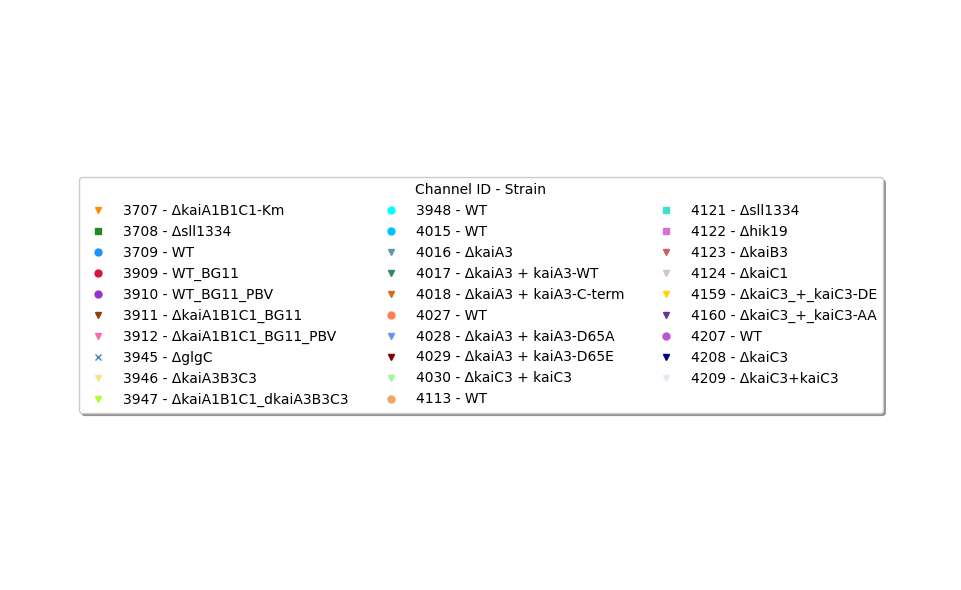

Legend saved to: Master_plots/Color and Forms Dictionary.png


In [28]:
#show Color and Forms Dictionary
try:
    # Load the combined results file with names (needed to extract names for the legend)
    df_merged = pd.read_csv(combined_results_with_names_path, delimiter=';', decimal='.')

    # Create a figure specifically for the legend
    fig_legend = plt.figure(figsize=(10, 6))
    ax_legend = fig_legend.add_subplot(111)

    # Create proxy artists for the legend
    handles = []
    labels = []
    seen_labels = set() # To avoid duplicate entries if IDs repeat in the assignment

    for index, row in df_merged.iterrows():
        omero_id = int(row['Omero_ID'])
        name = row['Name']
        if omero_id in id_marker_color_assignment:
            marker = id_marker_color_assignment[omero_id]['marker']
            color = id_marker_color_assignment[omero_id]['color']
            markersize = id_marker_color_assignment[omero_id]['markersize']
            legend_label = f"{omero_id} - {name}"
            if legend_label not in seen_labels:
                line = plt.Line2D([0], [0], marker=marker, color=color, linestyle='None',
                                markersize=markersize, label=legend_label)
                handles.append(line)
                labels.append(legend_label)
                seen_labels.add(legend_label)
        # We don't need the else case here as we only want to show entries that have a defined style

    # Create the legend
    legend = ax_legend.legend(handles=handles, labels=labels,
                               title="Channel ID - Strain", loc='center',
                               fancybox=True, shadow=True, ncol=3)

    # Remove the axes from the legend figure
    ax_legend.axis('off')

    # Adjust layout to fit the legend
    plt.tight_layout()

    # Save the legend as a separate image
    output_path_legend = Path(master_plots_folder) / 'Color and Forms Dictionary.png'
    output_path_legend.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path_legend, dpi=300, bbox_inches='tight') # 'tight' ensures no extra whitespace
    plt.show()
    plt.close(fig_legend) # Close the legend figure

    print(f"Legend saved to: {output_path_legend}")

except FileNotFoundError:
    print(f"Error: The file '{combined_results_with_names_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

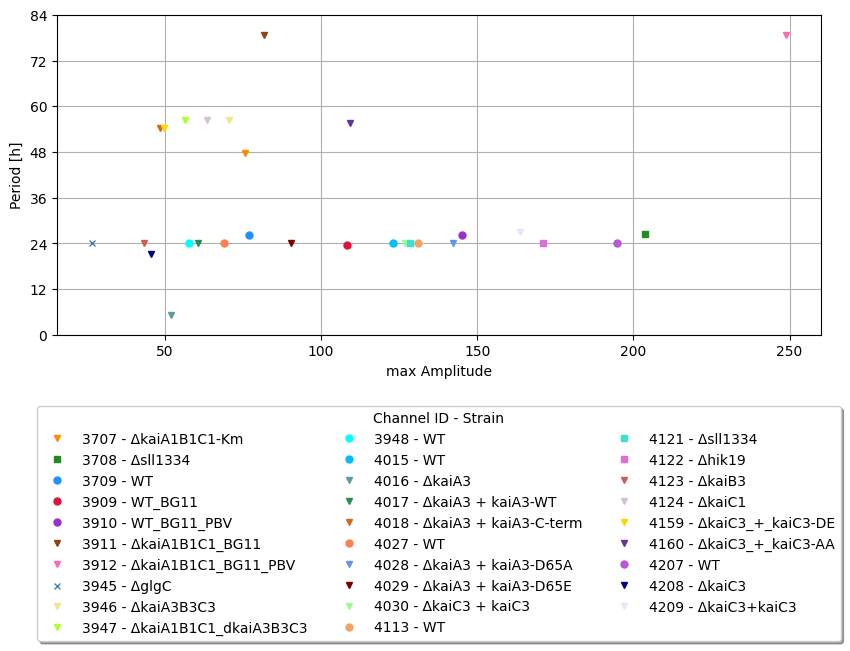

In [29]:
try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_results_with_names_path, delimiter=';', decimal='.')
    number_of_ids = df_merged.shape[0]

    plt.figure(figsize=(9, 7))  # Create a figure for the plot

    if number_of_ids > len(id_marker_color_assignment):
        print(
            f"Warning: More IDs ({number_of_ids}) are plotted than are in the color assignment dictionary ({len(id_marker_color_assignment)}). Colors might be repeated!")

    for index, row in df_merged.iterrows():
        omero_id = int(row['Omero_ID'])  # Convert Omero_ID to integer
        name = row['Name']
        if omero_id in id_marker_color_assignment:
            marker, color, markersize = id_marker_color_assignment[omero_id]['marker'], \
                                        id_marker_color_assignment[omero_id]['color'], \
                                        id_marker_color_assignment[omero_id]['markersize']
            legend_label = f"{omero_id} - {name}"
            # Plot max_amplitude vs. 1_frequency_h (Wavelength)
            plt.plot(row['max_amplitude'], row['1_frequency_h'], marker, color=color, label=legend_label,
                     markersize=markersize)  # Use marker and color from the dictionary
        else:
            print(f"Warning: Omero_ID {omero_id} not found in id_marker_color_assignment. Skipping this ID.")

    #plt.title('Wavelength vs. max. Amplitude per Experiment')
    plt.xlabel('max Amplitude')
    plt.ylabel('Period [h]')
    plt.legend(title="Channel ID - Strain", loc='upper center', bbox_to_anchor=(0.5, -0.2),
               fancybox=True, shadow=True, ncol=3)
    plt.grid(True)
    plt.tight_layout()

    # Calculate min_y and max_y based on the '1_frequency_h' column (Wavelength)
    min_y_data = df_merged['1_frequency_h'].min()
    max_y_data = df_merged['1_frequency_h'].max()

    # Set Y-axis limits from minimum number - 12 to maximum number + 12
    y_lim_min = 0 #min_y_data - 12
    y_lim_max = max_y_data
    plt.ylim(y_lim_min, y_lim_max)

    # Set Y-axis ticks in 12h steps, starting from a multiple of 12 below y_lim_min
    # and ending at a multiple of 12 above y_lim_max.
    # Use np.floor and np.ceil to ensure ticks align to multiples of 12.
    tick_start = np.floor(y_lim_min / 12) * 12
    tick_end = np.ceil(y_lim_max / 12) * 12
    plt.yticks(np.arange(tick_start, tick_end + 1, 12))


    # Speichere den Plot im Ordner "Master_plots"
    output_path = Path(master_plots_folder) / 'Period_vs_max_amplitude_with_names.png'
    output_path.parent.mkdir(parents=True, exist_ok=True) # Ensure the directory exists
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_results_with_names_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

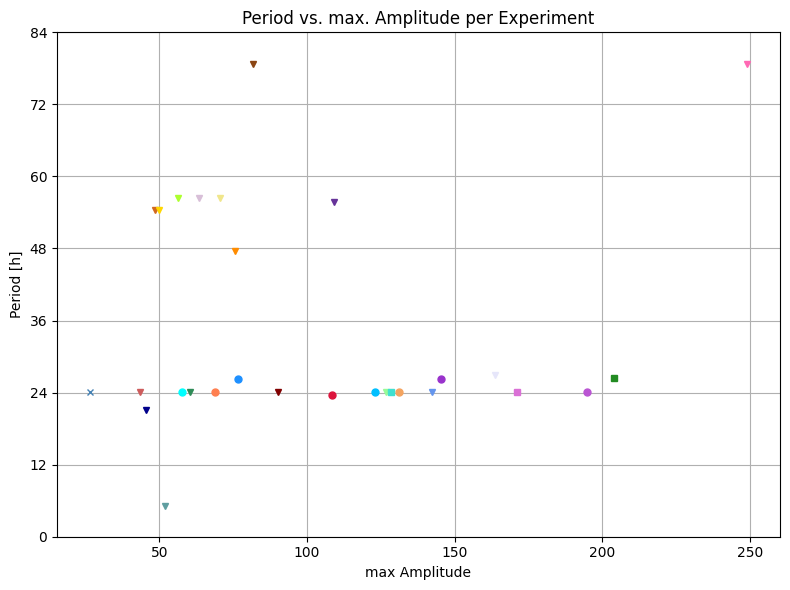

In [30]:
try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_results_with_names_path, delimiter=';', decimal='.')
    number_of_ids = df_merged.shape[0]

    plt.figure(figsize=(8, 6))  # Create a figure for the plot

    if number_of_ids > len(id_marker_color_assignment):
        print(
            f"Warning: More IDs ({number_of_ids}) are plotted than are in the color assignment dictionary ({len(id_marker_color_assignment)}). Colors might be repeated!")

    for index, row in df_merged.iterrows():
        omero_id = int(row['Omero_ID'])  # Convert Omero_ID to integer
        name = row['Name']
        if omero_id in id_marker_color_assignment:
            marker, color, markersize = id_marker_color_assignment[omero_id]['marker'], \
                                        id_marker_color_assignment[omero_id]['color'], \
                                        id_marker_color_assignment[omero_id]['markersize']
            legend_label = f"{omero_id} - {name}"
            # Plot max_amplitude vs. 1_frequency_h (Wavelength)
            plt.plot(row['max_amplitude'], row['1_frequency_h'], marker, color=color, label=legend_label,
                     markersize=markersize)  # Use marker and color from the dictionary
        else:
            print(f"Warning: Omero_ID {omero_id} not found in id_marker_color_assignment. Skipping this ID.")

    plt.title('Period vs. max. Amplitude per Experiment') # Corrected typo: Wavelengt -> Wavelength
    plt.xlabel('max Amplitude')
    plt.ylabel('Period [h]')
    plt.grid(True)
    plt.tight_layout()

    # Calculate min_y and max_y based on the '1_frequency_h' column (Wavelength)
    min_y_data = df_merged['1_frequency_h'].min()
    max_y_data = df_merged['1_frequency_h'].max()

    # Set Y-axis limits from minimum number - 12 to maximum number + 12
    y_lim_min = 0 #min_y_data - 12
    y_lim_max = max_y_data
    plt.ylim(y_lim_min, y_lim_max)

    # Set Y-axis ticks in 12h steps, starting from a multiple of 12 below y_lim_min
    # and ending at a multiple of 12 above y_lim_max.
    # Use np.floor and np.ceil to ensure ticks align to multiples of 12.
    tick_start = np.floor(y_lim_min / 12) * 12
    tick_end = np.ceil(y_lim_max / 12) * 12
    plt.yticks(np.arange(tick_start, tick_end + 1, 12))


    # Speichere den Plot im Ordner "Master_plots"
    output_path = Path(master_plots_folder) / 'Wavelength_vs_max_amplitude_no_legend.png'
    output_path.parent.mkdir(parents=True, exist_ok=True) # Ensure the directory exists
    plt.savefig(output_path, dpi=300)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_results_with_names_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

### Plotting Value over Time

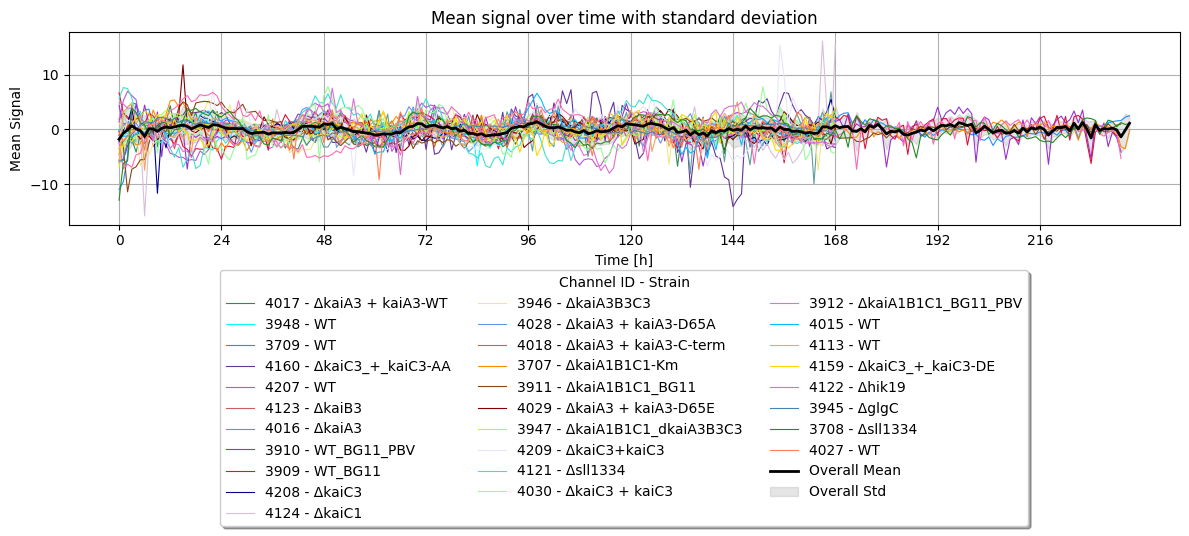

In [31]:

# Define line width variables
line_width = 0.8
mean_line_width = 2.0

try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_sig_mean_std_path, delimiter=';', decimal='.')
    

    # Get all unique Omero_IDs
    omero_ids = df_merged['OmeroID'].unique()
    number_of_ids = len(omero_ids)


    plt.figure(figsize=(12, 6))  # Create a figure for the plot

    if number_of_ids > len(id_marker_color_assignment):
        print(
            f"Warning: More IDs ({number_of_ids}) are plotted than are in the color assignment dictionary ({len(id_marker_color_assignment)}). Colors might be repeated!")

    # Plot mean for each Omero_ID
    for omero_id in omero_ids:
        df_id = df_merged[df_merged['OmeroID'] == omero_id]
        name = df_id['Name'].iloc[0]  # Get the name for the legend

        if omero_id in id_marker_color_assignment:
            color = id_marker_color_assignment[omero_id]['color']
            legend_label = f"{omero_id} - {name}"
            plt.plot(df_id['time'], df_id['mean'], label=legend_label, color=color, linewidth=line_width)
        else:
            plt.plot(df_id['time'], df_id['mean'], label=f"{omero_id} - {name}", linewidth=line_width) #plot without specific color if ID is not in dict
            print(f"Warning: Omero_ID {omero_id} not found in id_marker_color_assignment. Skipping custom color for this ID.")

    # Calculate and plot the overall mean and standard deviation
    overall_mean = df_merged.groupby('time')['mean'].mean()
    overall_std = df_merged.groupby('time')['mean'].std()

    plt.plot(overall_mean.index, overall_mean.values, color='black', linewidth=mean_line_width, label='Overall Mean')  # Plot the overall mean with specified line width
    plt.fill_between(overall_mean.index, overall_mean - overall_std, overall_mean + overall_std, color='gray', alpha=0.2, label='Overall Std')  # Plot the overall standard deviation as a shaded area


    plt.title('Mean signal over time with standard deviation')
    plt.xlabel('Time [h]')
    plt.ylabel('Mean Signal')
    plt.legend(title="Channel ID - Strain", loc='upper center', bbox_to_anchor=(0.5, -0.2),
               fancybox=True, shadow=True, ncol=3)
    plt.grid(True)
    plt.tight_layout()

    # Set x-axis ticks to show every 24 steps
    max_time = df_merged['time'].max()
    plt.xticks(np.arange(0, max_time + 1, 24))

    # Save the plot
    output_path = Path(master_plots_folder) / 'mean_over_time_with_std.png'
    output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    plt.savefig(output_path, dpi=300)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#### Plotting Time stripped [25:175]
As seen above, there are anomalies due to starting issues in the first 25 hours. Also not all experiments ave data beyond 175 hours. Therefore we strip those data and only plot data between 25h and 175h.
This elimniates errors

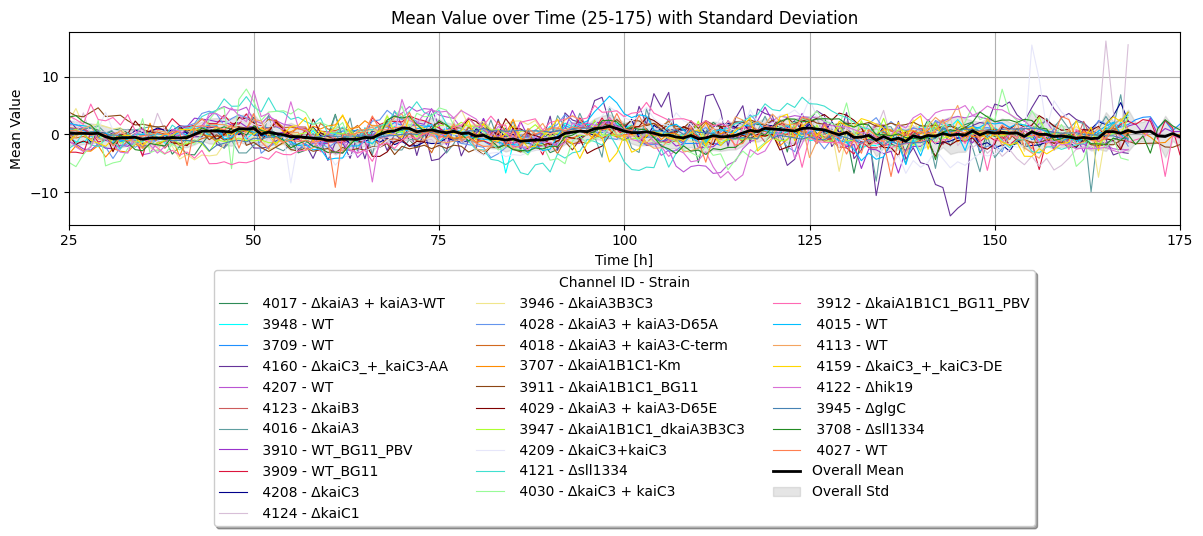

In [32]:
# Define line width variables
line_width = 0.8
mean_line_width = 2.0

# Define the time range for plotting
start_time = 25
end_time = 175

try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_sig_mean_std_path, delimiter=';', decimal='.')

    # Filter the DataFrame for the desired time range
    df_filtered = df_merged[(df_merged['time'] >= start_time) & (df_merged['time'] <= end_time)]

    # Get all unique Omero_IDs from the filtered data
    omero_ids = df_filtered['OmeroID'].unique()
    number_of_ids = len(omero_ids)

    plt.figure(figsize=(12, 6))  # Create a figure for the plot

    if number_of_ids > len(id_marker_color_assignment):
        print(
            f"Warning: More IDs ({number_of_ids}) are plotted than are in the color assignment dictionary ({len(id_marker_color_assignment)}). Colors might be repeated!")

    # Plot mean for each Omero_ID
    for omero_id in omero_ids:
        df_id = df_filtered[df_filtered['OmeroID'] == omero_id]
        name = df_id['Name'].iloc[0]  # Get the name for the legend

        if not df_id.empty:  # Ensure there is data for the current Omero ID in the time range
            if omero_id in id_marker_color_assignment:
                color = id_marker_color_assignment[omero_id]['color']
                legend_label = f" {omero_id} - {name}"
                plt.plot(df_id['time'], df_id['mean'], label=legend_label, color=color, linewidth=line_width)
            else:
                plt.plot(df_id['time'], df_id['mean'], label=f"{omero_id} - {name}", linewidth=line_width) #plot without specific color if ID is not in dict
                print(f"Warning: Omero_ID {omero_id} not found in id_marker_color_assignment. Skipping custom color for this ID.")
        else:
            print(f"Warning: No data found for Omero ID {omero_id} within the time range {start_time} to {end_time}.")

    # Calculate and plot the overall mean and standard deviation for the filtered data
    overall_mean = df_filtered.groupby('time')['mean'].mean()
    overall_std = df_filtered.groupby('time')['mean'].std()

    plt.plot(overall_mean.index, overall_mean.values, color='black', linewidth=mean_line_width, label='Overall Mean')  # Plot the overall mean with specified line width
    plt.fill_between(overall_mean.index, overall_mean - overall_std, overall_mean + overall_std, color='gray', alpha=0.2, label='Overall Std')  # Plot the overall standard deviation as a shaded area

    plt.title(f'Mean Value over Time ({start_time}-{end_time}) with Standard Deviation')
    plt.xlabel('Time [h]')
    plt.ylabel('Mean Value')
    plt.legend(title="Channel ID - Strain", loc='upper center', bbox_to_anchor=(0.5, -0.2),
               fancybox=True, shadow=True, ncol=3)
    plt.grid(True)
    plt.tight_layout()

    # Set x-axis ticks to show every 25 steps within the new range
    plt.xticks(np.arange(start_time, end_time + 1, 25))
    plt.xlim(start_time, end_time) # Set the x-axis limits explicitly

    # Save the plot with the new name
    old_output_name = 'mean_over_time_with_std.png'
    output_path = Path(master_plots_folder) / f'{Path(old_output_name).stem}_time_stripped{Path(old_output_name).suffix}'
    output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    plt.savefig(output_path, dpi=300)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

### subplots oscilation

#### Value over time

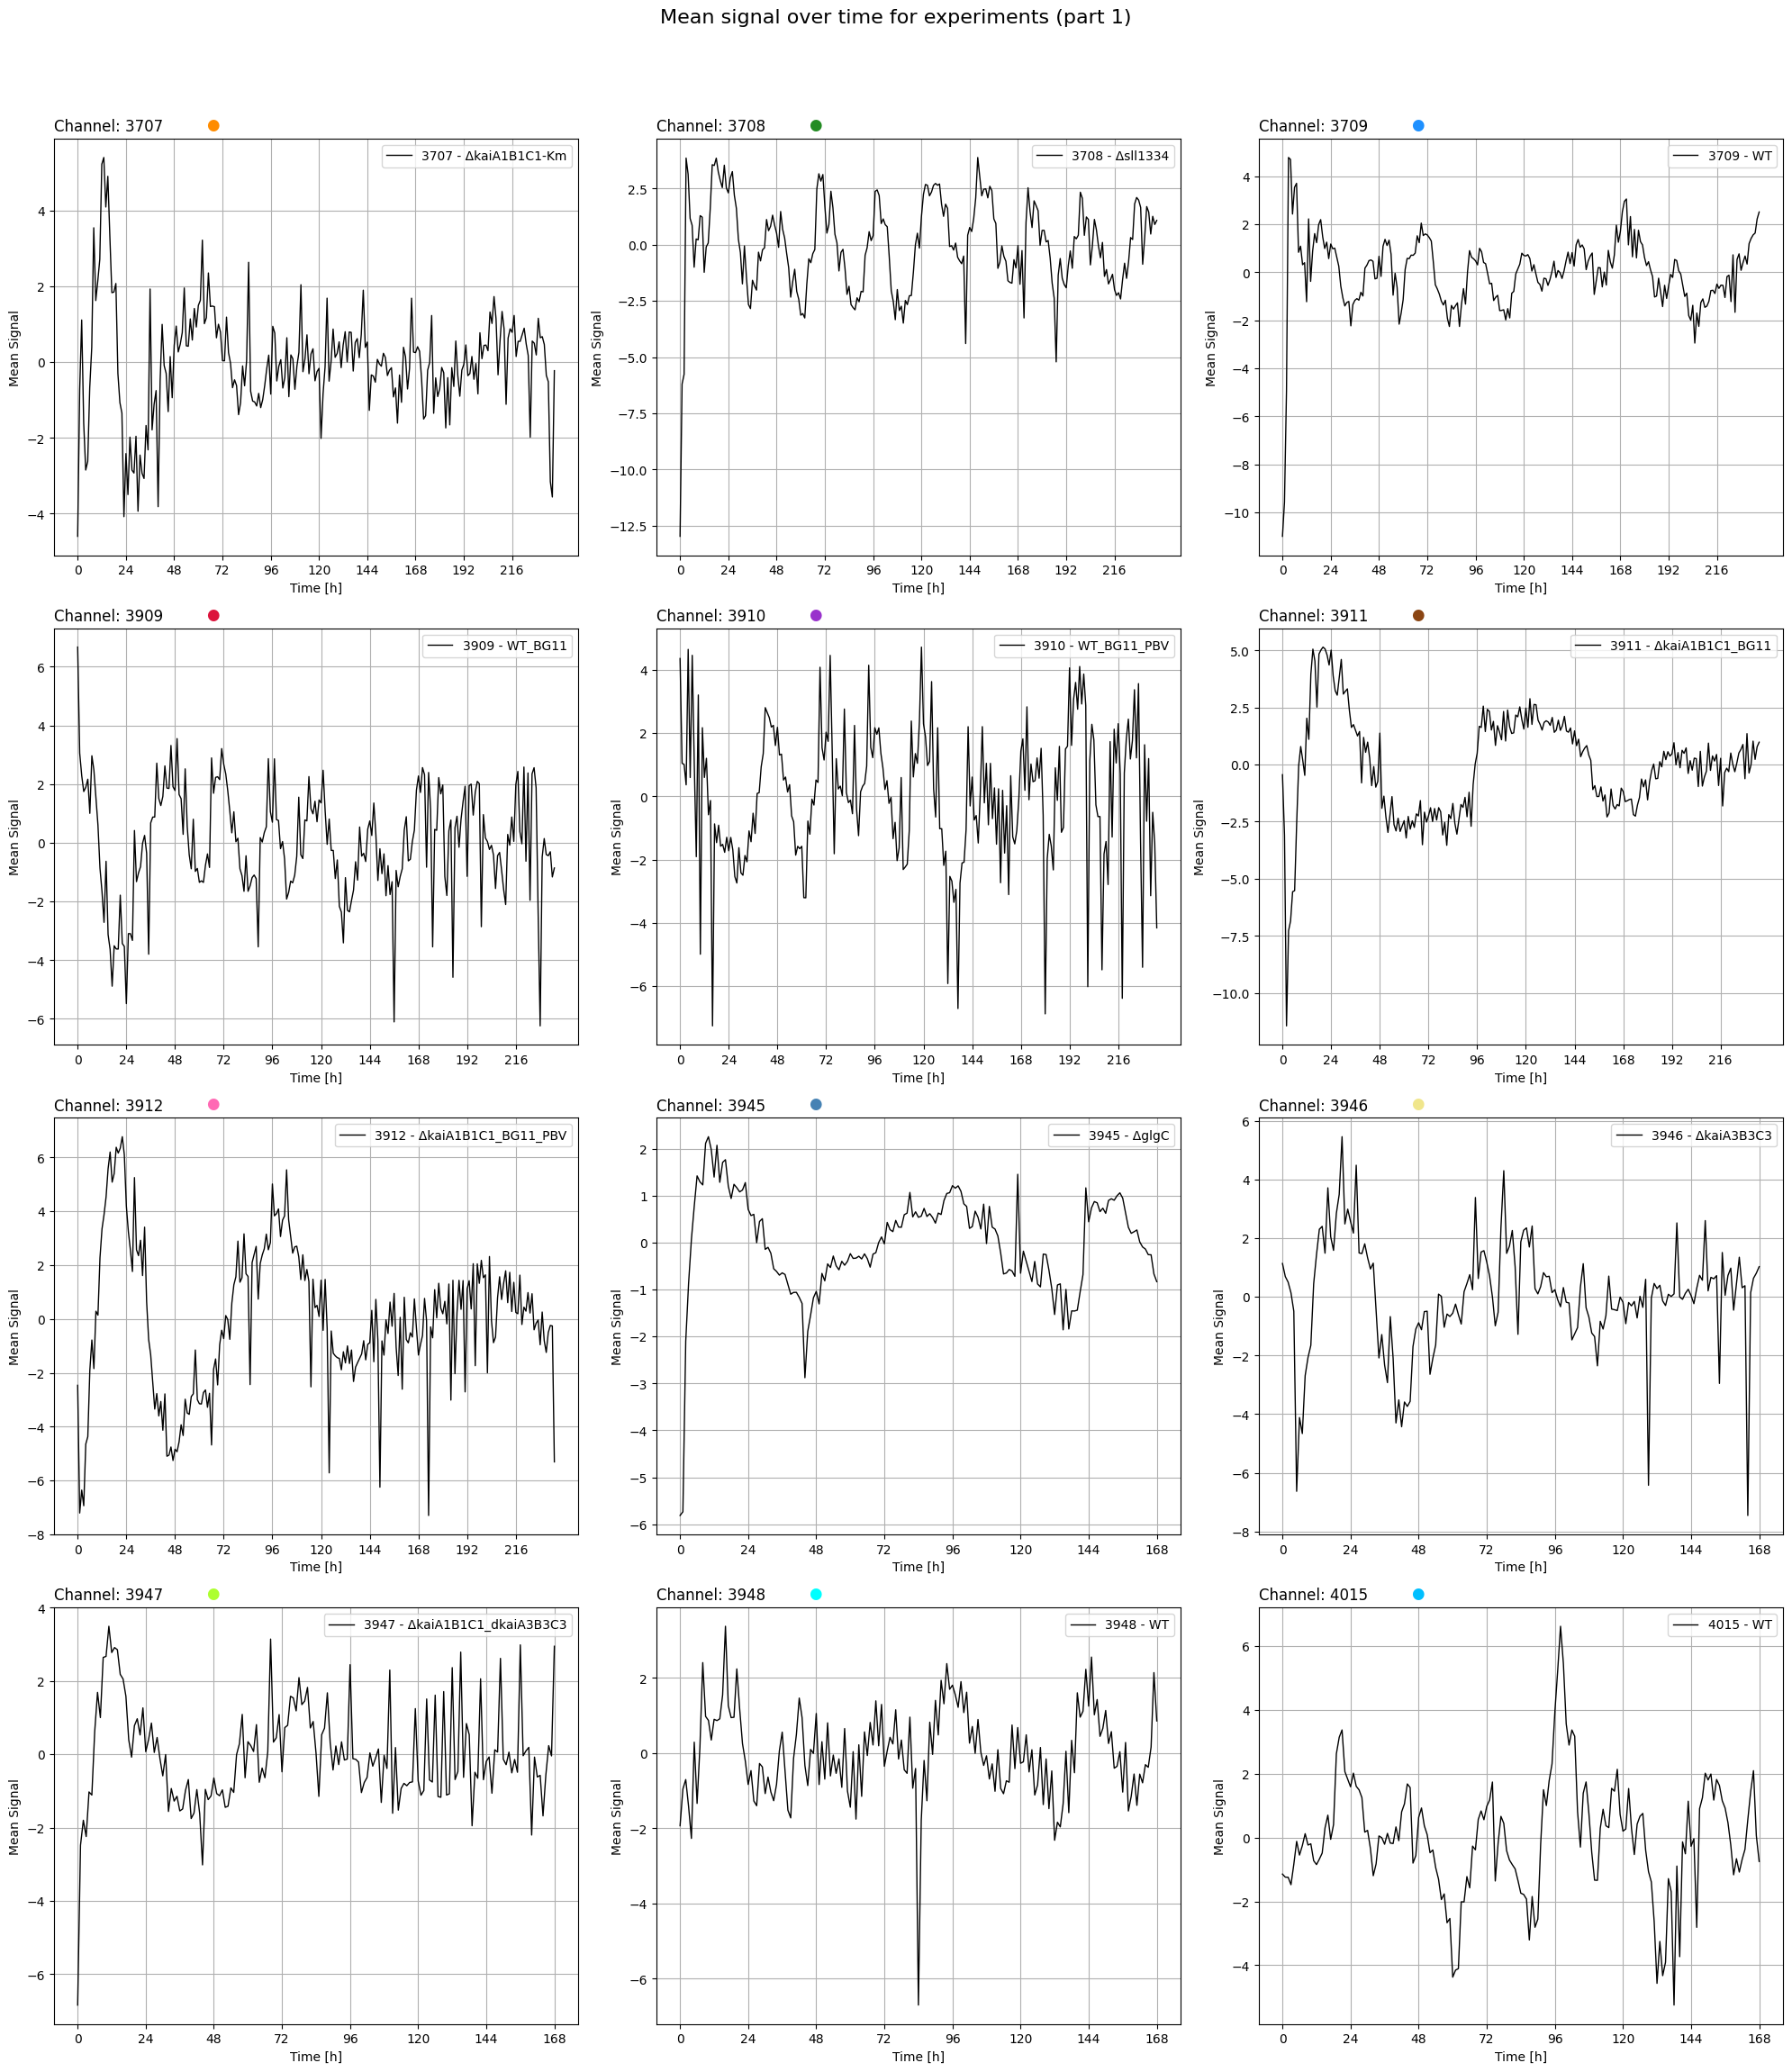

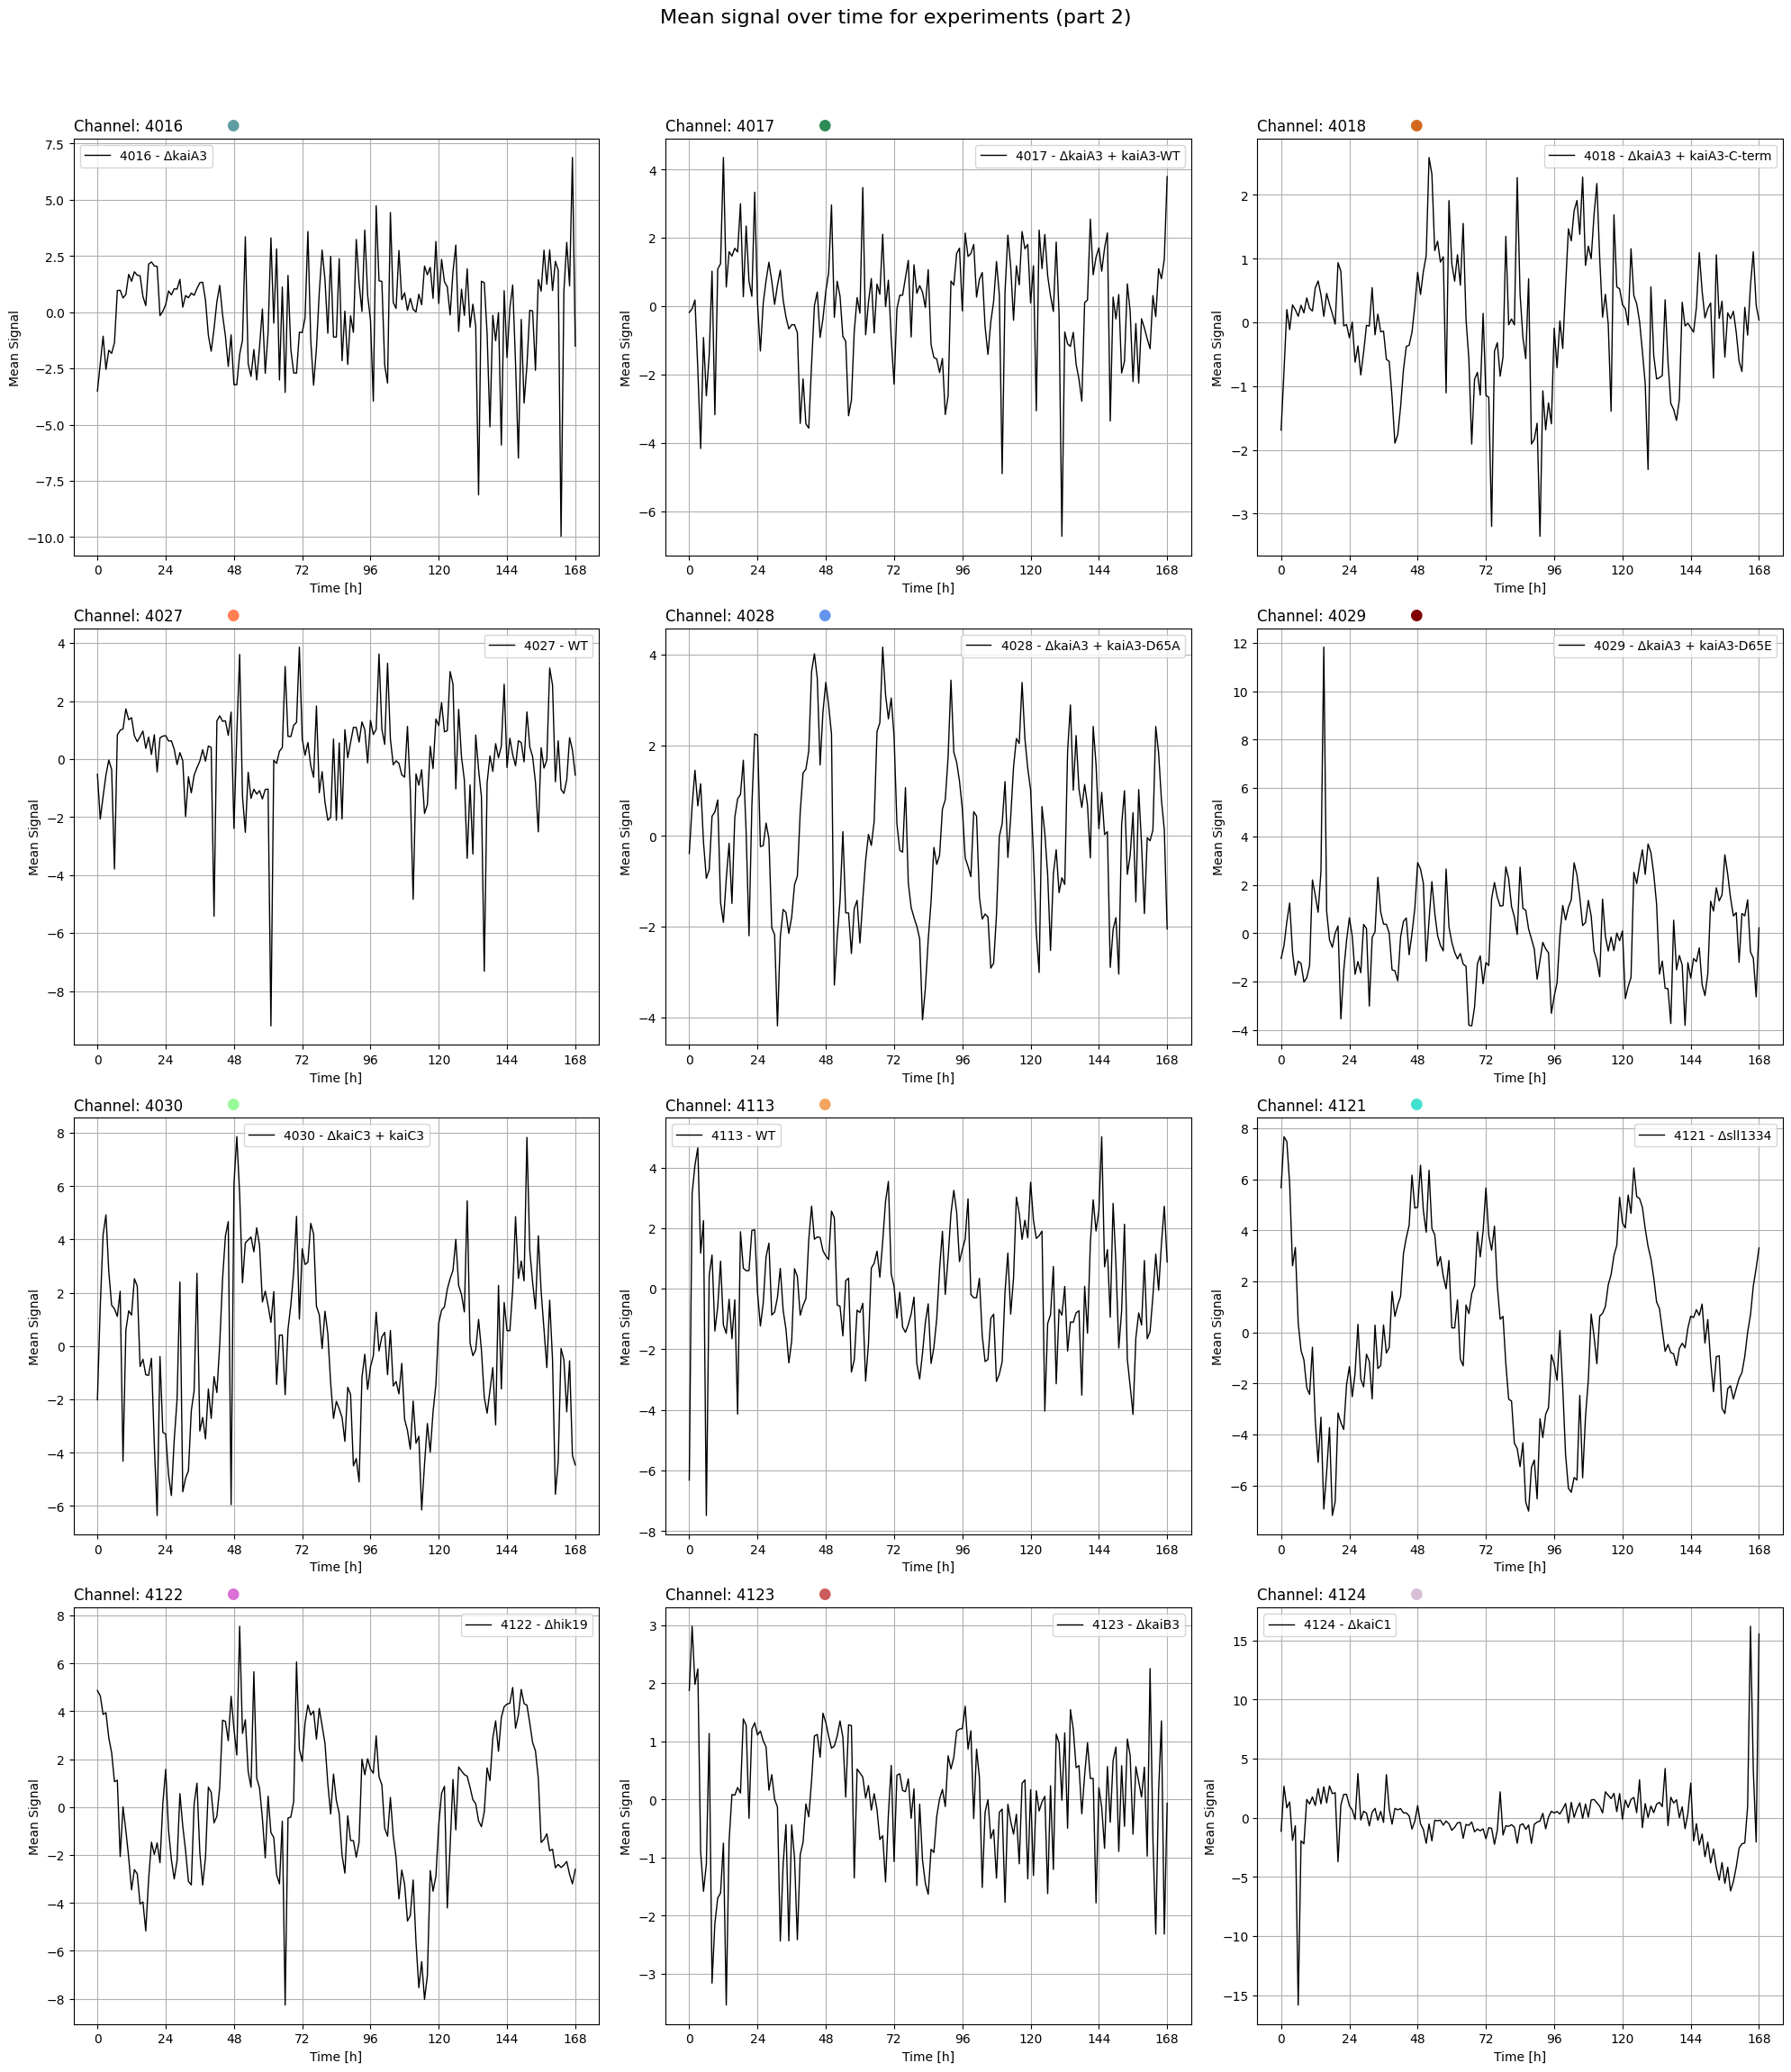

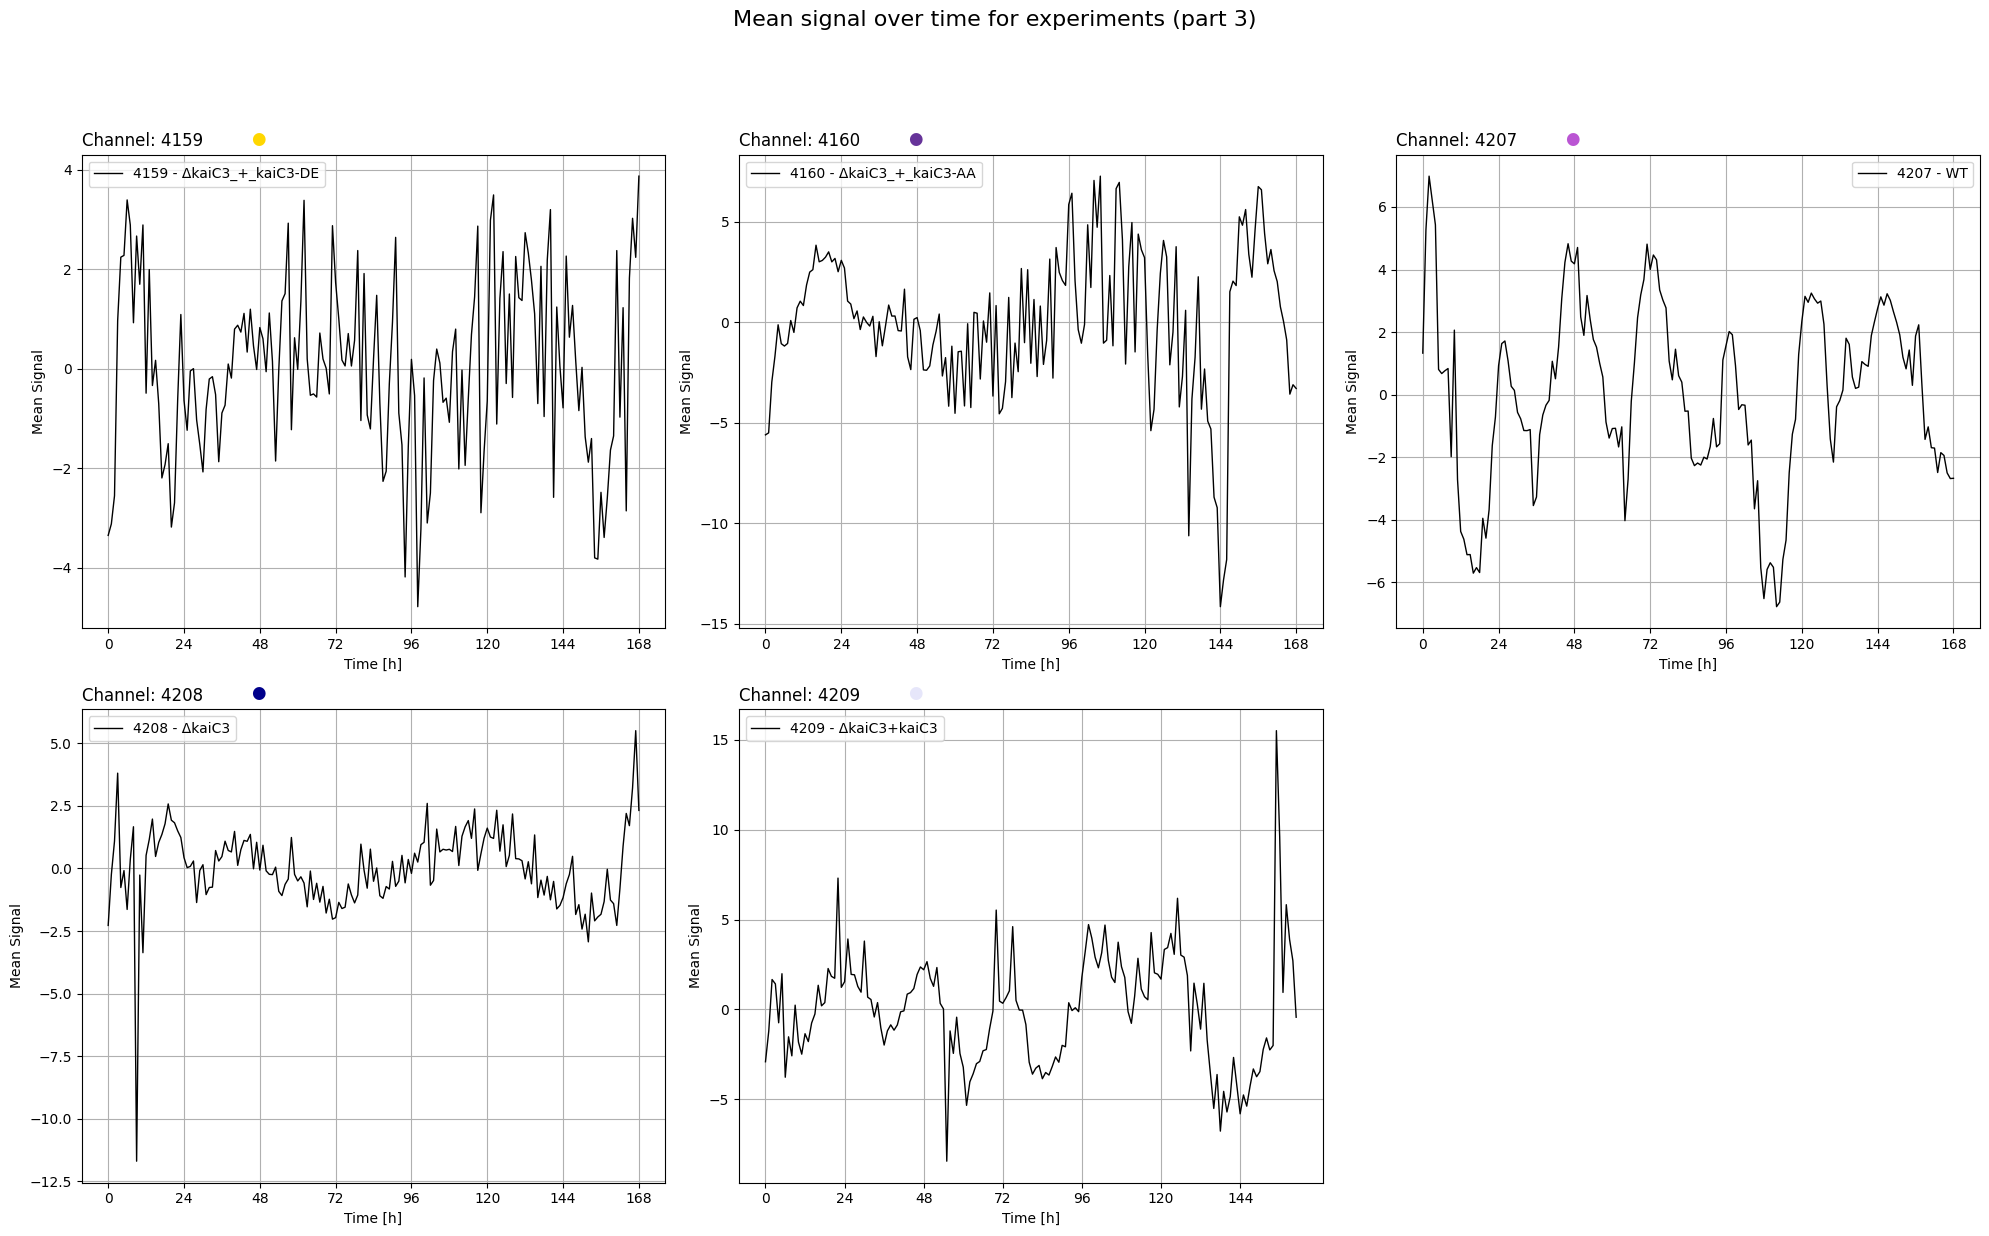

In [33]:
# subplots oscilation all IDs
try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_sig_mean_std_path, delimiter=';', decimal='.')

    # Get all unique Omero_IDs (experiments)
    omero_ids = sorted(df_merged['OmeroID'].unique())  # Sort the Omero_IDs
    number_of_ids = len(omero_ids)

    # Determine the number of rows and columns for the subplots
    n_cols = 3  # colom numbers
    n_rows_per_plot = 4  # max rows
    n_plots = (number_of_ids + n_rows_per_plot * n_cols - 1) // (
                n_rows_per_plot * n_cols)  # number of plots

    # Iterate over the two halves of the experiments
    for plot_index in range(n_plots):
        start_index = plot_index * n_rows_per_plot * n_cols
        end_index = min((plot_index + 1) * n_rows_per_plot * n_cols, number_of_ids)
        plot_omerids = omero_ids[start_index:end_index]

        # Create the subplots
        fig, axes = plt.subplots(n_rows_per_plot, n_cols,
                                 figsize=(20, 6 * n_rows_per_plot))  # Adjust figsize
        fig.suptitle(
            f'Mean signal over time for experiments (part {plot_index + 1})',
            fontsize=16)

        # Iterate over each Omero_ID in the current half
        for i, omero_id in enumerate(plot_omerids):
            df_id = df_merged[df_merged['OmeroID'] == omero_id]
            name = df_id['Name'].iloc[0]  # Get the name for the legend

            # Determine the subplot position
            row = i // n_cols
            col = i % n_cols
            if n_rows_per_plot > 1:
                ax = axes[row, col]
            elif n_cols > 1:
                ax = axes[col]
            else:
                ax = axes

            # Plot the mean for the current Omero_ID
            color = 'black'
            if omero_id in id_marker_color_assignment:
                experiment_color = id_marker_color_assignment[omero_id]['color']
            else:
                experiment_color = 'gray'  # Default color

            ax.plot(df_id['time'], df_id['mean'], label=f"{omero_id} - {name}", color=color,
                    linewidth=1.0)  # Increased linewidth
            ax.set_title(f'Channel: {omero_id}', loc='left')  # Set the title of the subplot,

            # Add a colored dot to the title, next to the experiment number
            ax.text(0.29, 1.034, '●', transform=ax.transAxes, color=experiment_color,
                    fontsize=12, va='center', ha='left')  # Adjusted position

            ax.set_xlabel('Time [h]')
            ax.set_ylabel('Mean Signal')
            ax.grid(True)
            ax.set_xticks(np.arange(0, df_id['time'].max() + 1, 24))
            ax.legend()

        # Delete any unused subplots
        if end_index < plot_index * n_rows_per_plot * n_cols + n_rows_per_plot * n_cols:
            for j in range(end_index - plot_index * n_rows_per_plot * n_cols,
                           n_rows_per_plot * n_cols):
                row = j // n_cols
                col = j % n_cols
                if n_rows_per_plot > 1:
                    ax = axes[row, col]
                elif n_cols > 1:
                    ax = axes[col]
                else:
                    ax = axes
                ax.remove()

        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout(rect=[0, 0.023, 1, 0.95])
        # Save the plot
        output_path = Path(
            'Master_plots') / f'mean_signal_over_time_subplt_part_{plot_index + 1}.png'
        output_path.parent.mkdir(parents=True, exist_ok=True)
        #plt.savefig(output_path, dpi=300)
        #plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_path}' was not found.")
    
except Exception as e:
    print(f"An error occurred: {e}")

#### Value over time + std

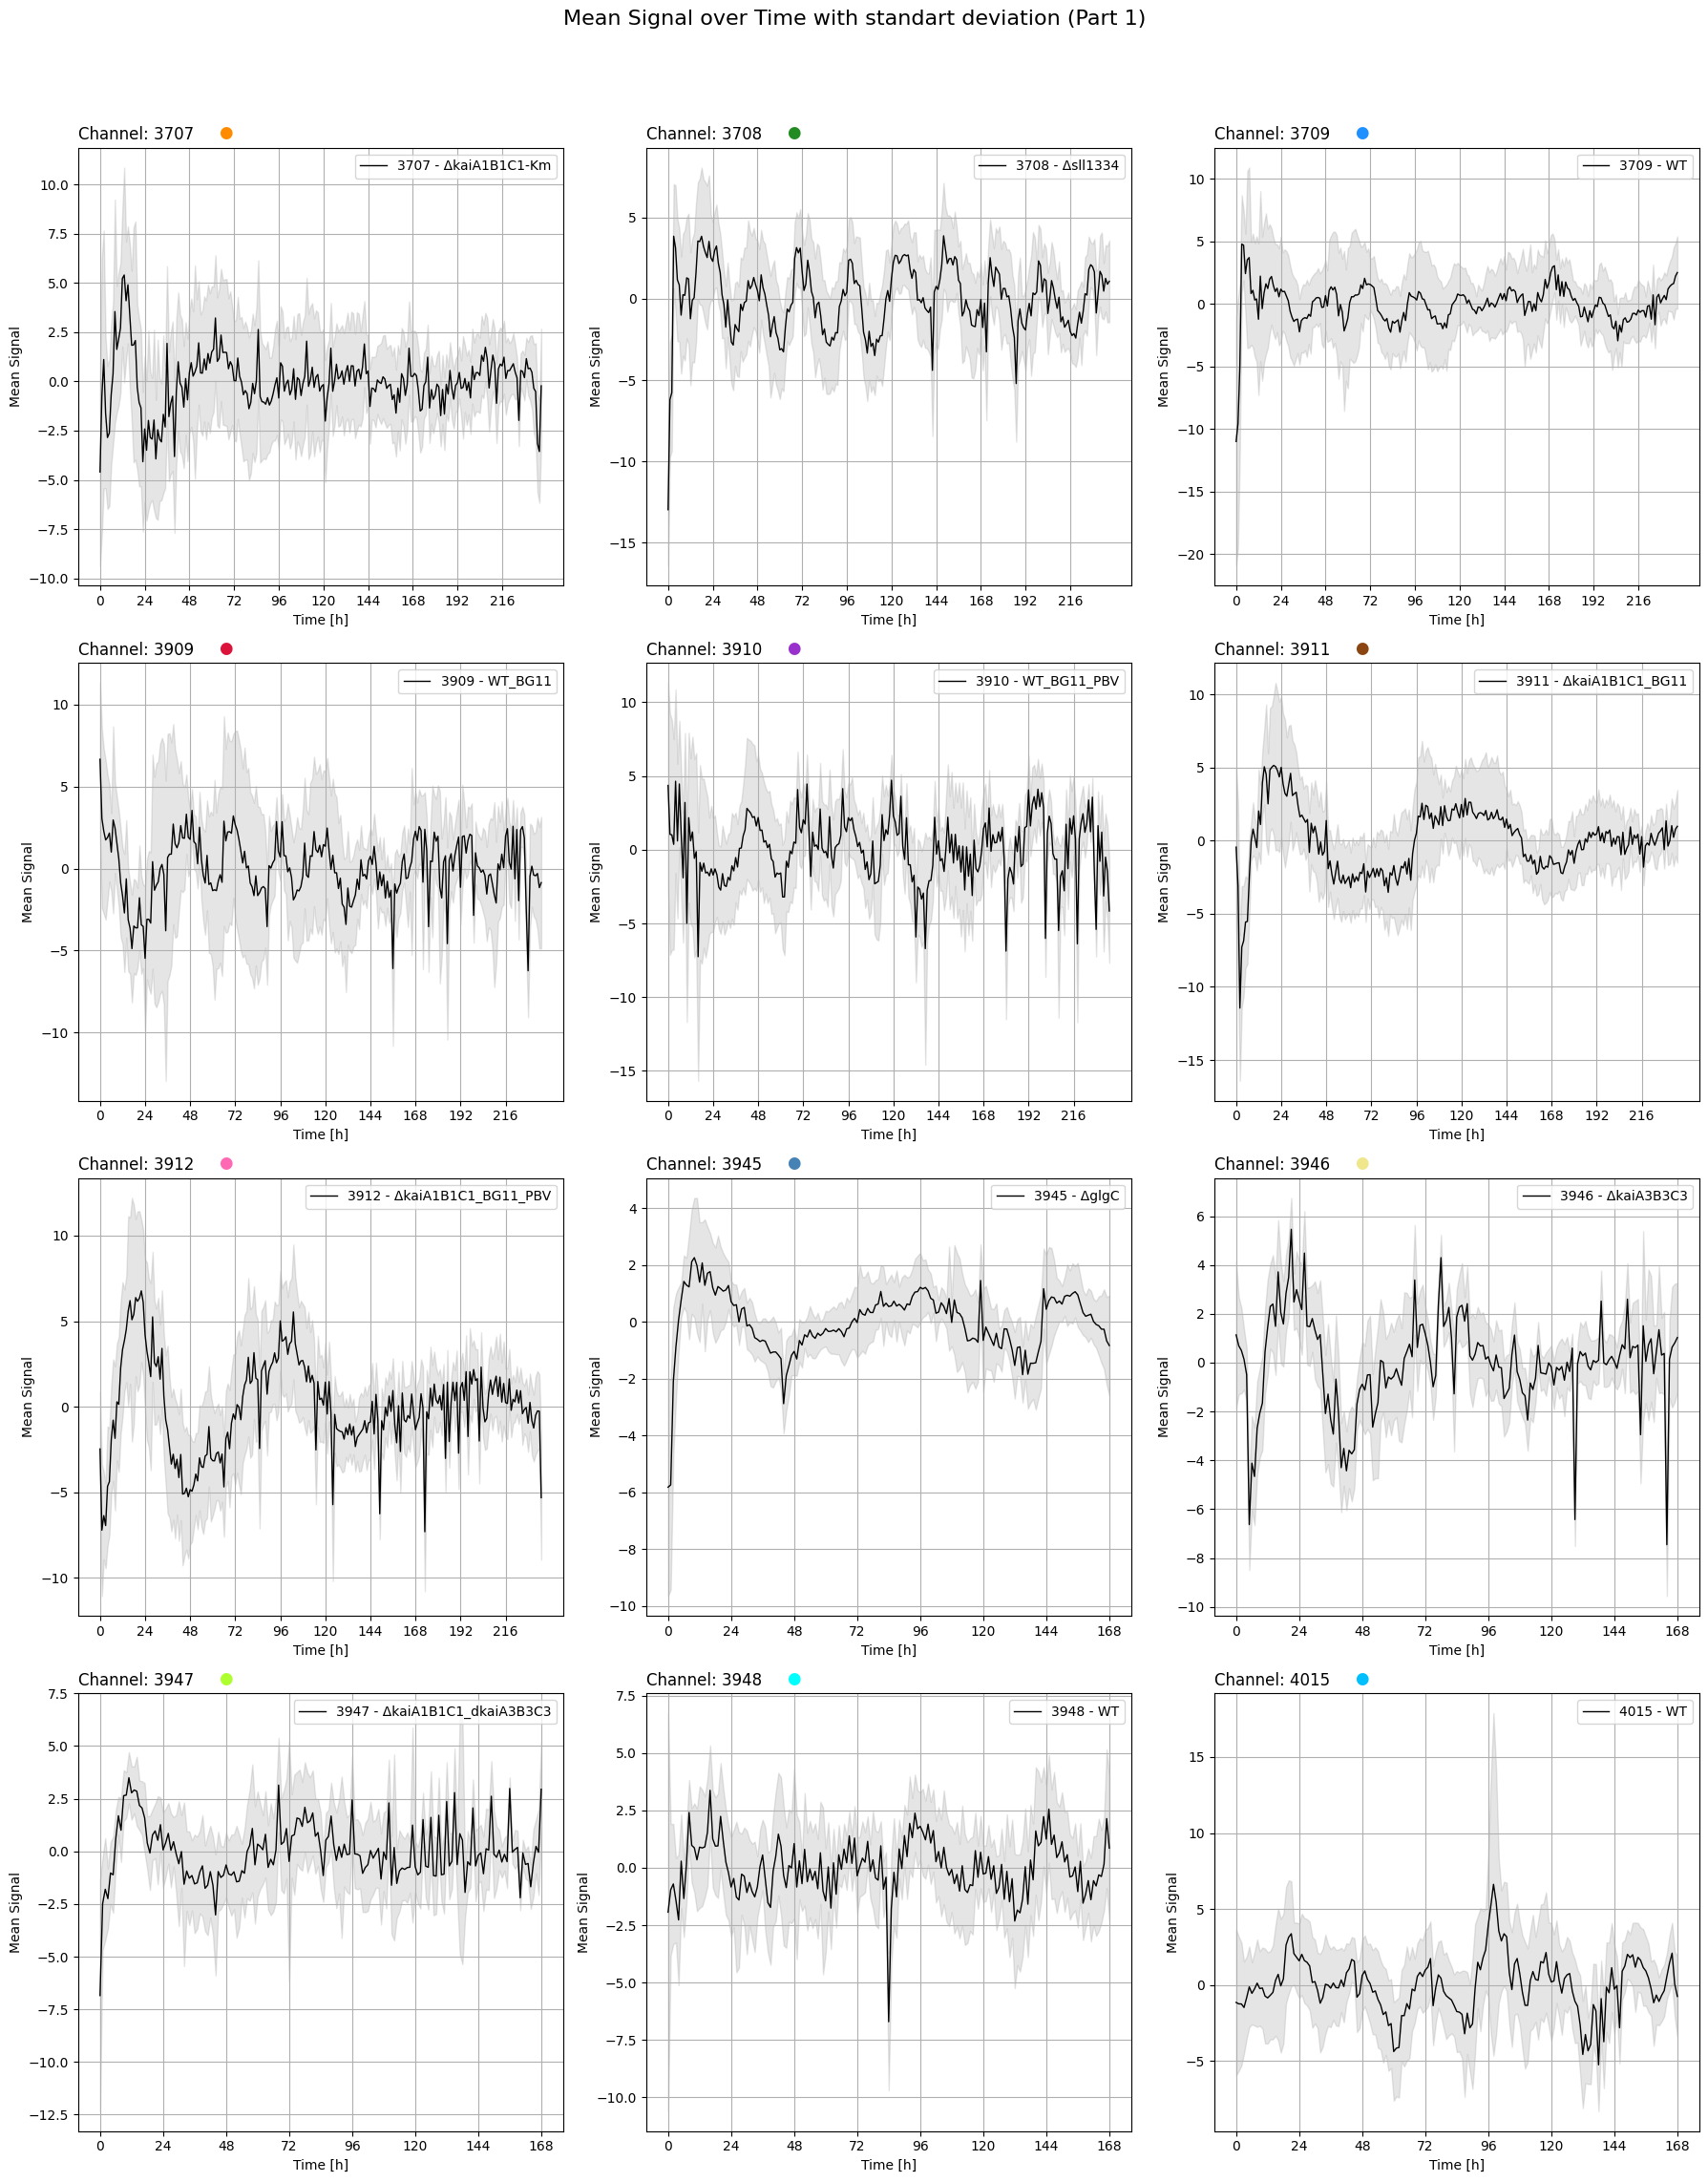

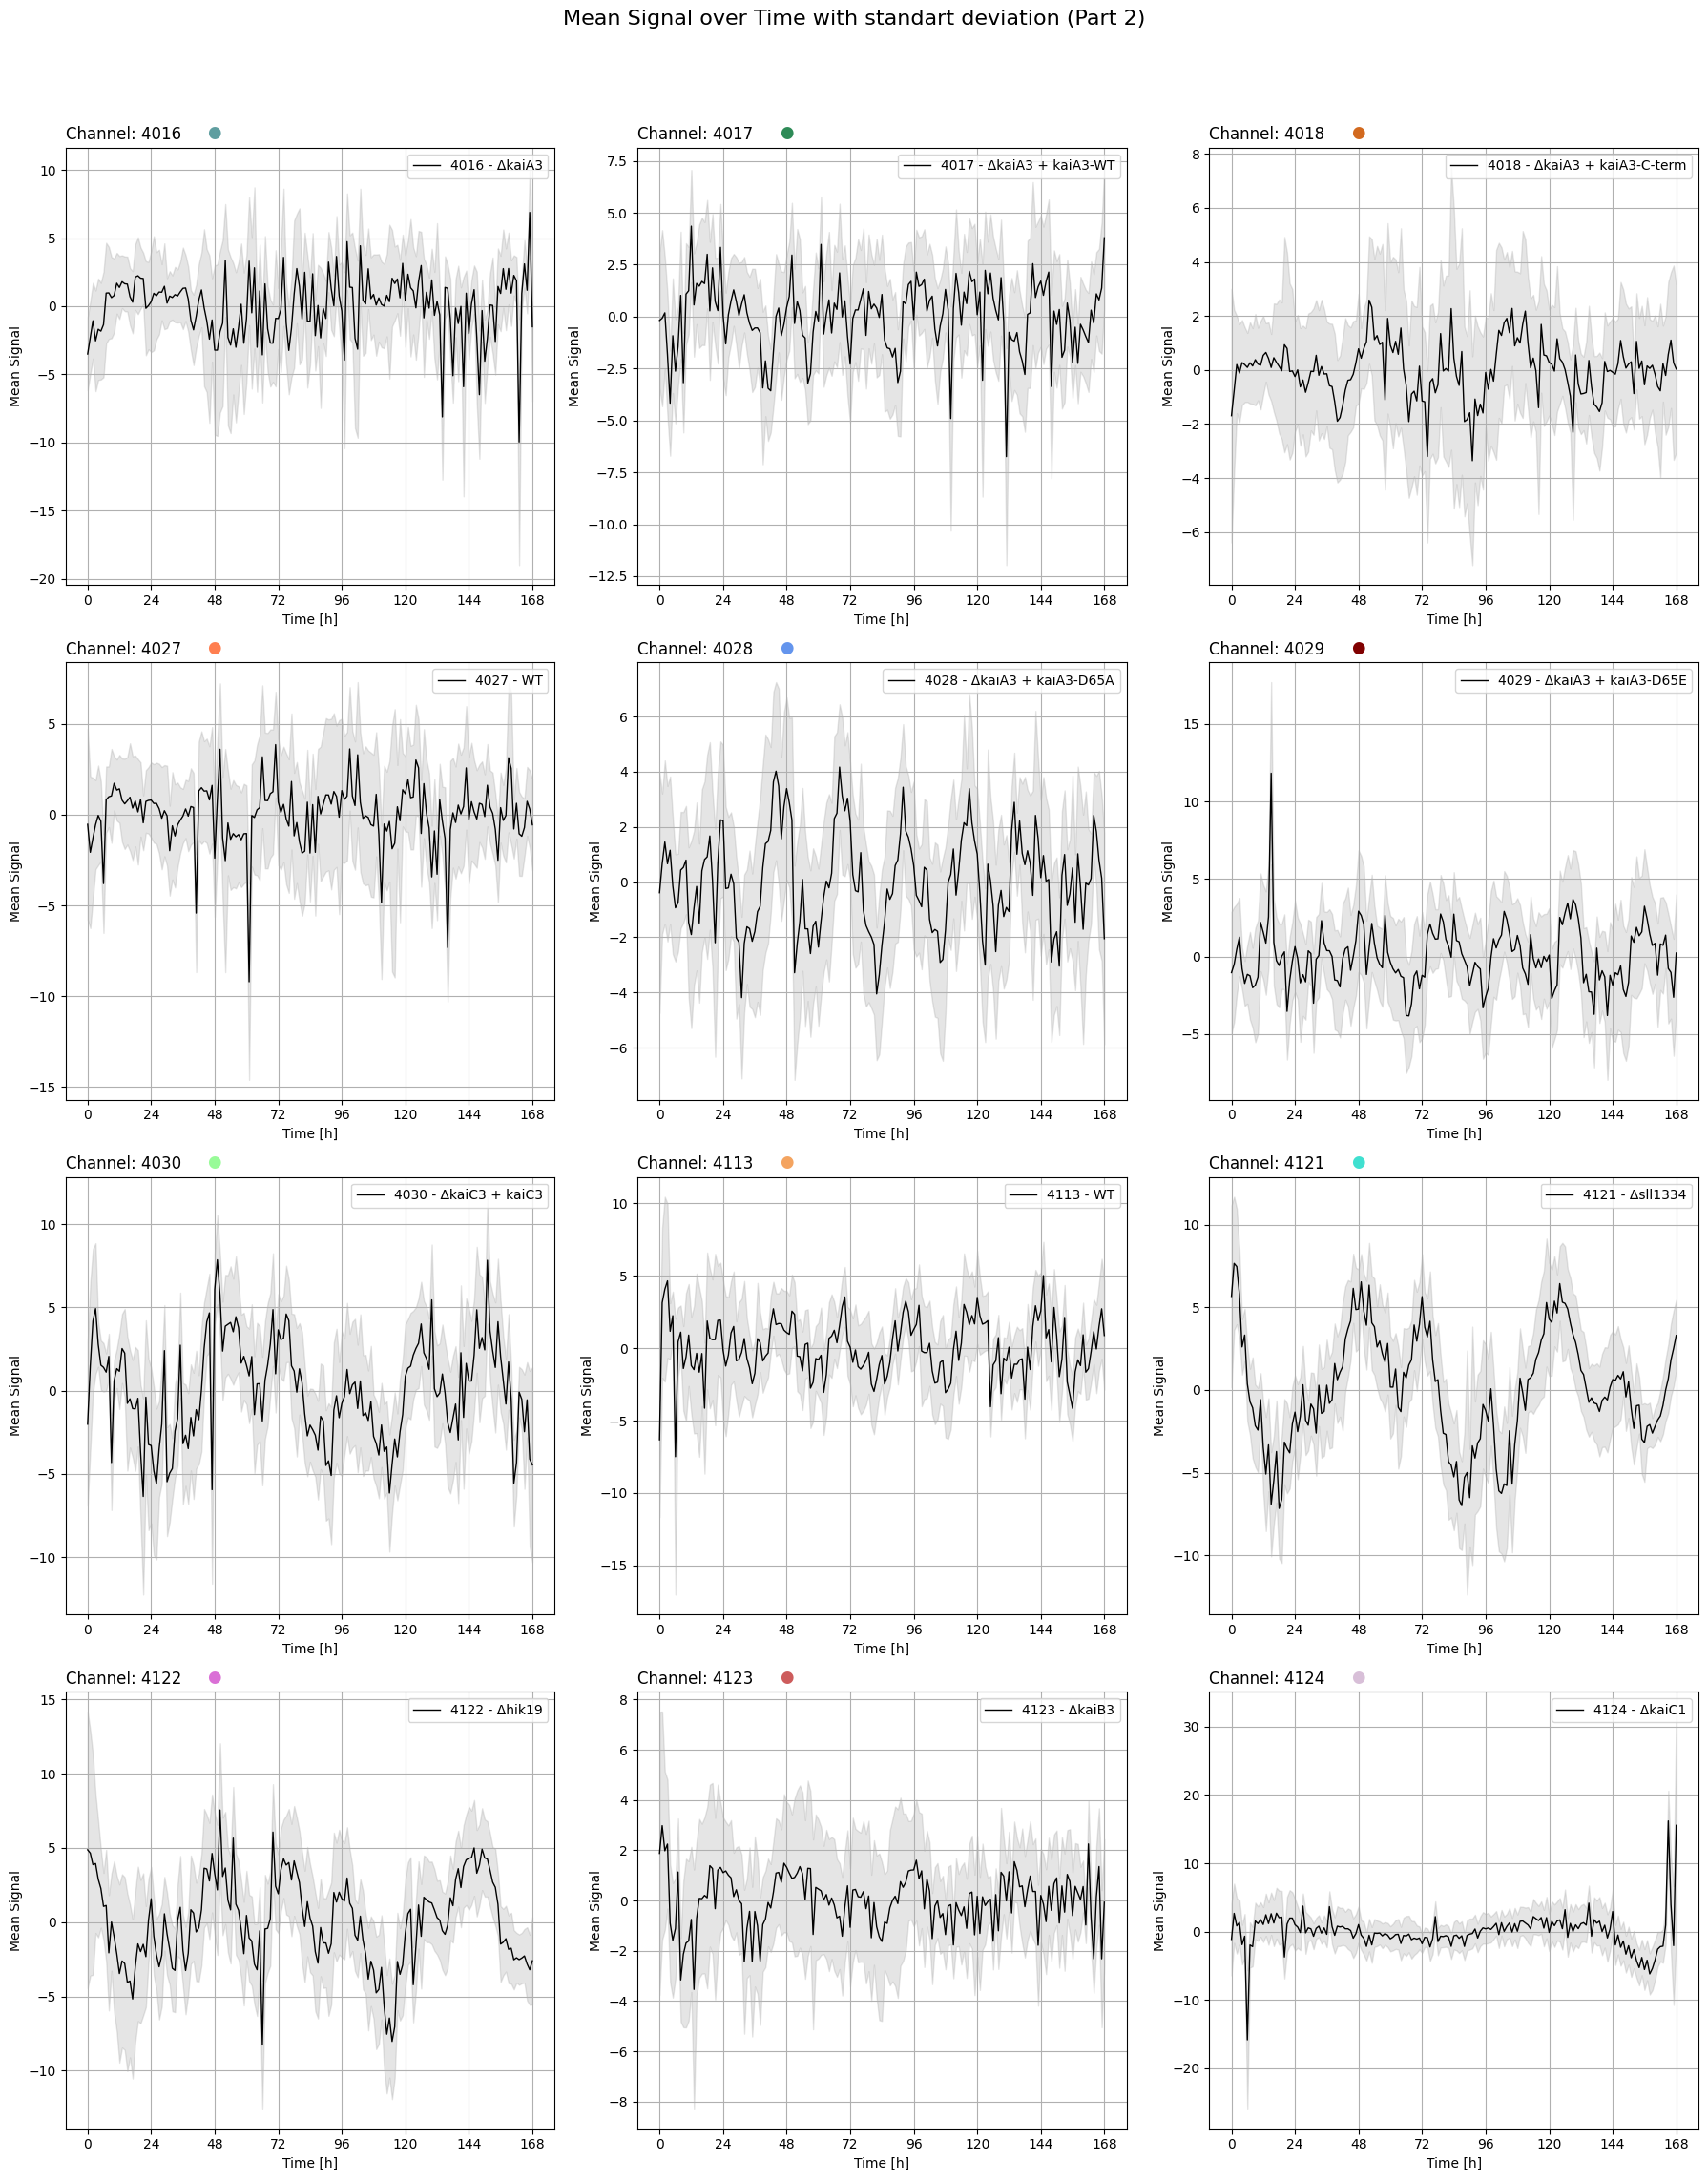

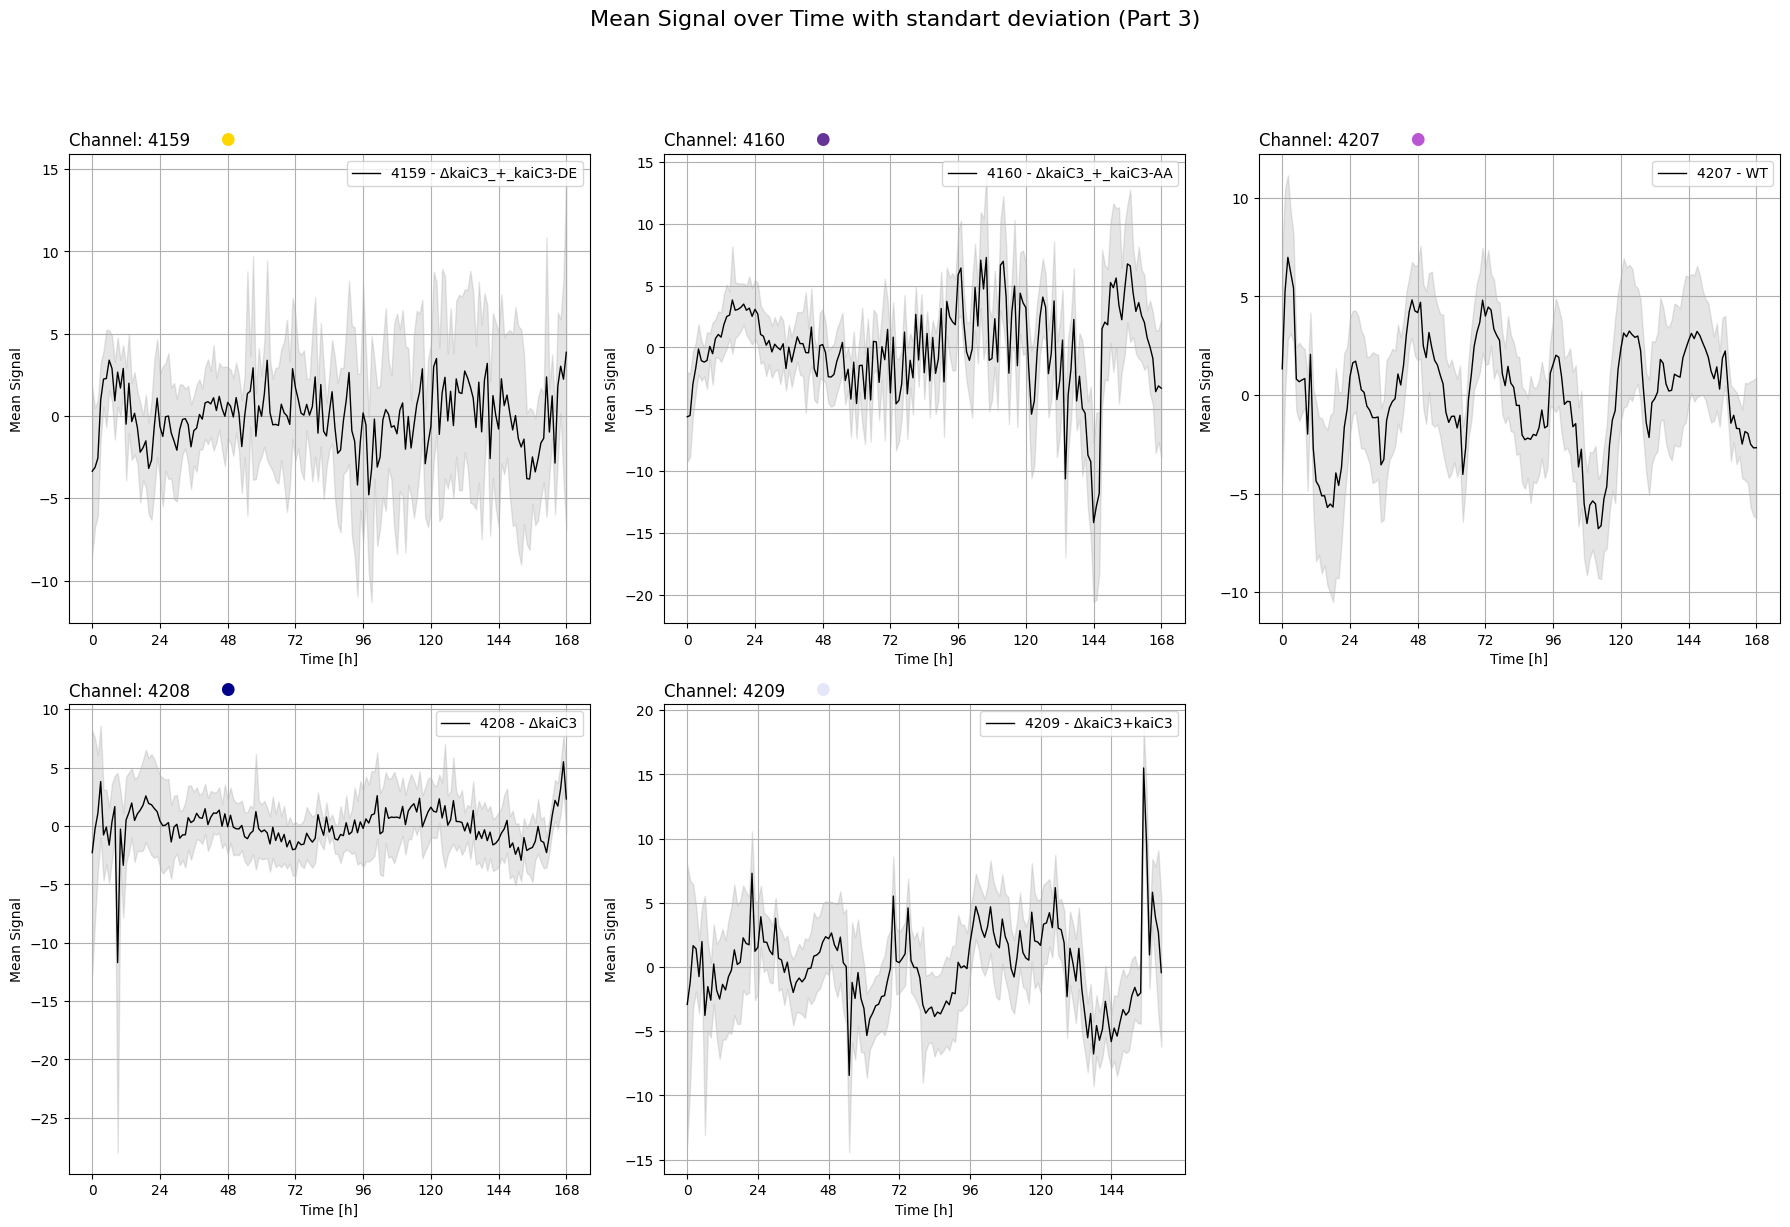

In [34]:
# Value over time + std
try:
    # Load the combined results file with names
    df_merged = pd.read_csv(combined_sig_mean_std_path, delimiter=';', decimal='.')

    # Get all unique Omero_IDs (experiments)
    omero_ids = sorted(df_merged['OmeroID'].unique())  # Sort the Omero_IDs
    number_of_ids = len(omero_ids)

    # Determine the number of rows and columns for the subplots
    n_cols = 3  # columns per plot
    n_rows_per_plot = 4  # rows per plot
    n_plots = (number_of_ids + n_rows_per_plot * n_cols - 1) // (
        n_rows_per_plot * n_cols)  # number of plots

    # Iterate over the pages
    for plot_index in range(n_plots):
        start_index = plot_index * n_rows_per_plot * n_cols
        end_index = min((plot_index + 1) * n_rows_per_plot * n_cols, number_of_ids)
        plot_omerids = omero_ids[start_index:end_index]

        # Create the subplots
        fig, axes = plt.subplots(n_rows_per_plot, n_cols,
                                 figsize=(18, 6 * n_rows_per_plot))  # Adjust figsize
        fig.suptitle(
            f'Mean Signal over Time with standart deviation (Part {plot_index + 1})',
            fontsize=16)  # Gesamt-Titel für die Figure

        # Iterate over each Omero_ID in the current page
        for i, omero_id in enumerate(plot_omerids):
            df_id = df_merged[df_merged['OmeroID'] == omero_id]
            name = df_id['Name'].iloc[0]  # Get the name for the legend

            # Determine the subplot position
            row = i // n_cols
            col = i % n_cols
            if n_rows_per_plot > 1:
                ax = axes[row, col]
            elif n_cols > 1:
                ax = axes[col]
            else:
                ax = axes

            # Plot the mean for the current Omero_ID
            color = 'black'  # Set the color to black for all experiment lines
            ax.plot(df_id['time'], df_id['mean'], label=f"{omero_id} - {name}", color=color,
                    linewidth=1.0)  # Increased linewidth

            # Add a colored dot to the title, next to the experiment number
            ax.text(0.29, 1.034, '●', transform=ax.transAxes,
                    color=id_marker_color_assignment[omero_id]['color'],
                    fontsize=12, va='center', ha='left')

            # Plot the standard deviation as a shaded area
            ax.fill_between(df_id['time'], df_id['mean'] - df_id['std'],
                            df_id['mean'] + df_id['std'], color='gray', alpha=0.2)

            ax.set_title(f'Channel: {omero_id}', loc='left')
            ax.set_xlabel('Time [h]')
            ax.set_ylabel('Mean Signal')
            ax.grid(True)
            ax.set_xticks(np.arange(0, df_id['time'].max() + 1, 24))  # Set x-ticks
            ax.legend()

        # Delete any unused subplots
        if end_index < plot_index * n_rows_per_plot * n_cols + n_rows_per_plot * n_cols:
            for j in range(end_index - plot_index * n_rows_per_plot * n_cols,
                           n_rows_per_plot * n_cols):
                row = j // n_cols
                col = j % n_cols
                if n_rows_per_plot > 1:
                    ax = axes[row, col]
                elif n_cols > 1:
                    ax = axes[col]
                else:
                    ax = axes
                ax.remove()

        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted layout
        # Save the plot
        output_path = Path(
            'Master_plots') / f'mean_signal_over_time_std_subplt_part_{plot_index + 1}.png' 
        output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
        plt.savefig(output_path, dpi=300)
        plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

## Compare WT plots

OmeroID 4017 excluded from plotting.
Number of WTs: 8



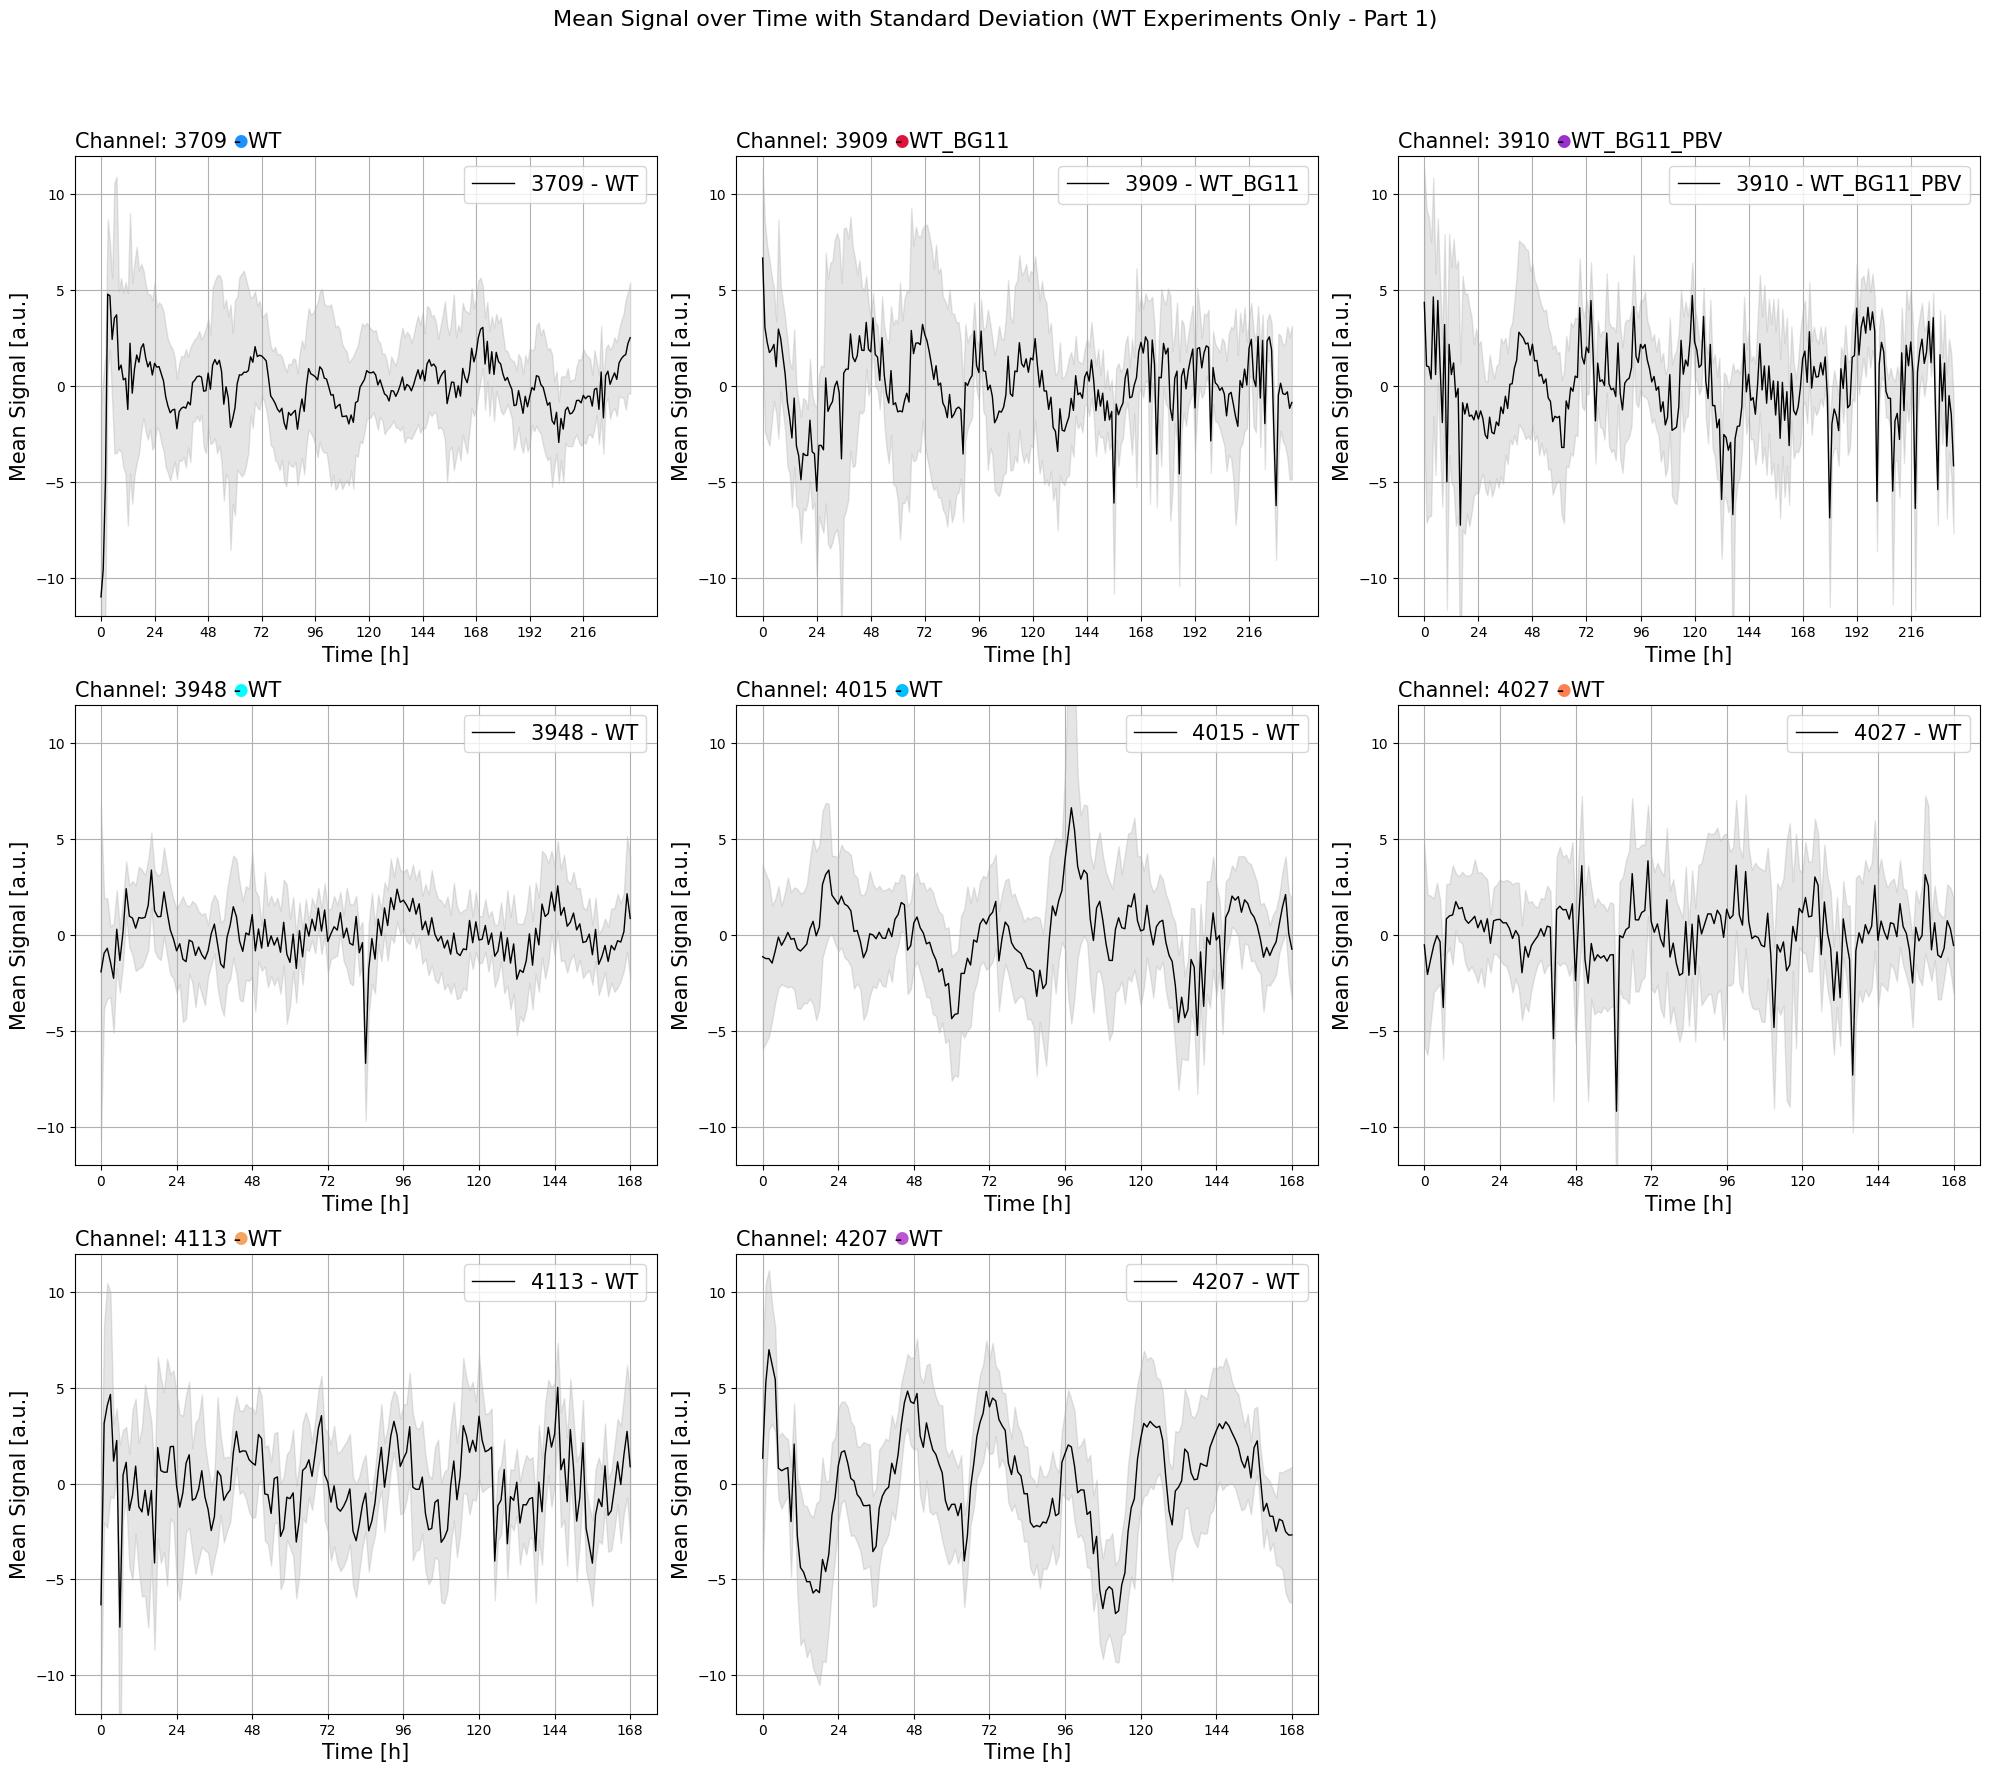

In [35]:
try:
    # Load the combined results file with names

    # Filter for 'WT' experiments only
    df_wt_only = df_merged[df_merged['Name'].str.contains('WT', case=False, na=False)].copy()

    # Get all unique Omero_IDs (experiments) for WT only
    omero_ids_wt = sorted(df_wt_only['OmeroID'].unique())  # Sort the Omero_IDs
    number_of_wt_ids = len(omero_ids_wt)
    
    # Exclude OmeroID 4017 if it's present
    if 4017 in omero_ids_wt:
        omero_ids_wt.remove(4017)
        number_of_wt_ids = number_of_wt_ids - 1
        print("OmeroID 4017 excluded from plotting.")

    if number_of_wt_ids == 0:
        print("No 'WT' experiments found in the data to plot.")
        exit()
    
    print(f'Number of WTs: {number_of_wt_ids}\n')
    

    # Calculate global min/max for Y-axis across all WT experiments
    global_min_y = (df_wt_only['mean'] - df_wt_only['std']).min()
    global_max_y = (df_wt_only['mean'] + df_wt_only['std']).max()

    y_buffer = (global_max_y - global_min_y) * 0.1
    global_min_y -= y_buffer
    global_max_y += y_buffer


    # Determine the number of rows and columns for the subplots
    n_cols = 3  # Fixed number of columns
    n_rows_per_plot = 4  # Max number of rows per plot
    n_plots = (number_of_wt_ids + n_rows_per_plot * n_cols - 1) // (
        n_rows_per_plot * n_cols)  # Number of plots needed

    # Iterate over the pages
    for plot_index in range(n_plots):
        start_index = plot_index * n_rows_per_plot * n_cols
        end_index = min((plot_index + 1) * n_rows_per_plot * n_cols, number_of_wt_ids)
        plot_omerids = omero_ids_wt[start_index:end_index]

        # Create the subplots
        fig, axes = plt.subplots(n_rows_per_plot, n_cols,
                                 figsize=(20, 6 * n_rows_per_plot))  # Adjust figsize
        # Flatten axes array for easier iteration if n_rows_per_plot or n_cols is 1
        if n_rows_per_plot == 1 and n_cols == 1:
            axes = np.array([axes]) # Make it an array even for single subplot
        elif n_rows_per_plot == 1 or n_cols == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten() # Flatten for consistent indexing


        fig.suptitle(
            f'Mean Signal over Time with Standard Deviation (WT Experiments Only - Part {plot_index + 1})',
            fontsize=16)  # Overall title for the figure

        # Iterate over each Omero_ID in the current page
        for i, omero_id in enumerate(plot_omerids):
            df_id = df_wt_only[df_wt_only['OmeroID'] == omero_id]
            name = df_id['Name'].iloc[0]  # Get the name for the legend

            # Determine the subplot position
            ax = axes[i] # Use flattened axes for consistent indexing

            # Plot the mean for the current Omero_ID
            color = 'black'  # Set the color to black for all experiment lines
            ax.plot(df_id['time'], df_id['mean'], label=f"{omero_id} - {name}", color=color,
                            linewidth=1.0)  # Increased linewidth

            # Add a colored dot to the title, next to the experiment number
            if omero_id in id_marker_color_assignment:
                ax.text(0.272, 1.034, '●', transform=ax.transAxes,
                                color=id_marker_color_assignment[omero_id]['color'],
                                fontsize=12, va='center', ha='left')
            else:
                print(f"Warning: Omero_ID {omero_id} not found in id_marker_color_assignment. Skipping custom color dot for this ID.")


            # Plot the standard deviation as a shaded area
            ax.fill_between(df_id['time'], df_id['mean'] - df_id['std'],
                            df_id['mean'] + df_id['std'], color='gray', alpha=0.2)

            ax.set_title(f'Channel: {omero_id} - {name}', loc='left', fontsize=15) 
            ax.set_xlabel('Time [h]', fontsize=15)
            ax.set_ylabel('Mean Signal [a.u.]', fontsize=15)
            ax.grid(True)
            ax.set_xticks(np.arange(0, df_id['time'].max() + 1, 24))  # Set x-ticks
            ax.set_ylim(-12, 12) 
            #ax.set_ylim(global_min_y, global_max_y)
            ax.legend(fontsize=15)

        # Delete any unused subplots (this part needs to be adjusted for flattened axes)
        remaining_subplots = number_of_wt_ids % (n_rows_per_plot * n_cols)
        if plot_index == n_plots - 1 and remaining_subplots != 0:
            for j in range(remaining_subplots, n_rows_per_plot * n_cols):
                axes[j].remove()


        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout(rect=[0, 0.035, 1, 0.95])  # Adjusted layout
        # Save the plot
        output_path = Path(
            'Master_plots') / f'WT_only_mean_signal_over_time_std_{plot_index + 1}.png'  
        output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
        plt.savefig(output_path, dpi=300)
        plt.show()

except FileNotFoundError:
    print(f"Error: The file '{combined_sig_mean_std_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


# Compare Experiments

In [36]:
experiments_csv_path = Path("./ID_all/Experiments.csv")

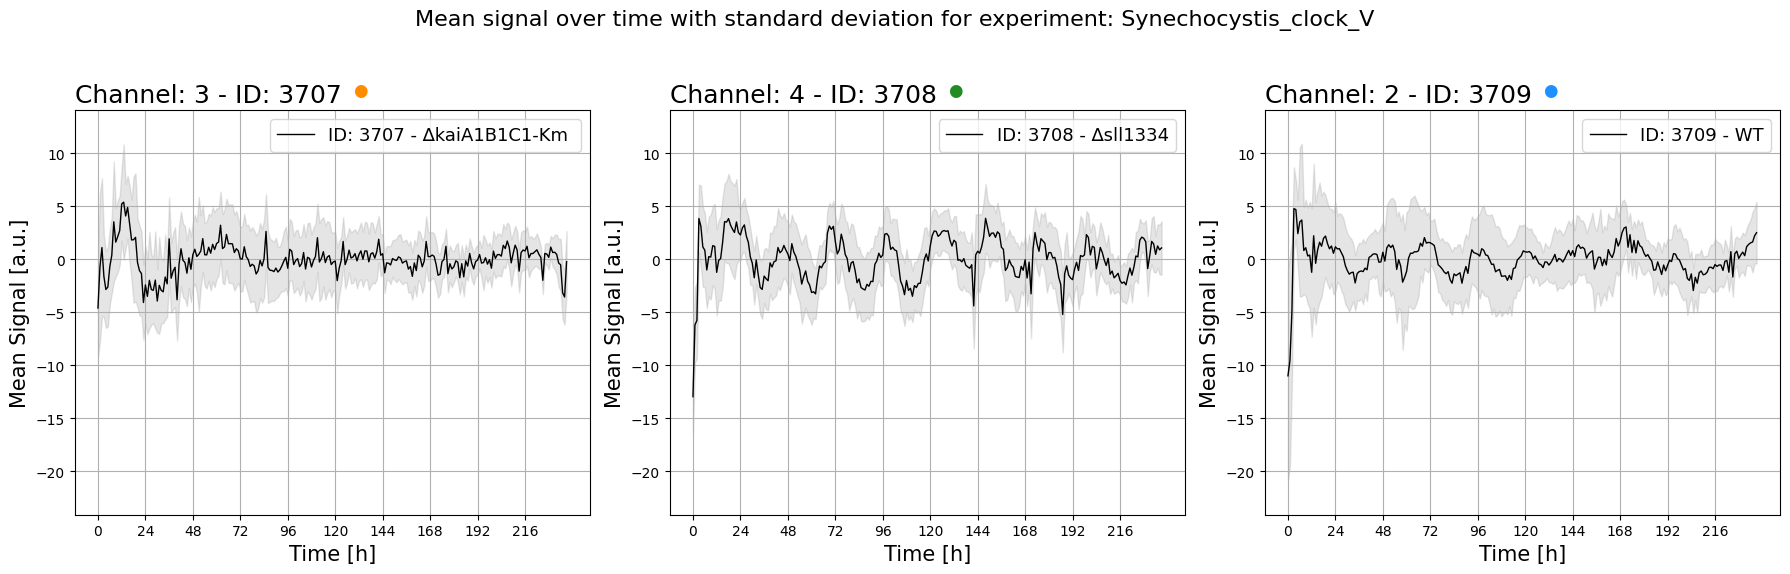

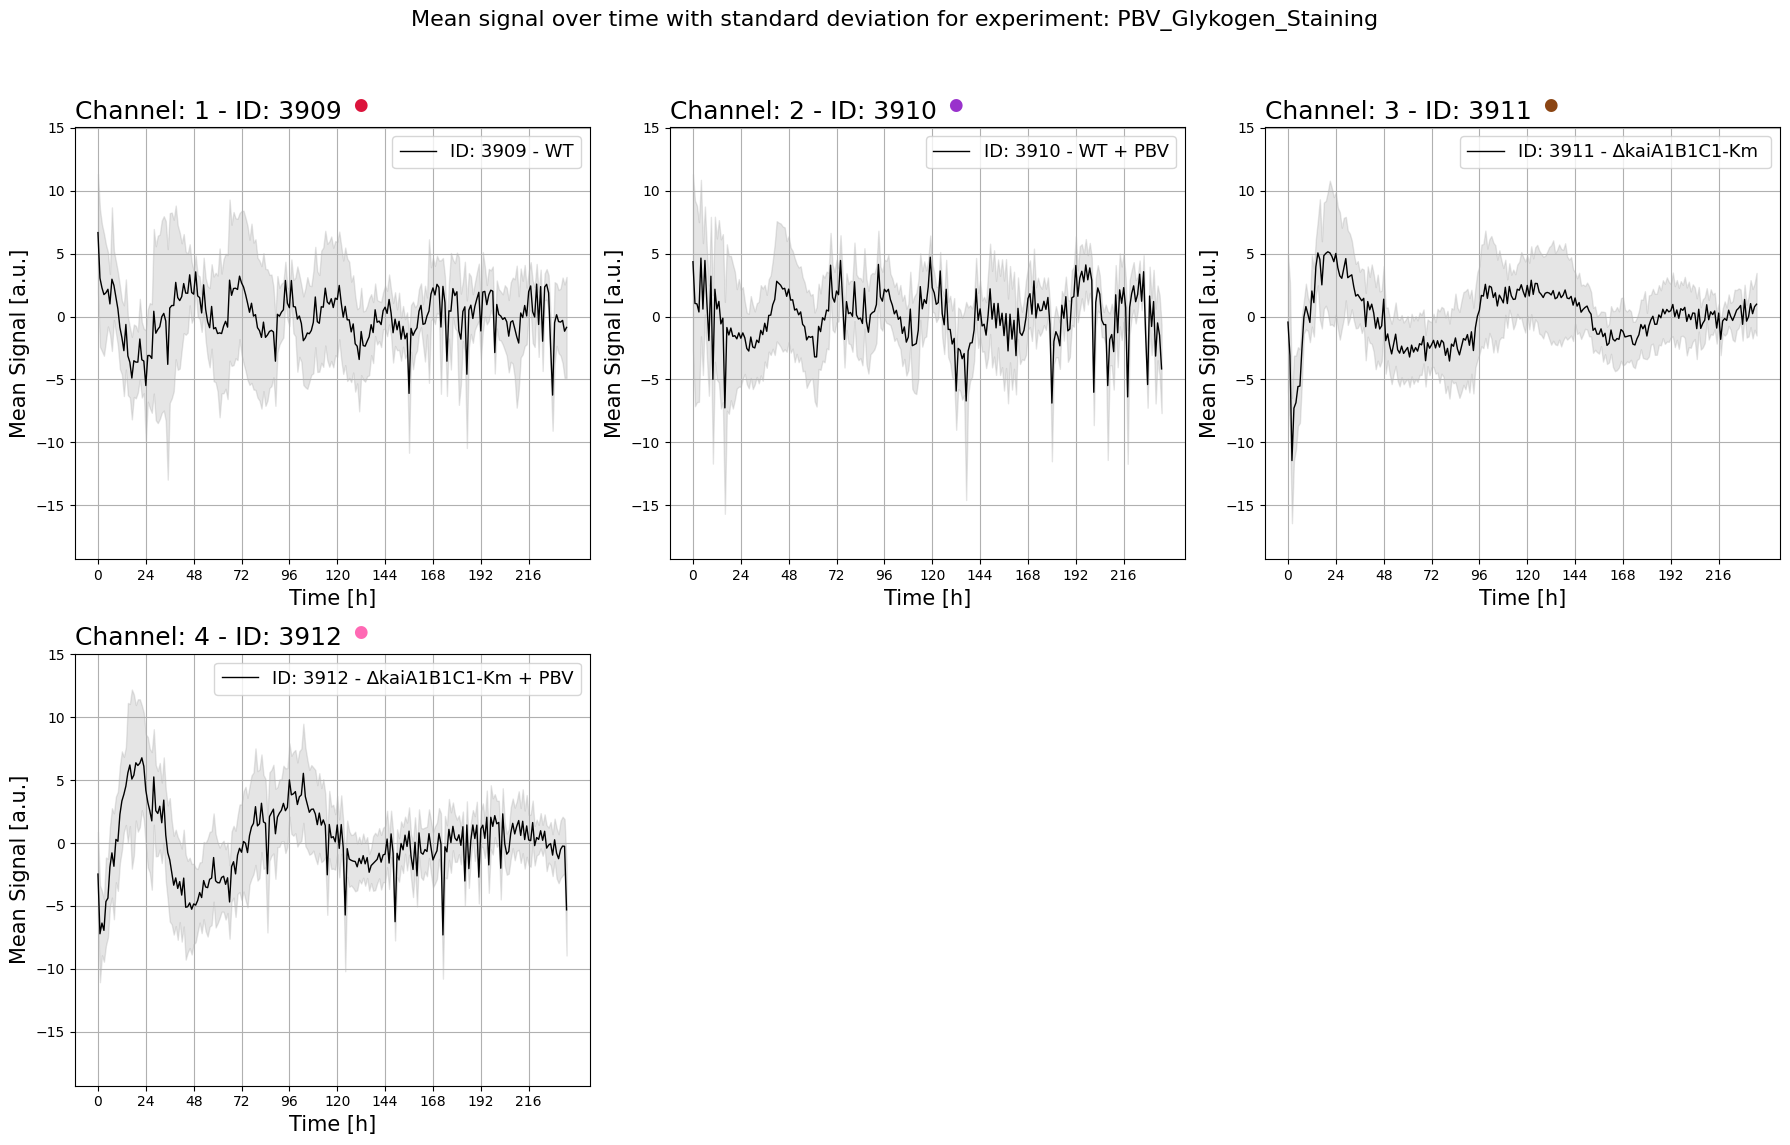

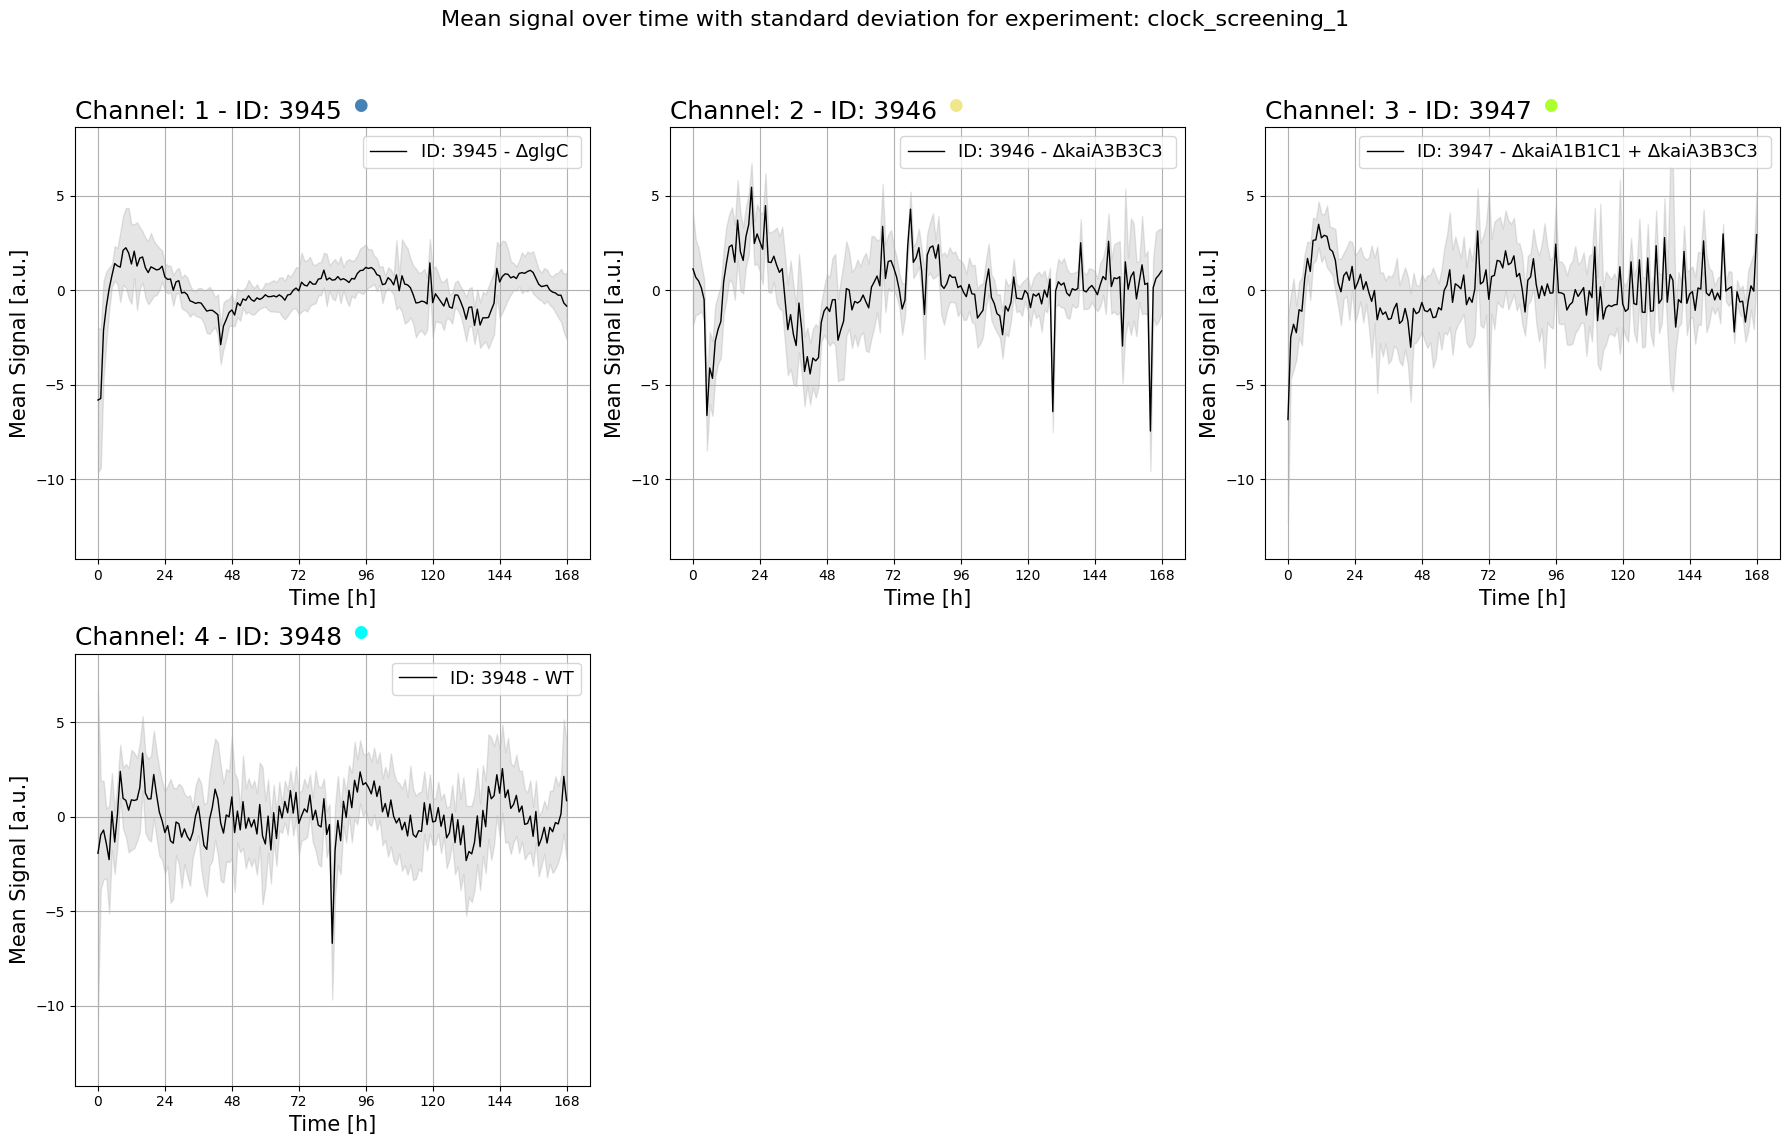

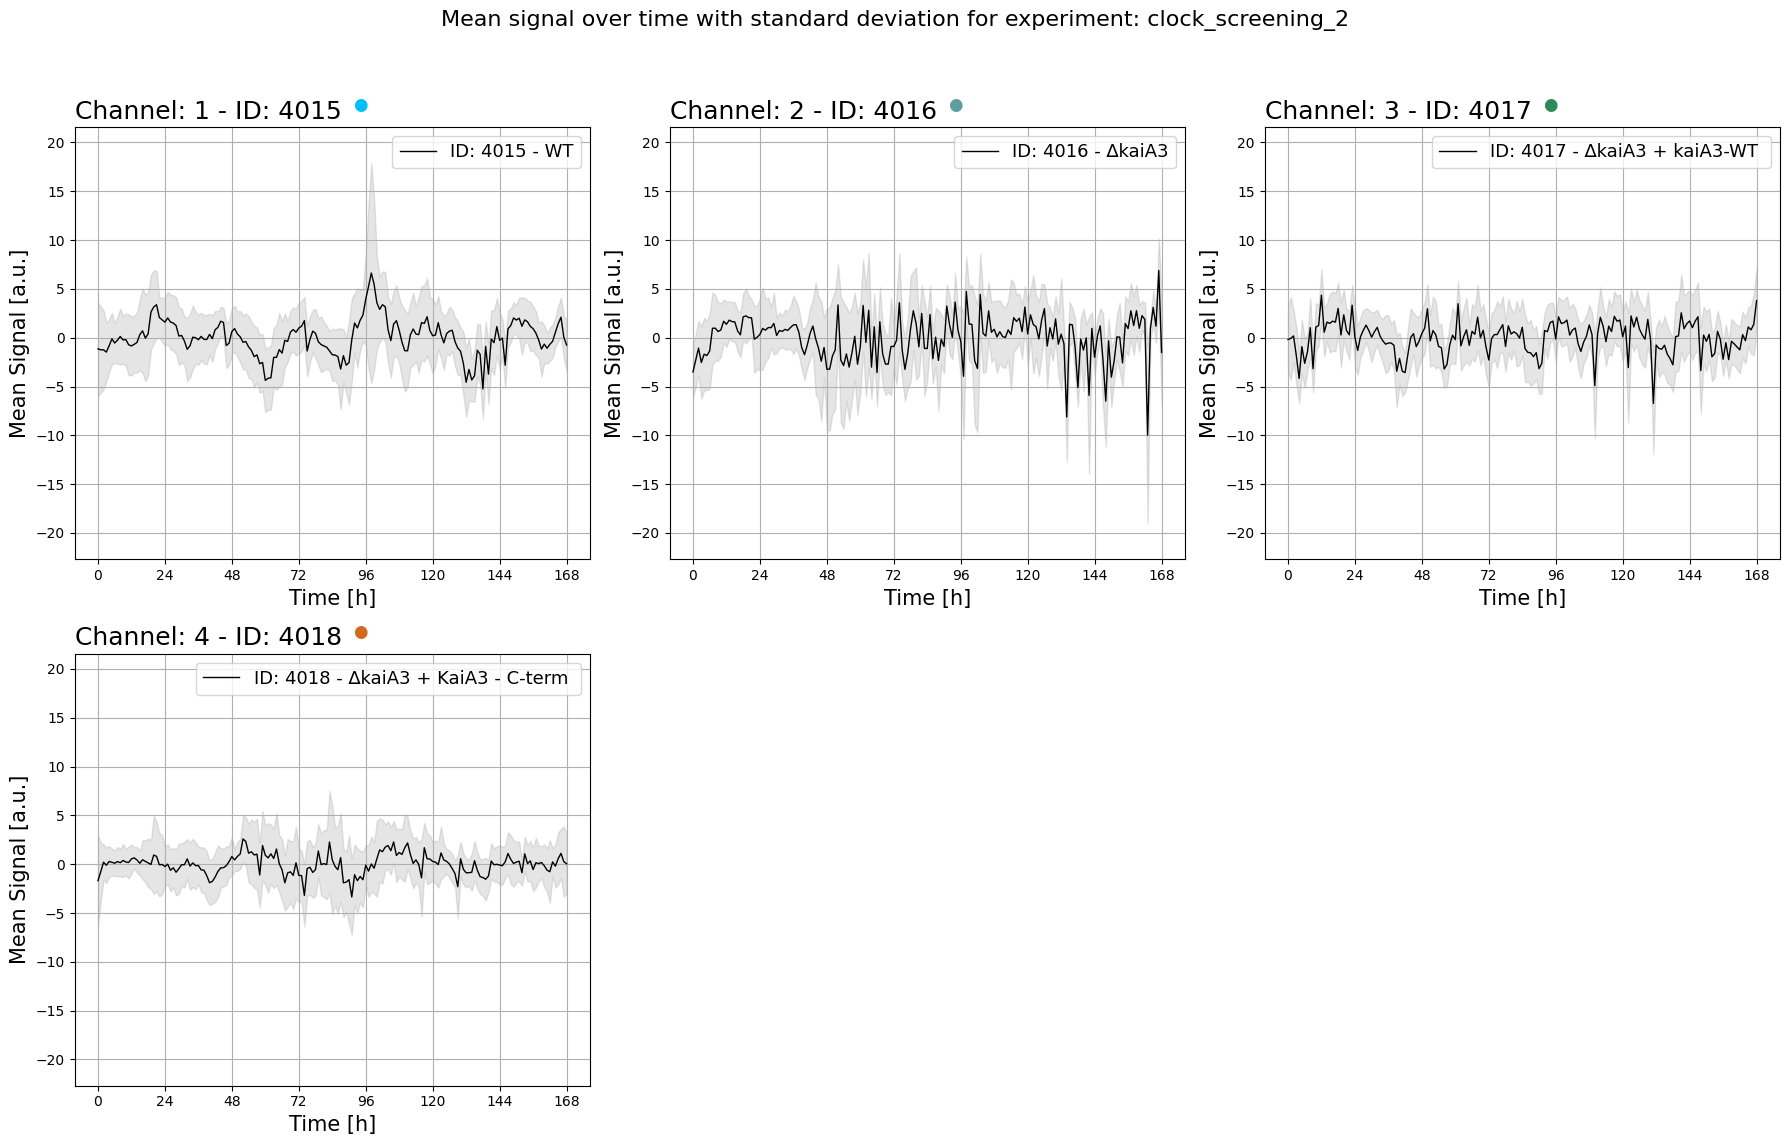

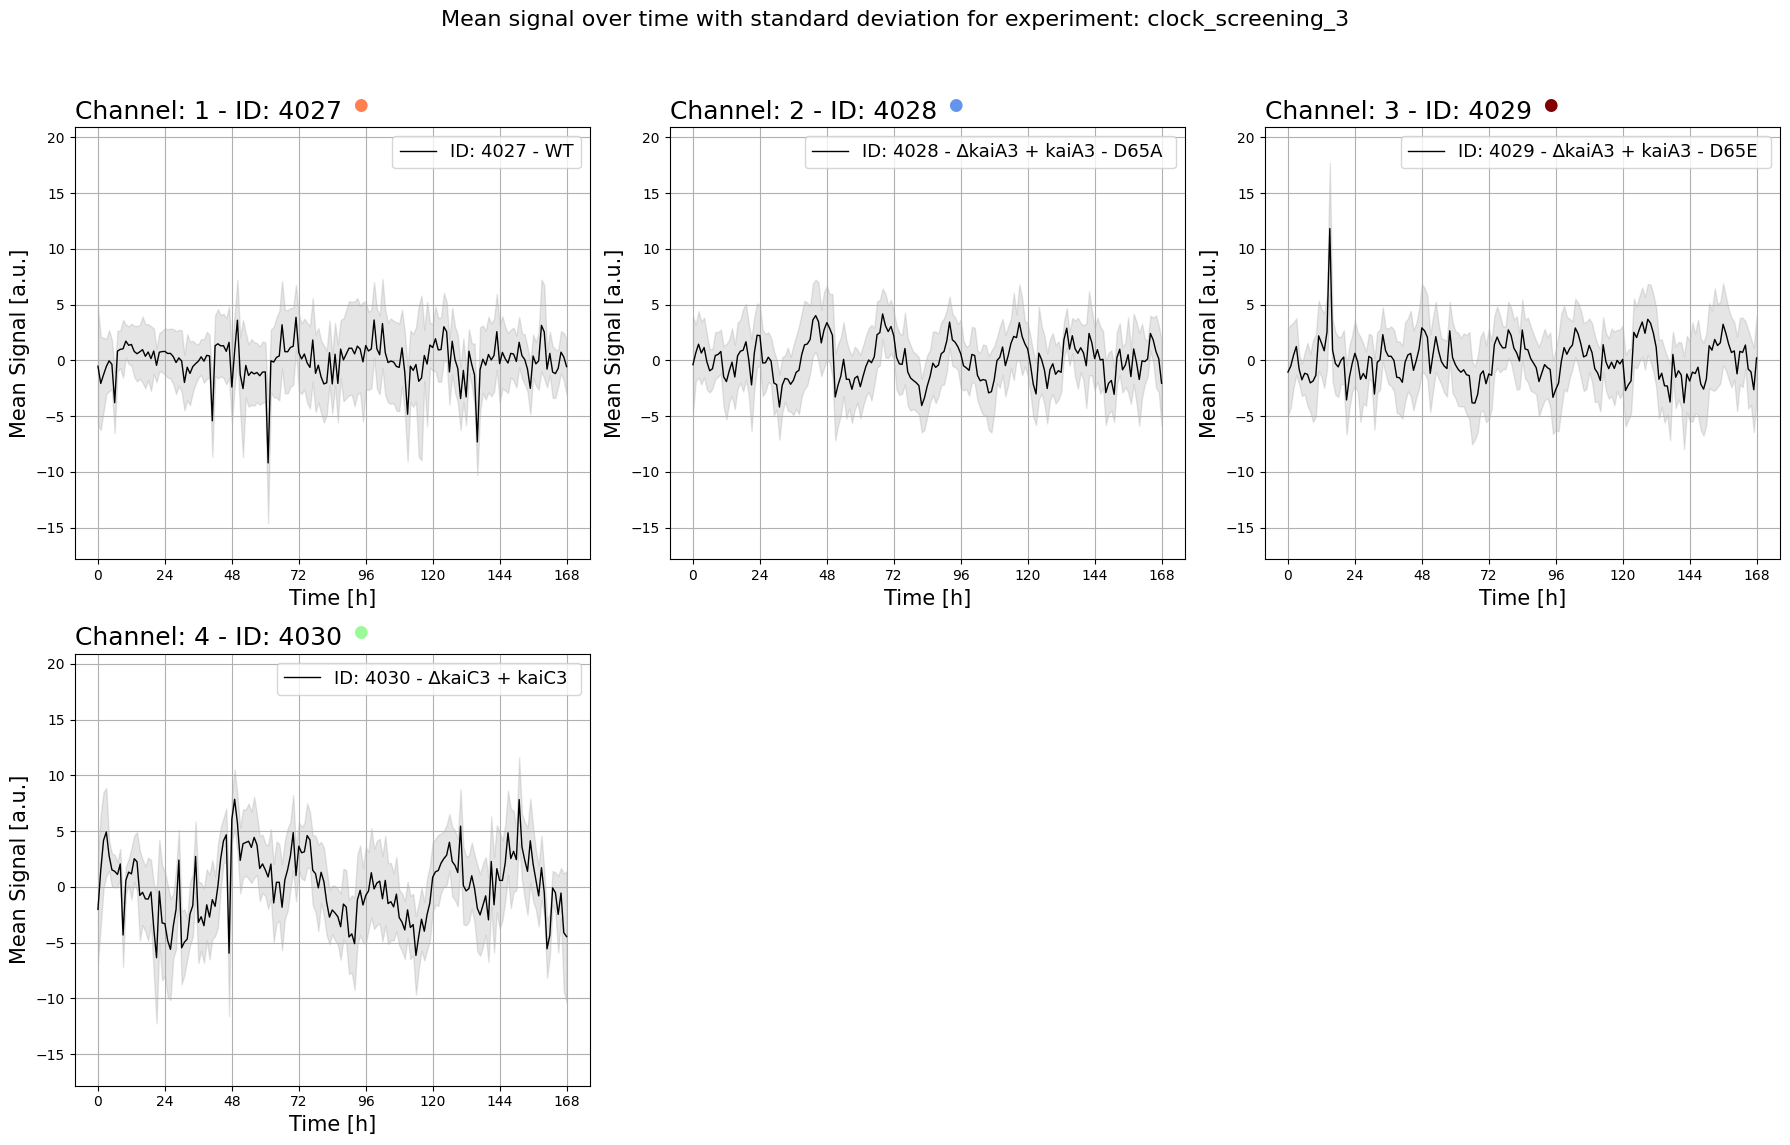

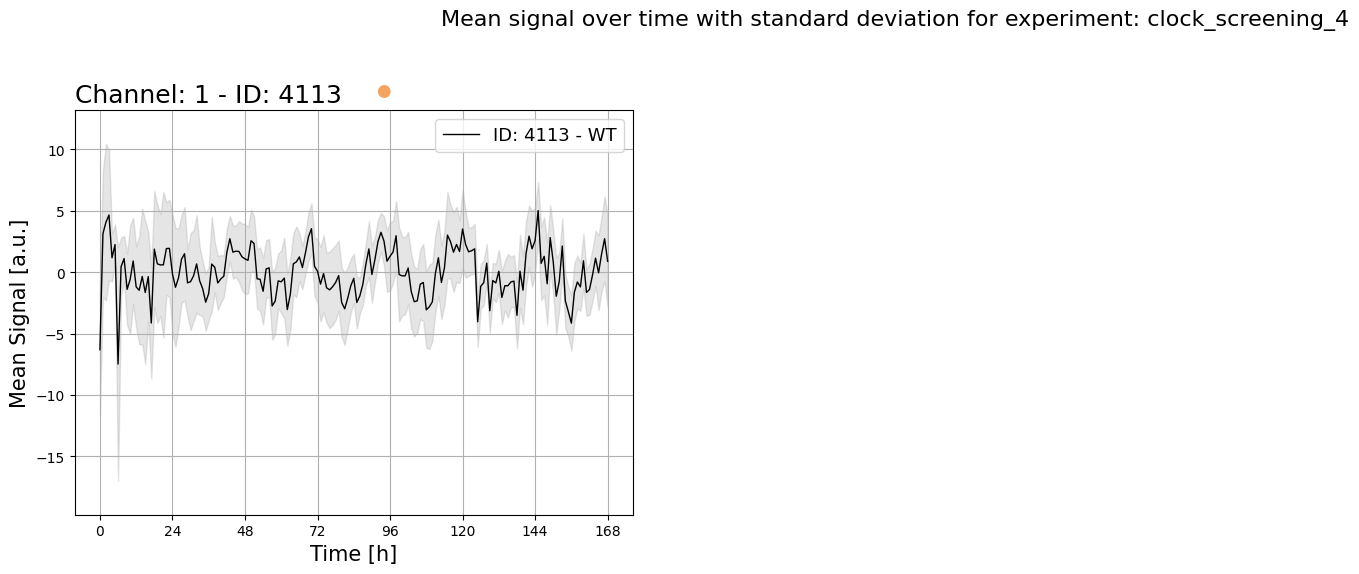

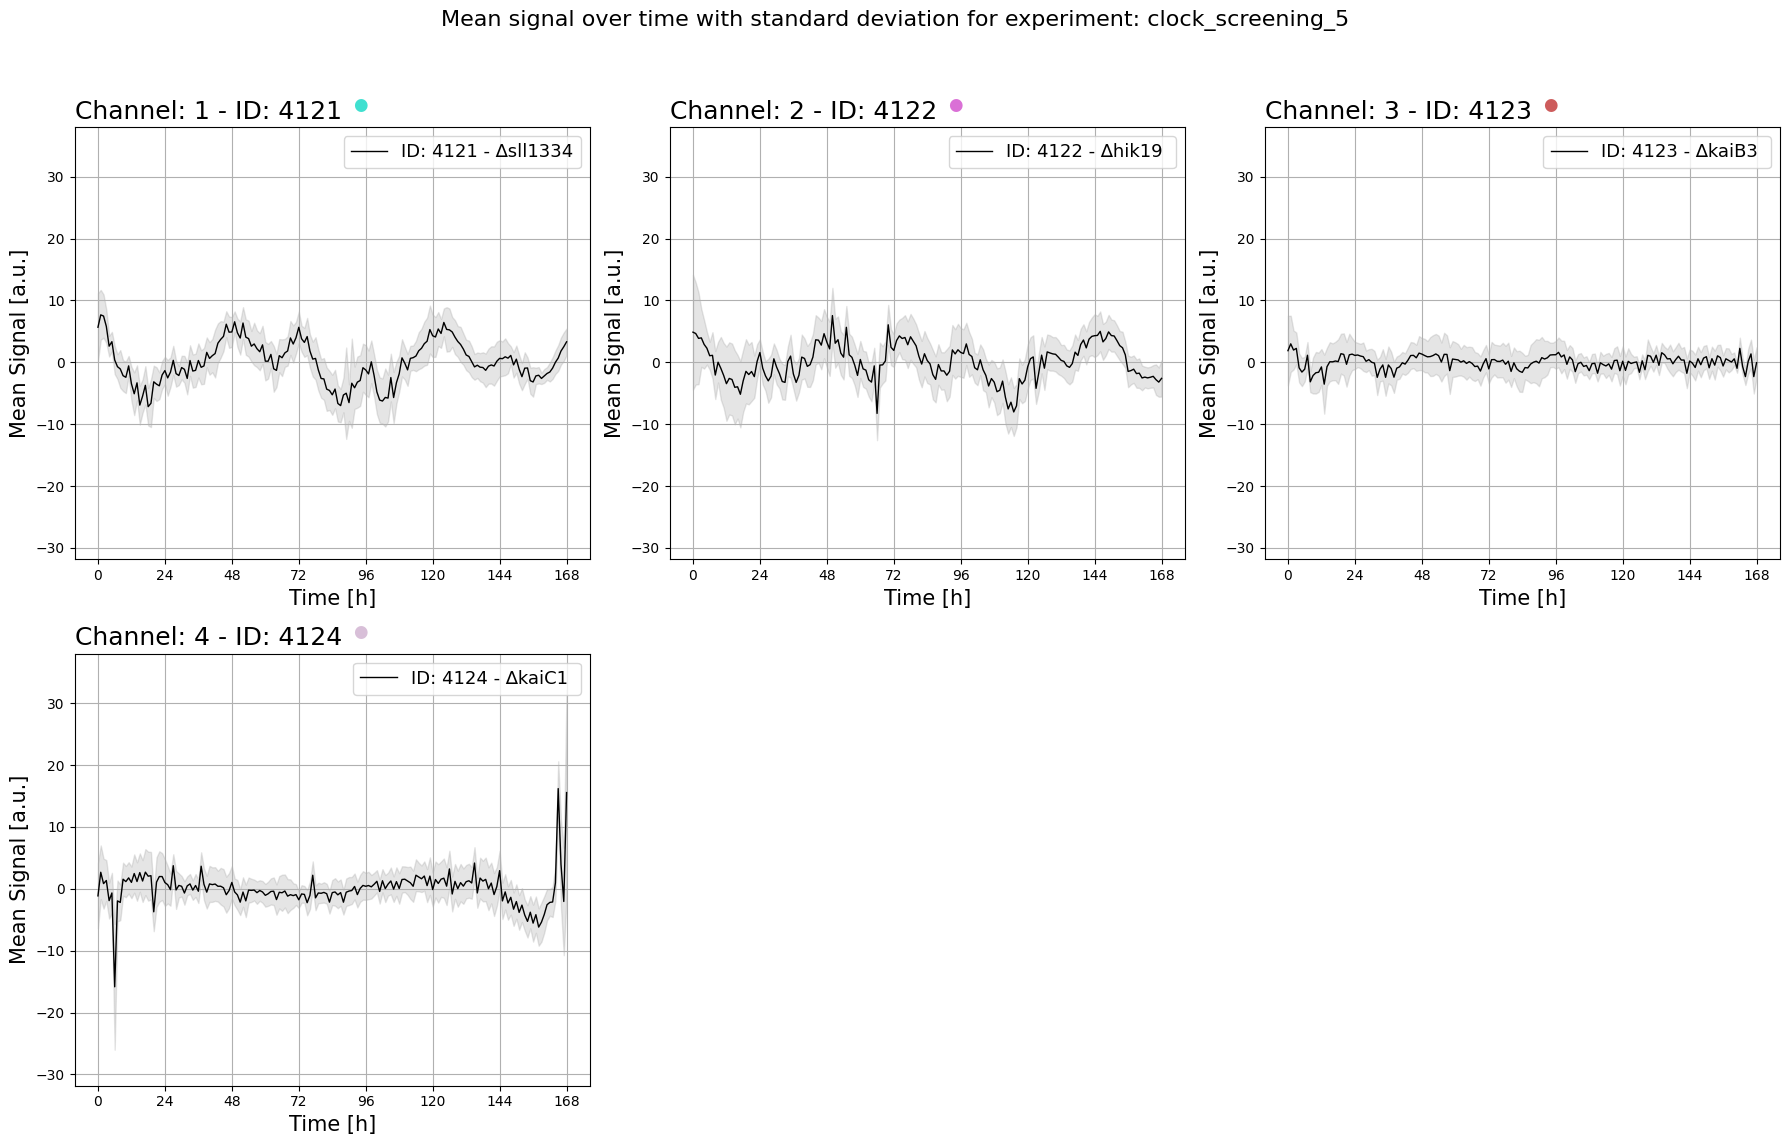

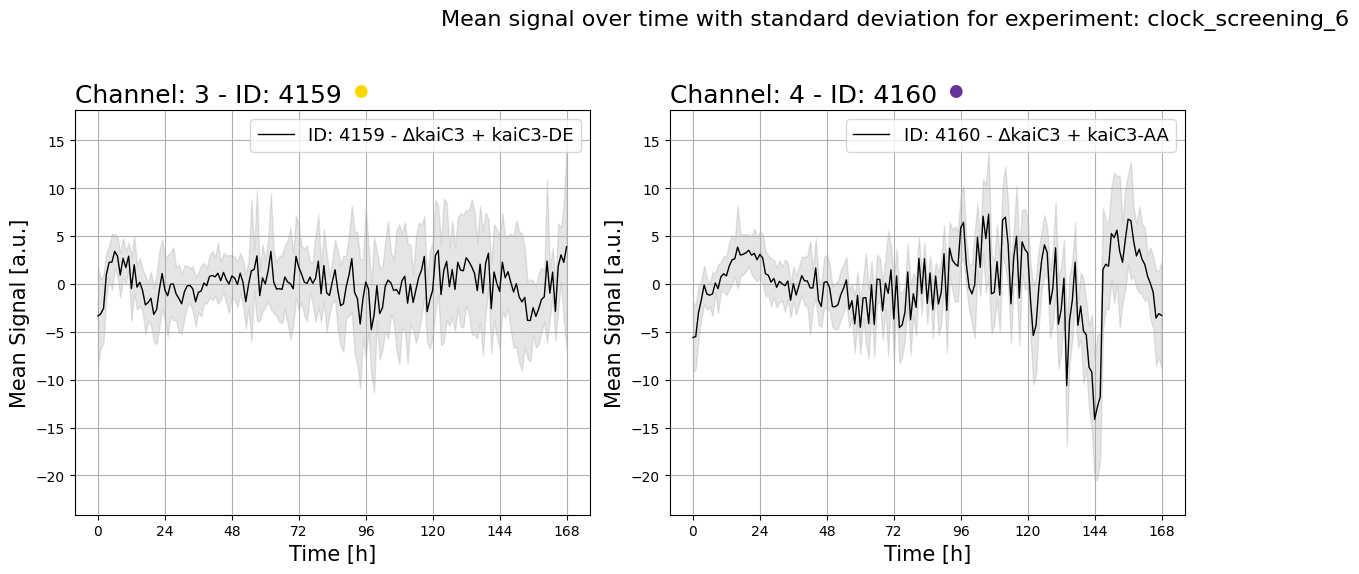

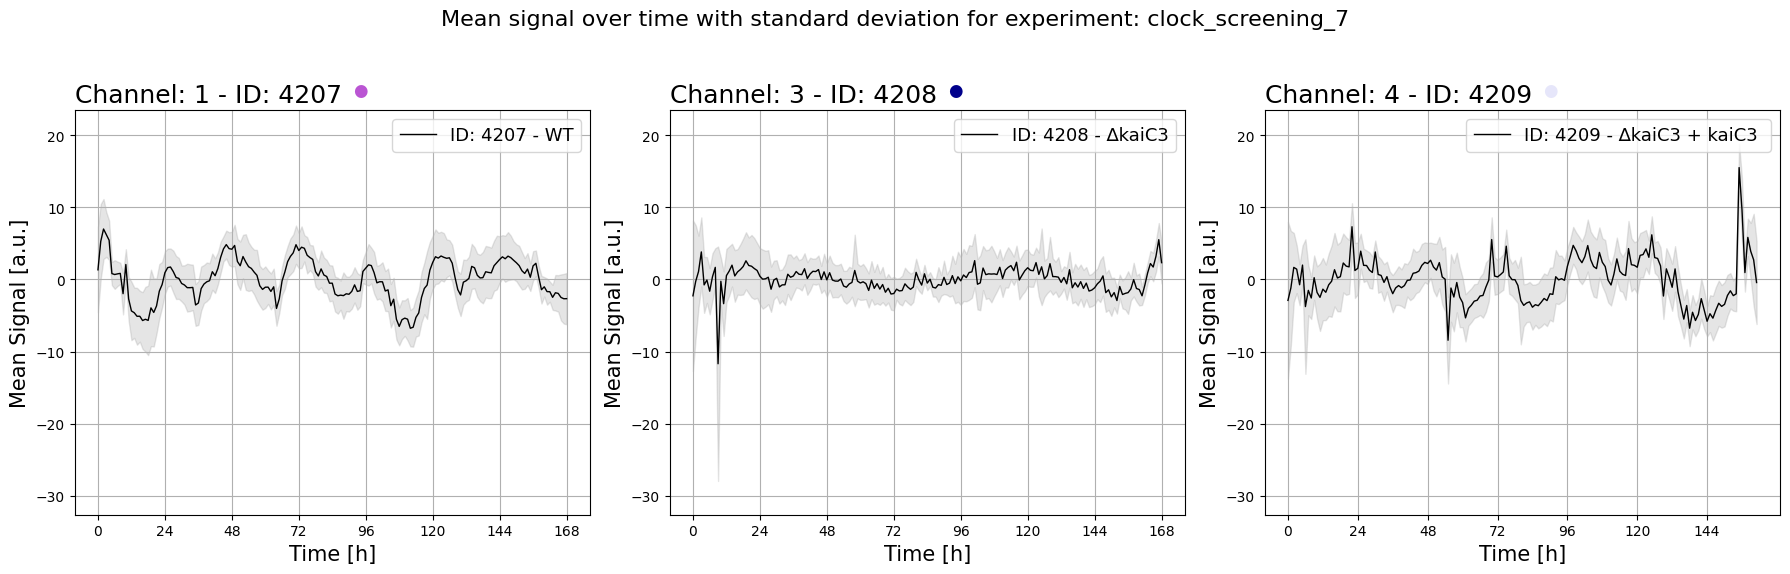

In [37]:
try:
    # Load the combined results
    df_merged = pd.read_csv(combined_sig_mean_std_path, delimiter=';', decimal='.')

    # Explicitly convert relevant columns to numeric
    # This is crucial to prevent 'unsupported operand type(s) for /: 'str' and 'str'' errors
    # if any column is read as string and used in numerical operations.
    df_merged['time'] = pd.to_numeric(df_merged['time'], errors='coerce')
    df_merged['mean'] = pd.to_numeric(df_merged['mean'], errors='coerce')
    df_merged['std'] = pd.to_numeric(df_merged['std'], errors='coerce')

    # Drop rows where conversion resulted in NaN (i.e., non-numeric data was present)
    df_merged.dropna(subset=['time', 'mean', 'std'], inplace=True)


    # Load the experiment details
    experiments_df = pd.read_csv(experiments_csv_path, delimiter=';')

    # Get all unique experiment names
    unique_experiments = experiments_df['Experiment'].unique()

    # Iterate over each unique experiment
    for experiment_name in unique_experiments:
        # Filter experiment details for the current experiment
        current_experiment_details = experiments_df[experiments_df['Experiment'] == experiment_name].copy()

        # Get the OmeroIDs for the current experiment
        # Ensure 'Dataset ID' is treated as numeric for comparison if it's mixed type
        current_omeroids = sorted(current_experiment_details['Dataset ID'].astype(int).unique())

        if not current_omeroids:
            print(f"No Dataset IDs found for experiment '{experiment_name}'. Skipping plot.")
            continue

        # Filter df_merged to get only the data for the current OmeroIDs
        df_current_experiment_data = df_merged[df_merged['OmeroID'].isin(current_omeroids)].copy()


        if df_current_experiment_data.empty:
            print(f"No data in combined_sig_mean_std.csv for experiment '{experiment_name}'. Skipping plot.")
            continue



        global_min_y = (df_current_experiment_data['mean'] - df_current_experiment_data['std']).min()
        global_max_y = (df_current_experiment_data['mean'] + df_current_experiment_data['std']).max()


        y_buffer = (global_max_y - global_min_y) * 0.1
        global_min_y -= y_buffer
        global_max_y += y_buffer

        # Determine the number of rows and columns for the subplots within this experiment plot
        n_cols_sub = 3  # Number of columns per experiment plot
        n_rows_sub = (len(current_omeroids) + n_cols_sub - 1) // n_cols_sub

        # Create the subplots for the current experiment
        fig, axes = plt.subplots(n_rows_sub, n_cols_sub, figsize=(18, 6 * n_rows_sub))
        fig.suptitle(f'Mean signal over time with standard deviation for experiment: {experiment_name}', fontsize=16)

        # Ensure axes is always a flat array, even for 1x1 or 1xN
        if n_rows_sub == 1 and n_cols_sub == 1:
            axes = np.array([axes])
        else:
            axes = axes.flatten()

        # Iterate over each OmeroID in the current experiment
        for i, omero_id in enumerate(current_omeroids):
            df_id = df_current_experiment_data[df_current_experiment_data['OmeroID'] == omero_id]
            
            # Get details for this specific OmeroID from experiments_df
            # Use .loc for more robust indexing
            detail_row = current_experiment_details.loc[current_experiment_details['Dataset ID'] == omero_id].iloc[0]
            channel = detail_row['Channel']
            strain = detail_row['Strain']

            ax = axes[i] # Use the flattened axes array

            # Plot the mean for the current Omero_ID
            color = 'black' # Set the color to black for all experiment lines
            ax.plot(df_id['time'], df_id['mean'], label=f"ID: {omero_id} - {strain}", color=color, linewidth=1.0)

            # Add a colored dot to the title, next to the experiment number
            if omero_id in id_marker_color_assignment:
                dot_color = id_marker_color_assignment[omero_id]['color']
                ax.text(0.54, 1.05, '●', transform=ax.transAxes,
                                color=dot_color,
                                fontsize=12, va='center', ha='left')
            else:
                print(f"Warning: OmeroID {omero_id} not found in id_marker_color_assignment. Skipping custom color dot for this ID.")

            # Plot the standard deviation as a shaded area
            ax.fill_between(df_id['time'], df_id['mean'] - df_id['std'],
                            df_id['mean'] + df_id['std'], color='gray', alpha=0.2)

            # Labeling: Chamber number, ID, and ID-associated color
            ax.set_title(f'Channel: {channel} - ID: {omero_id}', loc='left',fontsize=18)
            ax.set_xlabel('Time [h]',fontsize=15)
            ax.set_ylabel('Mean Signal [a.u.]',fontsize=15)
            ax.grid(True)

            # Check if df_id['time'] is empty or contains NaN before calling .max()
            if not df_id['time'].empty and not pd.isna(df_id['time'].max()):
                ax.set_xticks(np.arange(0, df_id['time'].max() + 1, 24)) # Set x-ticks
            else:
                print(f"Warning: 'time' data for OmeroID {omero_id} is empty or contains NaN. Skipping x-ticks setting for this subplot.")


            ax.set_ylim(global_min_y, global_max_y) # Set Y-axis limits globally for this experiment plot
            ax.legend(title="", loc='upper right',fontsize=13) # Legend with Strain name

        # Delete any unused subplots
        for j in range(len(current_omeroids), n_rows_sub * n_cols_sub):
            axes[j].remove()

        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save the plot in the "Master_plots/Experimente" folder
        # FIX: Explicitly convert master_plots_folder to string before joining if it's causing issues
        output_path = Path(str(master_plots_folder) + '/Experimente/mean_sig_over_time/' + f'{experiment_name}_mean_signal_over_time_std.png')
        output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
        plt.savefig(output_path, dpi=300)
        plt.show()

except FileNotFoundError as e:
    print(f"Error: A required file was not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


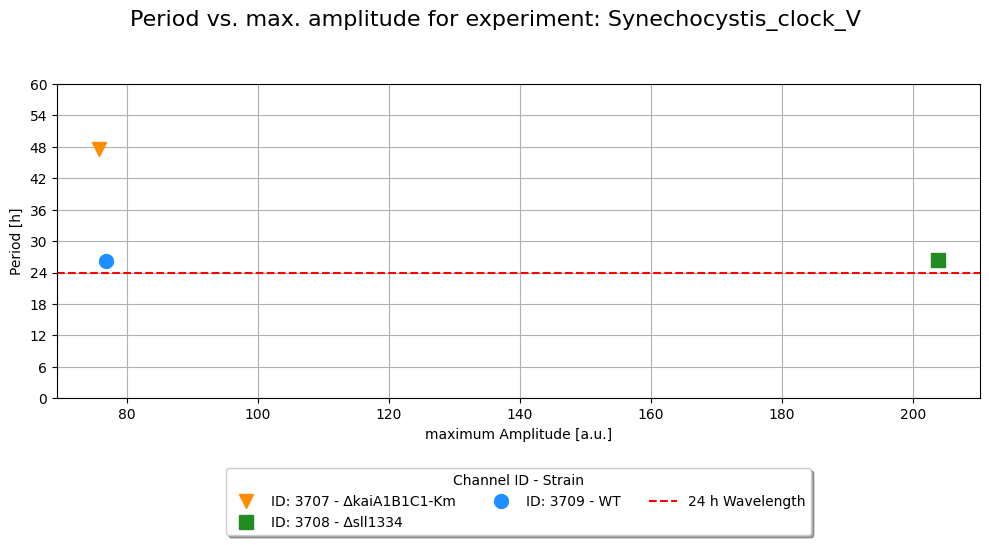

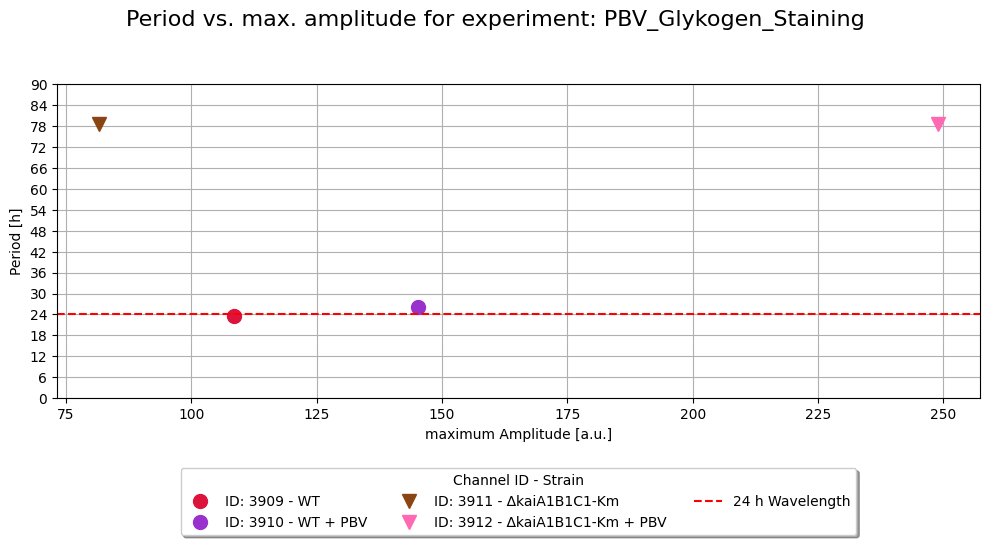

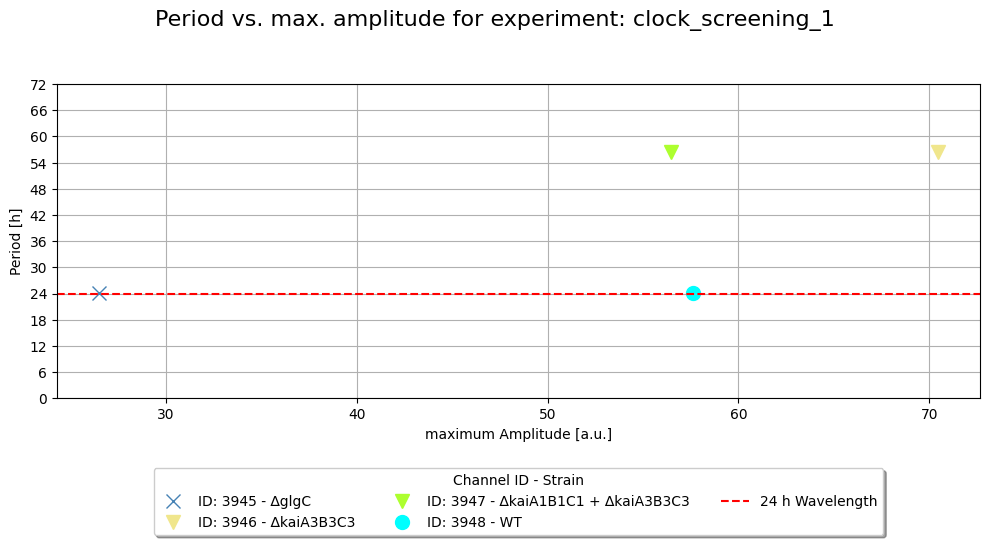

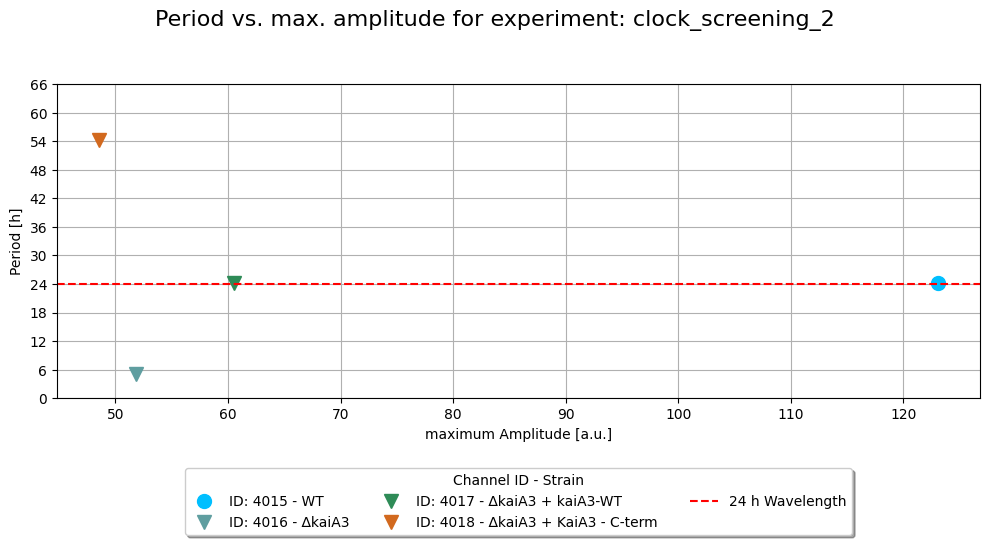

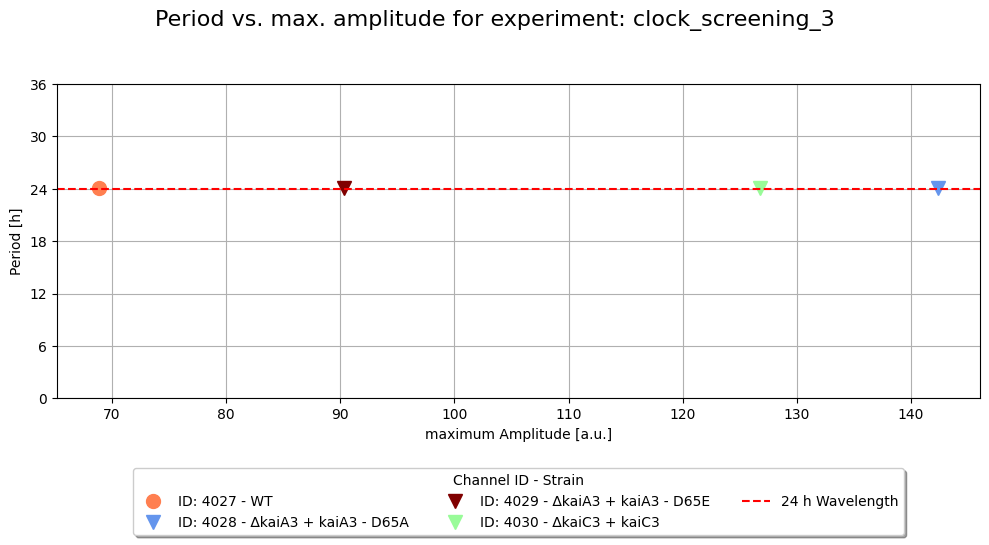

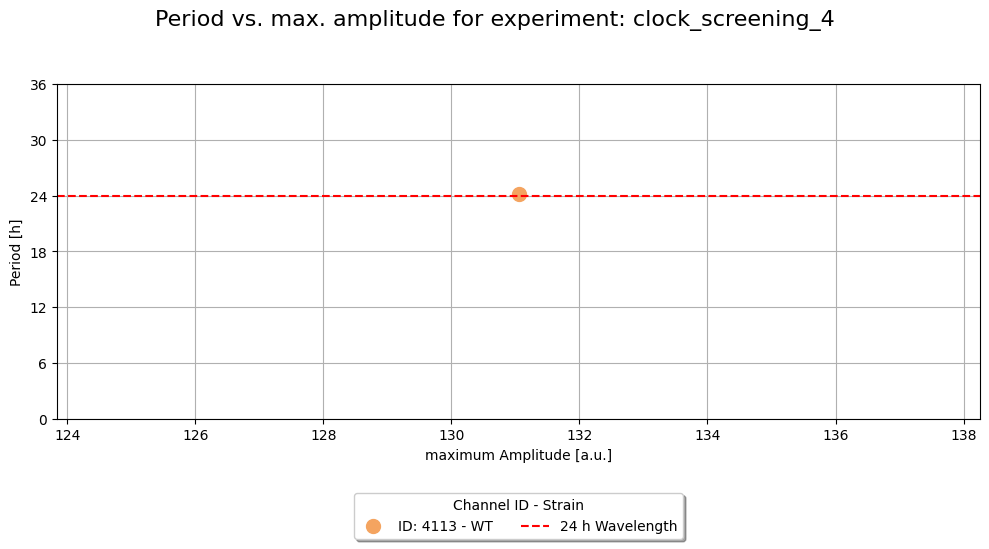

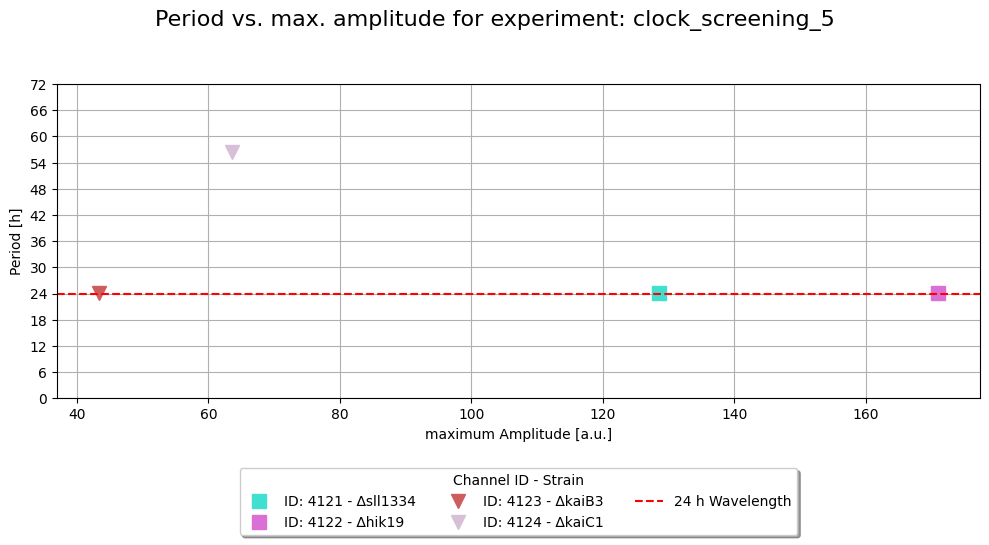

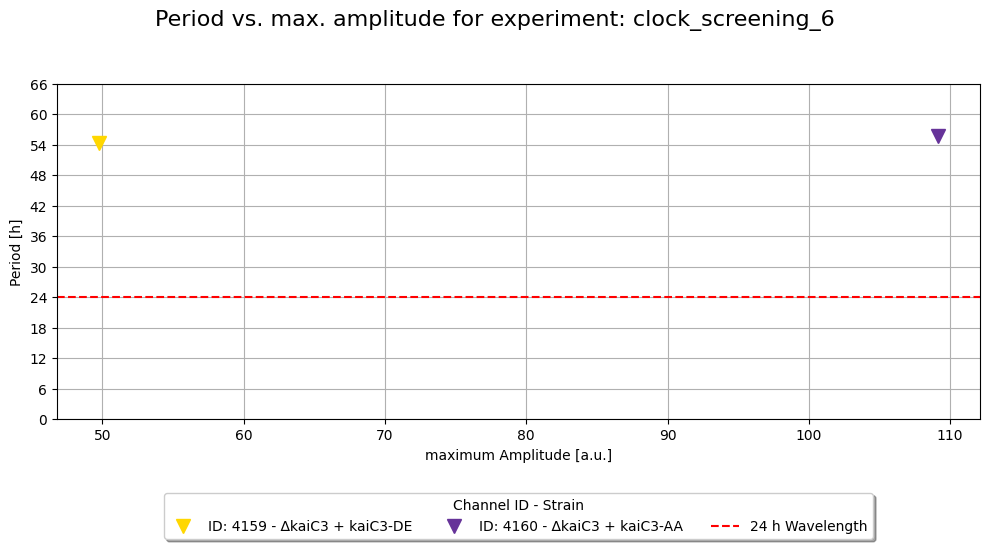

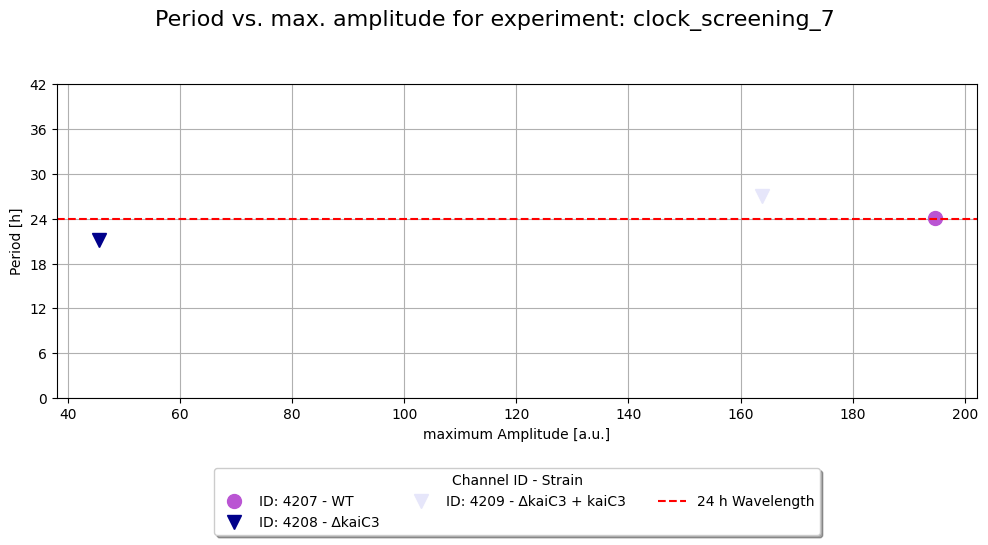

In [38]:
try:
    # Load the combined results (containing max_amplitude and 1_frequency_h)
    df_merged = pd.read_csv(combined_results_with_names_path, delimiter=';', decimal='.')

    # Explicitly convert relevant columns to numeric
    df_merged['max_amplitude'] = pd.to_numeric(df_merged['max_amplitude'], errors='coerce')
    df_merged['1_frequency_h'] = pd.to_numeric(df_merged['1_frequency_h'], errors='coerce')
    df_merged['Omero_ID'] = pd.to_numeric(df_merged['Omero_ID'], errors='coerce')

    # Drop rows where conversion resulted in NaN
    df_merged.dropna(subset=['max_amplitude', '1_frequency_h', 'Omero_ID'], inplace=True)


    # Load the experiment details
    experiments_df = pd.read_csv(experiments_csv_path, delimiter=';')

    # Get all unique experiment names
    unique_experiments = experiments_df['Experiment'].unique()

    # Iterate over each unique experiment
    for experiment_name in unique_experiments:
        # Filter experiment details for the current experiment
        current_experiment_details = experiments_df[experiments_df['Experiment'] == experiment_name].copy()

        # Get the OmeroIDs (Dataset IDs) for the current experiment
        current_omeroids = sorted(current_experiment_details['Dataset ID'].astype(int).unique())

        if not current_omeroids:
            print(f"No Dataset IDs found for experiment '{experiment_name}'. Skipping plot.")
            continue

        # Filter df_merged to get only the data for the current OmeroIDs
        df_current_experiment_data = df_merged[df_merged['Omero_ID'].isin(current_omeroids)].copy()

        if df_current_experiment_data.empty:
            print(f"No data in combined_results_with_names.csv for experiment '{experiment_name}'. Skipping plot.")
            continue

        # Calculate min/max for Y-axis ('1_frequency_h') within this experiment cluster
        max_y_data_current_experiment = df_current_experiment_data['1_frequency_h'].max()

        # Set Y-axis limits from 0 to max_y_data + 10
        y_lim_min = 0
        y_lim_max = max_y_data_current_experiment + 10

        # Create a single subplot for the current experiment
        fig, ax = plt.subplots(figsize=(10, 6)) # Single subplot per figure
        fig.suptitle(f'Period vs. max. amplitude for experiment: {experiment_name}', fontsize=16)

        # Iterate over each OmeroID in the current experiment to plot on the single ax
        for omero_id in current_omeroids:
            df_id = df_current_experiment_data[df_current_experiment_data['Omero_ID'] == omero_id]
            
            # Get details for this specific OmeroID from experiments_df
            detail_row = current_experiment_details.loc[current_experiment_details['Dataset ID'] == omero_id].iloc[0]
            strain = detail_row['Strain'] # No 'channel' needed for combined plot title

            # Plot max_amplitude vs. 1_frequency_h (Wavelength)
            if omero_id in id_marker_color_assignment:
                marker = id_marker_color_assignment[omero_id]['marker']
                color = id_marker_color_assignment[omero_id]['color']
                markersize = 10
            else:
                # Fallback if OmeroID not in assignment
                marker = 'o'
                color = 'gray'
                markersize = 8
                print(f"Warning: OmeroID {omero_id} not found in id_marker_color_assignment. Using default marker/color.")

            legend_label = f"ID: {omero_id} - {strain}"
            ax.plot(df_id['max_amplitude'], df_id['1_frequency_h'], marker, color=color, label=legend_label,
                    markersize=markersize)

            # The colored dot in the title is removed as it was for individual subplots.
            # The legend now handles distinguishing IDs by color/marker.


        # Add the red dashed horizontal line at y = 24
        ax.axhline(y=24, color='red', linestyle='--', label='24 h Wavelength', linewidth=1.5)
        
        # Labeling for the single subplot
        ax.set_xlabel('maximum Amplitude [a.u.]')
        ax.set_ylabel('Period [h]')
        ax.grid(True)
        
        # Set Y-axis limits for the current experiment cluster
        ax.set_ylim(y_lim_min, y_lim_max) 
        
        # Set Y-axis ticks in 6h steps
        tick_start = np.floor(y_lim_min / 6) * 6
        tick_end = np.ceil(y_lim_max / 6) * 6
        ax.set_yticks(np.arange(tick_start, tick_end +1 , 6))

        # Legend for all IDs in this experiment
        ax.legend(title="Channel ID - Strain", loc='upper center', bbox_to_anchor=(0.5, -0.2),
                   fancybox=True, shadow=True, ncol=3)

        # Adjust layout to prevent overlapping titles and labels
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Save the plot in the "Master_plots/Experimente" folder
        output_path = Path(str(master_plots_folder) + '/Experimente/max_amp_over_period/' + f'{experiment_name}_max_amplitude_vs_wavelength.png')
        output_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
        plt.savefig(output_path, dpi=300)
        plt.show()

except FileNotFoundError as e:
    print(f"Error: A required file was not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


### Cellsize

In [39]:
all_averaged_data = []

# --- Processing Rates Data ---
print("Starting to process 'rates_df.csv' files...")
for sub_folder in data_folder.glob("*"):  # Loop through each subfolder (e.g., '3580', '3708', '4209')
    if sub_folder.is_dir():
        rates_file = sub_folder / "rates_df.csv"
        try:
            # Read the CSV using the correct delimiter and decimal
            rates_df = pd.read_csv(rates_file, delimiter=';', decimal='.')
            
            # Ensure the necessary columns exist
            required_columns = ['µarea', 'omero_ID']
            if all(col in rates_df.columns for col in required_columns):
                # Calculate the mean of 'µarea' and 'omero_ID' for the current file
                mean_muarea = rates_df['µarea'].mean()

                # Extract the OmeroID from the subfolder's name
                # This assumes the subfolder's name is the OmeroID (e.g., '4209')
                try:
                    omero_id_from_folder = int(sub_folder.name)
                except ValueError:
                    print(f"Warning: Could not convert subfolder name '{sub_folder.name}' to an integer OmeroID. Skipping this folder's data for cellsize.csv.")
                    continue # Skip to the next subfolder if conversion fails

                # Append the averaged data to our list
                all_averaged_data.append({
                    'OmeroID': omero_id_from_folder,
                    'Mean_µarea': mean_muarea,
                })
                print(f"Processed '{rates_file.name}' in folder '{sub_folder.name}'.")
            else:
                print(f"Error: Required columns ('µarea', 'omero_ID') not found in '{rates_file}'. Skipping this file.")
        except FileNotFoundError:
            print(f"No 'rates_df.csv' found in '{sub_folder}'. Skipping this folder.")
        except Exception as e:
            print(f"Error reading '{rates_file}': {e}. Skipping this file.")

# --- Combining and Saving Results ---
if all_averaged_data:
    # Create a DataFrame from all the collected averaged data
    cellsize_df = pd.DataFrame(all_averaged_data)
    
    # Define the output path for the combined file
    cellsize_path =  Path(master_results_folder) / 'cellsize.csv'
    
    # Save the DataFrame to CSV, using semicolon as delimiter and dot as decimal
    cellsize_df.to_csv(cellsize_path, index=False, sep=';', decimal='.')
    print(f"\nSuccessfully combined and saved averaged 'rates_df.csv' data to: {cellsize_path}")
    
    print("\nContent of 'cellsize_df':")
    print(cellsize_df)
else:
    print("\nNo 'rates_df.csv' files were found or processed to create 'cellsize.csv'.")

Starting to process 'rates_df.csv' files...
Processed 'rates_df.csv' in folder '4017'.
Processed 'rates_df.csv' in folder '3948'.
Processed 'rates_df.csv' in folder '3709'.
Processed 'rates_df.csv' in folder '4160'.
Processed 'rates_df.csv' in folder '4207'.
Processed 'rates_df.csv' in folder '4123'.
Processed 'rates_df.csv' in folder '4016'.
Processed 'rates_df.csv' in folder '3910'.
Processed 'rates_df.csv' in folder '3909'.
Processed 'rates_df.csv' in folder '4208'.
Processed 'rates_df.csv' in folder '4124'.
Processed 'rates_df.csv' in folder '3946'.
No 'rates_df.csv' found in 'Experiments/.ipynb_checkpoints'. Skipping this folder.
Processed 'rates_df.csv' in folder '4028'.
Processed 'rates_df.csv' in folder '4018'.
Processed 'rates_df.csv' in folder '3707'.
Processed 'rates_df.csv' in folder '3911'.
Processed 'rates_df.csv' in folder '4029'.
Processed 'rates_df.csv' in folder '3947'.
Processed 'rates_df.csv' in folder '4209'.
Processed 'rates_df.csv' in folder '4121'.
Processed 'ra

In [40]:
experiments_file_path = Path("ID_all") / 'Experiments.csv'

try:
    # Read Experiments.csv, using semicolon as delimiter
    experiments_df = pd.read_csv(experiments_file_path, delimiter=';')
    print(f"Loaded Experiments.csv from: {experiments_file_path}")
    print("Experiments.csv content (first 5 rows):")
    print(experiments_df.head())
except FileNotFoundError:
    print(f"Error: Experiments.csv not found at {experiments_file_path}. Please check the path.")
    exit() # Exit if this crucial file is missing
except Exception as e:
    print(f"Error reading Experiments.csv: {e}")
    exit()

# --- 2. Load cellsize.csv ---
cellsize_file_path = Path("Master_results") / 'cellsize.csv' # Using "Master_results" as per your latest snippet
try:
    # Read cellsize.csv, using semicolon as delimiter and dot as decimal
    cellsize_df = pd.read_csv(cellsize_file_path, delimiter=';', decimal='.')
    print(f"\nLoaded cellsize.csv from: {cellsize_file_path}")
    print("cellsize.csv content (first 5 rows):")
    print(cellsize_df.head())
except FileNotFoundError:
    print(f"Error: cellsize.csv not found at {cellsize_file_path}. Please run the previous script first.")
    exit() # Exit if cellsize.csv is missing
except Exception as e:
    print(f"Error reading cellsize.csv: {e}")
    exit()

# --- 3. Merge DataFrames ---
experiments_info_df = experiments_df[['Experiment', 'Strain', 'Dataset ID']].copy()

merged_df = pd.merge(
    cellsize_df,
    experiments_info_df,
    left_on='OmeroID',     # Column in cellsize_df
    right_on='Dataset ID', # Column in experiments_info_df
    how='left'             # Keep all OmeroIDs from cellsize_df
)

merged_df = merged_df.drop(columns=['Dataset ID'])

merged_df.sort_values(by='OmeroID', inplace=True)
print("\nDataFrame sorted by 'OmeroID'.")


master_results_folder_for_saving = Path("Master_results") # Based on your cellsize_file_path definition

output_path = master_results_folder_for_saving / 'cellzise_with_names.csv' # Corrected typo in 'cellzise' to 'cellsize' as per common usage, but if 'cellzise' is intentional, keep it.
merged_df.to_csv(output_path, index=False, sep=';', decimal='.')
print(f"\nUpdated cellsize.csv with Experiment and Strain (sorted by OmeroID) saved to: {output_path}")

print("\nContent of updated cellsize DataFrame (first 10 rows):")
print(merged_df.head(10))


Loaded Experiments.csv from: ID_all/Experiments.csv
Experiments.csv content (first 5 rows):
              Experiment  Channel          Strain  Dataset ID
0  Synechocystis_clock_V        2              WT        3709
1  Synechocystis_clock_V        3  ∆kaiA1B1C1-Km         3707
2  Synechocystis_clock_V        4        ∆sll1334        3708
3  PBV_Glykogen_Staining        1              WT        3909
4  PBV_Glykogen_Staining        2        WT + PBV        3910

Loaded cellsize.csv from: Master_results/cellsize.csv
cellsize.csv content (first 5 rows):
   OmeroID  Mean_µarea
0     4017    0.005576
1     3948    0.001502
2     3709    0.011949
3     4160    0.002688
4     4207    0.004746

DataFrame sorted by 'OmeroID'.

Updated cellsize.csv with Experiment and Strain (sorted by OmeroID) saved to: Master_results/cellzise_with_names.csv

Content of updated cellsize DataFrame (first 10 rows):
    OmeroID  Mean_µarea             Experiment                    Strain
14     3707    0.013184  Sy

--- Section 1: Combining sig_mean_std.csv files ---
No sig_mean_std.csv found in Experiments/.ipynb_checkpoints
Combined 'sig_mean_std.csv' data saved to: Master_results/combined_sig_mean_std.csv

Combined_df (sig_mean_std) contains (first 5 rows):
   time      mean       std  OmeroID
0     0 -0.183625  3.267116     4017
1     1 -0.075533  4.238835     4017
2     2  0.182812  2.701347     4017
3     3 -1.837832  2.942673     4017
4     4 -4.168196  2.530727     4017

--- Section 2: Combining rates_df.csv files into cellsize.csv ---
No rates_df.csv found in Experiments/.ipynb_checkpoints
Combined averaged 'rates_df.csv' data saved to: Master_results/cellsize.csv

Cellsize_df (raw) contains (first 5 rows):
   OmeroID  Mean_µarea  Mean_omero_ID_from_file
0     4017    0.005576                   4017.0
1     3948    0.001502                   3948.0
2     3709    0.011949                   3709.0
3     4160    0.002688                   4160.0
4     4207    0.004746                   4207.

/tmp/ipykernel_74817/1529012497.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s.boxplot(
/tmp/ipykernel_74817/1529012497.py:213: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  s.stripplot(


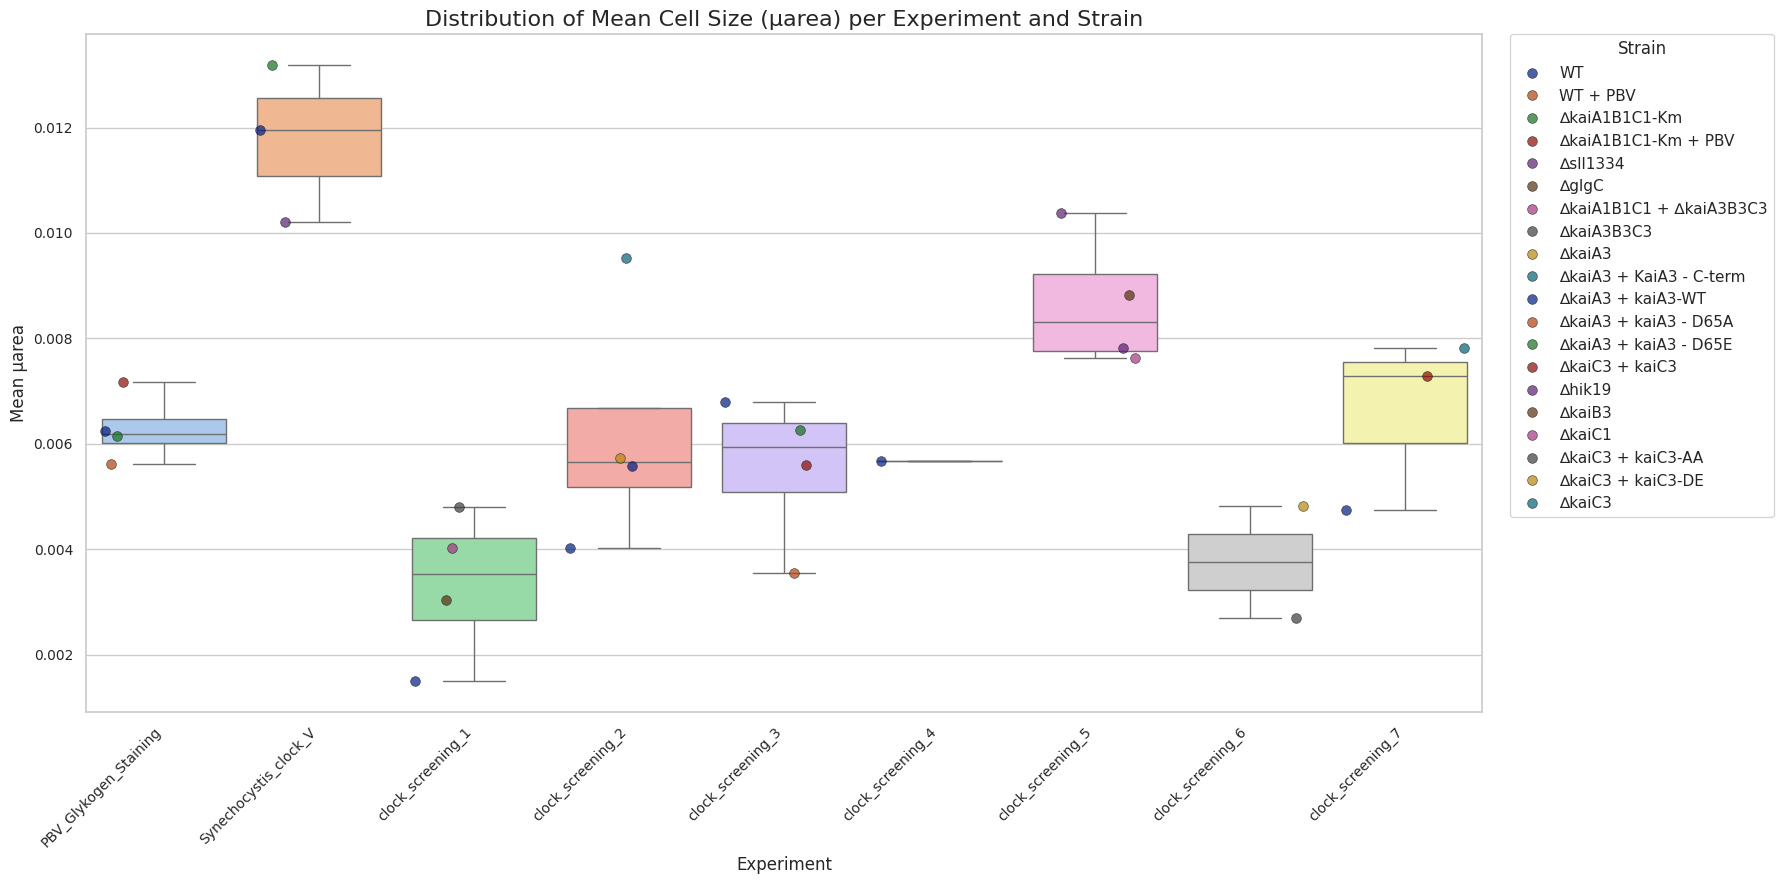

In [41]:
master_results_folder = Path('Master_results') 
id_all_folder = Path('ID_all') 

# Create necessary folders if they don't exist
master_results_folder.mkdir(parents=True, exist_ok=True)


# --- Section 1: Combine sig_mean_std.csv (from previous steps) ---
print("--- Section 1: Combining sig_mean_std.csv files ---")
all_data = []

for sub_folder in data_folder.glob("*"):
    if sub_folder.is_dir():
        data_file = sub_folder / "sig_mean_std.csv"
        try:
            sub_df = pd.read_csv(data_file, delimiter=';')
            if 'mean' in sub_df.columns and 'std' in sub_df.columns and 'time' in sub_df.columns and 'OmeroID' in sub_df.columns:
                all_data.append(sub_df)
            else:
                print(f'Error: Required columns (mean, std, time, OmeroID) not found in {data_file}')
        except FileNotFoundError:
            print(f'No sig_mean_std.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {data_file}: {e}')

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    master_results_path_sig = master_results_folder / 'combined_sig_mean_std.csv'
    combined_df.to_csv(master_results_path_sig, index=False, sep=';', decimal='.')
    print(f"Combined 'sig_mean_std.csv' data saved to: {master_results_path_sig}")
else:
    print("No 'sig_mean_std.csv' files found to combine.")

print('\nCombined_df (sig_mean_std) contains (first 5 rows):')
# Check if combined_df exists before printing
if 'combined_df' in locals():
    print(combined_df.head())
else:
    print("No combined_df was created from sig_mean_std files.")


# --- Section 2: Combine rates_df.csv into cellsize.csv ---
print("\n--- Section 2: Combining rates_df.csv files into cellsize.csv ---")
all_averaged_data = []

for sub_folder in data_folder.glob("*"):
    if sub_folder.is_dir():
        rates_file = sub_folder / "rates_df.csv"
        try:
            # Assuming rates_df.csv also uses ';' delimiter and '.' decimal
            rates_df = pd.read_csv(rates_file, delimiter=';', decimal='.')
            
            if 'µarea' in rates_df.columns and 'omero_ID' in rates_df.columns:
                mean_muarea = rates_df['µarea'].mean()
                mean_omero_id_from_file = rates_df['omero_ID'].mean()

                try:
                    omero_id_from_folder = int(sub_folder.name)
                except ValueError:
                    print(f"Warning: Could not convert sub-folder name '{sub_folder.name}' to an integer OmeroID. Skipping folder for cellsize.csv.")
                    continue

                all_averaged_data.append({
                    'OmeroID': omero_id_from_folder,
                    'Mean_µarea': mean_muarea,
                    'Mean_omero_ID_from_file': mean_omero_id_from_file
                })
            else:
                print(f'Error: Required columns (µarea, omero_ID) not found in {rates_file}')
        except FileNotFoundError:
            print(f'No rates_df.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {rates_file}: {e}')

if all_averaged_data:
    cellsize_df_raw = pd.DataFrame(all_averaged_data)
    cellsize_path = master_results_folder / 'cellsize.csv'
    cellsize_df_raw.to_csv(cellsize_path, index=False, sep=';', decimal='.')
    print(f"Combined averaged 'rates_df.csv' data saved to: {cellsize_path}")
else:
    print("No 'rates_df.csv' files found to process for cellsize.csv.")

print('\nCellsize_df (raw) contains (first 5 rows):')
if 'cellsize_df_raw' in locals():
    print(cellsize_df_raw.head())
else:
    print("No cellsize_df_raw was created.")


# --- Section 3: Merge with Experiments.csv and Sort ---
print("\n--- Section 3: Merging with Experiments.csv and Sorting ---")

experiments_file_path = id_all_folder / 'Experiments.csv'
cellsize_file_path = master_results_folder / 'cellsize.csv' # Path to the file created in Section 2

try:
    experiments_df = pd.read_csv(experiments_file_path, delimiter=';')
    experiments_df.columns = experiments_df.columns.str.strip()

    print(f"Loaded Experiments.csv from: {experiments_file_path}")
    print("Experiments.csv content (first 5 rows):")
    print(experiments_df.head())
    print("Experiments.csv columns:", experiments_df.columns.tolist())

except FileNotFoundError:
    print(f"Error: Experiments.csv not found at {experiments_file_path}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error reading Experiments.csv: {e}")
    exit()

try:
    cellsize_df = pd.read_csv(cellsize_file_path, delimiter=';', decimal='.')

    cellsize_df.columns = cellsize_df.columns.str.strip()

    print(f"\nLoaded cellsize.csv from: {cellsize_file_path}")
    print("cellsize.csv content (first 5 rows):")
    print(cellsize_df.head())
    print("cellsize.csv columns:", cellsize_df.columns.tolist()) 

except FileNotFoundError:
    print(f"Error: cellsize.csv not found at {cellsize_file_path}. Please run the previous script steps first.")
    exit()
except Exception as e:
    print(f"Error reading cellsize.csv: {e}")
    exit()

experiments_info_df = experiments_df[['Experiment', 'Strain', 'Dataset ID']].copy()

merged_df = pd.merge(
    cellsize_df,
    experiments_info_df,
    left_on='OmeroID',
    right_on='Dataset ID',
    how='left'
)

merged_df = merged_df.drop(columns=['Dataset ID'])

# Sort the DataFrame by 'OmeroID' before saving
merged_df.sort_values(by='OmeroID', inplace=True)
print("\nDataFrame sorted by 'OmeroID'.")


output_path = master_results_folder / 'cellsize_with_names.csv' # Save the merged data
merged_df.to_csv(output_path, index=False, sep=';', decimal='.')
print(f"\nUpdated cellsize.csv with Experiment and Strain saved to: {output_path}")

print("\nContent of 'cellsize_with_names.csv' (first 10 rows):")
print(merged_df.head(10))


# --- Section 4: Generate Table and Plot for Mean_µarea ---
print("\n--- Section 4: Generating Table and Plot for Mean_µarea ---")

# Load the cellsize_with_names.csv again to ensure we are working with the final data
# This is crucial, as the plotting part assumes the 'Experiment' and 'Strain' columns are present.
# We are now loading the *output* of the previous merge step.
data_for_analysis_path = master_results_folder / 'cellsize_with_names.csv'
try:
    df_analysis = pd.read_csv(data_for_analysis_path, delimiter=';', decimal='.')
    df_analysis.columns = df_analysis.columns.str.strip() # Strip columns again
    df_analysis['Strain'] = df_analysis['Strain'].str.strip() # Strip strain again

    # --- DIAGNOSTIC PRINT HERE ---
    print("\nColumns in df_analysis (after loading cellsize_with_names.csv for plotting):")
    print(df_analysis.columns.tolist())
    # --- END DIAGNOSTIC PRINT ---

    print(f"Successfully loaded '{data_for_analysis_path}' for analysis and plotting.")
except FileNotFoundError:
    print(f"Error: Final combined data file not found at {data_for_analysis_path}. Please check previous steps.")
    exit()
except Exception as e:
    print(f"Error reading final data file for analysis: {e}")
    exit()


# --- Part 1: Simple Table for Mean µarea per Experiment ---
print("\n--- Part 1: Mean µarea per Experiment (from final data) ---")


mean_per_experiment = df_analysis.groupby('Experiment')['Mean_µarea'].mean().reset_index()
mean_per_experiment = mean_per_experiment.rename(columns={'Mean_µarea': 'Average_µarea_for_Experiment'})
mean_per_experiment = mean_per_experiment.sort_values(by='Experiment')

print(mean_per_experiment.to_string(index=False))

mean_per_experiment_path = master_results_folder / 'mean_muarea_per_experiment.csv'
mean_per_experiment.to_csv(mean_per_experiment_path, index=False, sep=';', decimal='.')
print(f"\nTable saved to: {mean_per_experiment_path}")


# --- Part 2: Box/Swarm Plot Combination ---
print("\n--- Part 2: Generating Box/Swarm Plot (from final data) ---")

s.set_theme(style="whitegrid")

plt.figure(figsize=(18, 9))

# Sort data for better plotting order
df_analysis_sorted_for_plot = df_analysis.sort_values(by=['Experiment', 'Strain'])

s.boxplot(
    data=df_analysis_sorted_for_plot,
    x='Experiment',
    y='Mean_µarea',
    palette='pastel',
    showfliers=False
)

s.stripplot(
    data=df_analysis_sorted_for_plot,
    x='Experiment',
    y='Mean_µarea',
    hue='Strain',
    dodge=True,
    jitter=0.2,
    palette='dark',
    marker='o',
    size=7,
    edgecolor='gray',
    linewidth=0.5,
    alpha=0.7
)

plt.title('Distribution of Mean Cell Size (µarea) per Experiment and Strain', fontsize=16)
plt.xlabel('Experiment', fontsize=12)
plt.ylabel('Mean µarea', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Strain', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [42]:
# --- Section 1: Combining sig_mean_std.csv files ---
print("--- Section 1: Combining sig_mean_std.csv files ---")
all_data = []

for sub_folder in data_folder.glob("*"):
    if sub_folder.is_dir():
        data_file = sub_folder / "sig_mean_std.csv"
        try:
            sub_df = pd.read_csv(data_file, delimiter=';')
            if 'mean' in sub_df.columns and 'std' in sub_df.columns and 'time' in sub_df.columns and 'OmeroID' in sub_df.columns:
                all_data.append(sub_df)
            else:
                print(f'Error: Required columns (mean, std, time, OmeroID) not found in {data_file}')
        except FileNotFoundError:
            print(f'No sig_mean_std.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {data_file}: {e}')

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    master_results_path_sig = master_results_folder / 'combined_sig_mean_std.csv'
    combined_df.to_csv(master_results_path_sig, index=False, sep=';', decimal='.')
    print(f"Combined 'sig_mean_std.csv' data saved to: {master_results_path_sig}")
else:
    print("No 'sig_mean_std.csv' files found to combine.")

print('\nCombined_df (sig_mean_std) contains (first 5 rows):')
if 'combined_df' in locals():
    print(combined_df.head())
else:
    print("No combined_df was created from sig_mean_std files.")



--- Section 1: Combining sig_mean_std.csv files ---
No sig_mean_std.csv found in Experiments/.ipynb_checkpoints
Combined 'sig_mean_std.csv' data saved to: Master_results/combined_sig_mean_std.csv

Combined_df (sig_mean_std) contains (first 5 rows):
   time      mean       std  OmeroID
0     0 -0.183625  3.267116     4017
1     1 -0.075533  4.238835     4017
2     2  0.182812  2.701347     4017
3     3 -1.837832  2.942673     4017
4     4 -4.168196  2.530727     4017


In [43]:

# --- Section 2: Combine rates_df.csv into cellsize.csv (mean per OmeroID) ---
print("\n--- Section 2: Combining rates_df.csv files into cellsize.csv (mean per OmeroID) ---")
all_averaged_data = []

for sub_folder in data_folder.glob("*"):
    if sub_folder.is_dir():
        rates_file = sub_folder / "rates_df.csv"
        try:
            rates_df = pd.read_csv(rates_file, delimiter=';', decimal='.')
            
            if 'µarea' in rates_df.columns and 'omero_ID' in rates_df.columns:
                mean_muarea = rates_df['µarea'].mean()
                mean_omero_id_from_file = rates_df['omero_ID'].mean()

                try:
                    omero_id_from_folder = int(sub_folder.name)
                except ValueError:
                    print(f"Warning: Could not convert sub-folder name '{sub_folder.name}' to an integer OmeroID. Skipping folder for cellsize.csv.")
                    continue

                all_averaged_data.append({
                    'OmeroID': omero_id_from_folder,
                    'Mean_µarea': mean_muarea,
                    'Mean_omero_ID_from_file': mean_omero_id_from_file
                })
            else:
                print(f'Error: Required columns (µarea, omero_ID) not found in {rates_file}')
        except FileNotFoundError:
            print(f'No rates_df.csv found in {sub_folder}')
        except Exception as e:
            print(f'Error reading {rates_file}: {e}')

if all_averaged_data:
    cellsize_df_raw = pd.DataFrame(all_averaged_data)
    cellsize_path = master_results_folder / 'cellsize.csv'
    cellsize_df_raw.to_csv(cellsize_path, index=False, sep=';', decimal='.')
    print(f"Combined averaged 'rates_df.csv' data saved to: {cellsize_path}")
else:
    print("No 'rates_df.csv' files found to process for cellsize.csv.")

print('\nCellsize_df (raw) contains (first 5 rows):')
if 'cellsize_df_raw' in locals():
    print(cellsize_df_raw.head())
else:
    print("No cellsize_df_raw was created.")


--- Section 2: Combining rates_df.csv files into cellsize.csv (mean per OmeroID) ---
No rates_df.csv found in Experiments/.ipynb_checkpoints
Combined averaged 'rates_df.csv' data saved to: Master_results/cellsize.csv

Cellsize_df (raw) contains (first 5 rows):
   OmeroID  Mean_µarea  Mean_omero_ID_from_file
0     4017    0.005576                   4017.0
1     3948    0.001502                   3948.0
2     3709    0.011949                   3709.0
3     4160    0.002688                   4160.0
4     4207    0.004746                   4207.0


In [44]:
# --- Section 3: Merge with Experiments.csv and Sort (for cellsize_with_names.csv) ---
print("\n--- Section 3: Merging with Experiments.csv and Sorting ---")

# This is the path that needs to be correct for your 'Experiments.csv' file
experiments_file_path = id_all_folder / 'Experiments.csv'
cellsize_file_path = master_results_folder / 'cellsize.csv'

try:
    experiments_df = pd.read_csv(experiments_file_path, delimiter=';')
    experiments_df.columns = experiments_df.columns.str.strip()

    print(f"Loaded Experiments.csv from: {experiments_file_path}")
    print("Experiments.csv content (first 5 rows):")
    print(experiments_df.head())
    print("Experiments.csv columns:", experiments_df.columns.tolist())

except FileNotFoundError:
    print(f"Error: Experiments.csv not found at {experiments_file_path}. Please check the path and ensure the file exists.")
    exit() # Exit, as subsequent steps depend on this DataFrame
except Exception as e:
    print(f"Error reading Experiments.csv: {e}")
    exit() # Exit on other reading errors

try:
    cellsize_df = pd.read_csv(cellsize_file_path, delimiter=';', decimal='.')
    cellsize_df.columns = cellsize_df.columns.str.strip()

    print(f"\nLoaded cellsize.csv from: {cellsize_file_path}")
    print("cellsize.csv content (first 5 rows):")
    print(cellsize_df.head())
    print("cellsize.csv columns:", cellsize_df.columns.tolist())

except FileNotFoundError:
    print(f"Error: cellsize.csv not found at {cellsize_file_path}. Please run the previous script steps first to generate it.")
    exit()
except Exception as e:
    print(f"Error reading cellsize.csv: {e}")
    exit()

experiments_info_df = experiments_df[['Experiment', 'Strain', 'Dataset ID']].copy()

merged_df = pd.merge(
    cellsize_df,
    experiments_info_df,
    left_on='OmeroID',
    right_on='Dataset ID',
    how='left'
)

merged_df = merged_df.drop(columns=['Dataset ID'])
merged_df.sort_values(by='OmeroID', inplace=True)
print("\nDataFrame sorted by 'OmeroID'.")

output_path_cellsize_with_names = master_results_folder / 'cellsize_with_names.csv'
merged_df.to_csv(output_path_cellsize_with_names, index=False, sep=';', decimal='.')
print(f"\nUpdated cellsize.csv with Experiment and Strain saved to: {output_path_cellsize_with_names}")

print("\nContent of 'cellsize_with_names.csv' (first 10 rows):")
print(merged_df.head(10))




--- Section 3: Merging with Experiments.csv and Sorting ---
Loaded Experiments.csv from: ID_all/Experiments.csv
Experiments.csv content (first 5 rows):
              Experiment  Channel          Strain  Dataset ID
0  Synechocystis_clock_V        2              WT        3709
1  Synechocystis_clock_V        3  ∆kaiA1B1C1-Km         3707
2  Synechocystis_clock_V        4        ∆sll1334        3708
3  PBV_Glykogen_Staining        1              WT        3909
4  PBV_Glykogen_Staining        2        WT + PBV        3910
Experiments.csv columns: ['Experiment', 'Channel', 'Strain', 'Dataset ID']

Loaded cellsize.csv from: Master_results/cellsize.csv
cellsize.csv content (first 5 rows):
   OmeroID  Mean_µarea  Mean_omero_ID_from_file
0     4017    0.005576                   4017.0
1     3948    0.001502                   3948.0
2     3709    0.011949                   3709.0
3     4160    0.002688                   4160.0
4     4207    0.004746                   4207.0
cellsize.csv columns

In [45]:

# --- Section 4: Prepare Data for Real Boxplots (load all individual µarea values) ---
print("\n--- Section 4: Preparing Data for Real Boxplots ---")
all_individual_muarea_data = []


for sub_folder in data_folder.glob("*"):
    if sub_folder.is_dir():
        rates_file = sub_folder / "rates_df.csv"
        try:
            temp_df = pd.read_csv(rates_file, delimiter=';', decimal='.')
            temp_df.columns = temp_df.columns.str.strip() # Clean column names

            if 'µarea' in temp_df.columns and 'omero_ID' in temp_df.columns:
                # Get the OmeroID from the folder name
                try:
                    omero_id_from_folder = int(sub_folder.name)
                except ValueError:
                    print(f"Warning: Could not convert sub-folder name '{sub_folder.name}' to an integer OmeroID for plotting. Skipping.")
                    continue

                # Add OmeroID from folder to each row if it's not already there or consistent
                temp_df['OmeroID_from_Folder'] = omero_id_from_folder
                
                # Filter out unnecessary columns and append
                all_individual_muarea_data.append(temp_df[['OmeroID_from_Folder', 'µarea']].copy())
            else:
                print(f"Warning: 'µarea' or 'omero_ID' not found in {rates_file}. Skipping for plotting.")
        except FileNotFoundError:

            pass 
        except Exception as e:
            print(f"Error reading {rates_file} for plotting: {e}. Skipping.")

if not all_individual_muarea_data:
    print("No 'rates_df.csv' files with 'µarea' data found for detailed plotting.")
    # If no data, we should exit or skip plotting sections
else:
    full_muarea_df = pd.concat(all_individual_muarea_data, ignore_index=True)
    

    experiments_df_for_merge = experiments_df[['Experiment', 'Strain', 'Dataset ID']].rename(columns={'Dataset ID': 'OmeroID_from_Folder'}).copy()
    
    plot_df = pd.merge(
        full_muarea_df,
        experiments_df_for_merge,
        on='OmeroID_from_Folder',
        how='left'
    )
    
    # Clean up Strain names (again, in case of lingering whitespace from source)
    plot_df['Strain'] = plot_df['Strain'].str.strip()

    # Drop rows where merge failed (OmeroID not found in Experiments.csv)
    plot_df.dropna(subset=['Experiment', 'Strain'], inplace=True)

    print("\nDataFrame for plotting (first 5 rows):")
    print(plot_df.head())
    print("Columns in plot_df:", plot_df.columns.tolist())


--- Section 4: Preparing Data for Real Boxplots ---

DataFrame for plotting (first 5 rows):
   OmeroID_from_Folder     µarea         Experiment             Strain
0                 4017 -0.001399  clock_screening_2  ∆kaiA3 + kaiA3-WT
1                 4017  0.005195  clock_screening_2  ∆kaiA3 + kaiA3-WT
2                 4017  0.007806  clock_screening_2  ∆kaiA3 + kaiA3-WT
3                 4017  0.016576  clock_screening_2  ∆kaiA3 + kaiA3-WT
4                 4017  0.003810  clock_screening_2  ∆kaiA3 + kaiA3-WT
Columns in plot_df: ['OmeroID_from_Folder', 'µarea', 'Experiment', 'Strain']


In [46]:
# --- Part 5: Generate Table and Save as Figure ---
print("\n--- Part 5: Generating Table and Saving as Figure ---")

# Data for this table comes from 'cellsize_with_names.csv' (merged_df from Section 3)
mean_per_experiment = merged_df.groupby('Experiment')['Mean_µarea'].mean().reset_index()
mean_per_experiment = mean_per_experiment.rename(columns={'Mean_µarea': 'Average cell area [µm²]'})
mean_per_experiment = mean_per_experiment.sort_values(by='Experiment')

print("\nMean µarea per Experiment Table:")
print(mean_per_experiment.to_string(index=False))

mean_per_experiment_path_csv = master_results_folder / 'mean_muarea_per_experiment.csv'
mean_per_experiment.to_csv(mean_per_experiment_path_csv, index=False, sep=';', decimal='.')
print(f"Table data saved to: {mean_per_experiment_path_csv}")


# Save the table as an image
plt.figure(figsize=(10, max(6, len(mean_per_experiment) * 0.4))) # Min height 6, grows with rows
ax = plt.subplot(111)
ax.axis('off')

table = ax.table(cellText=mean_per_experiment.values,
                  colLabels=mean_per_experiment.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0,0,1,1]
                 )

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title('Average Cell Size (µarea) per Experiment', fontsize=14)

# Corrected path construction for table figure


table_figure_path = Path('Master_plots') / 'average_muarea_per_experiment_table.png'
plt.savefig(table_figure_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.close()
print(f"Table figure saved to: {table_figure_path}")


--- Part 5: Generating Table and Saving as Figure ---

Mean µarea per Experiment Table:
           Experiment  Average cell area [µm²]
PBV_Glykogen_Staining                 0.006293
Synechocystis_clock_V                 0.011782
    clock_screening_1                 0.003343
    clock_screening_2                 0.006213
    clock_screening_3                 0.005554
    clock_screening_4                 0.005671
    clock_screening_5                 0.008661
    clock_screening_6                 0.003758
    clock_screening_7                 0.006615
Table data saved to: Master_results/mean_muarea_per_experiment.csv
Table figure saved to: Master_plots/average_muarea_per_experiment_table.png



--- Part 6: Generating Boxplot (true cell size distribution) ---


/tmp/ipykernel_74817/3381903233.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
/tmp/ipykernel_74817/3381903233.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
/tmp/ipykernel_74817/3381903233.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
/tmp/ipykernel_74817/3381903233.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
/tmp/ipykernel_74817/3381903233.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
/tmp/ipykernel_74817/3381

Boxplot saved to: Master_plots/growth_rate_boxplot_per_experiment.png


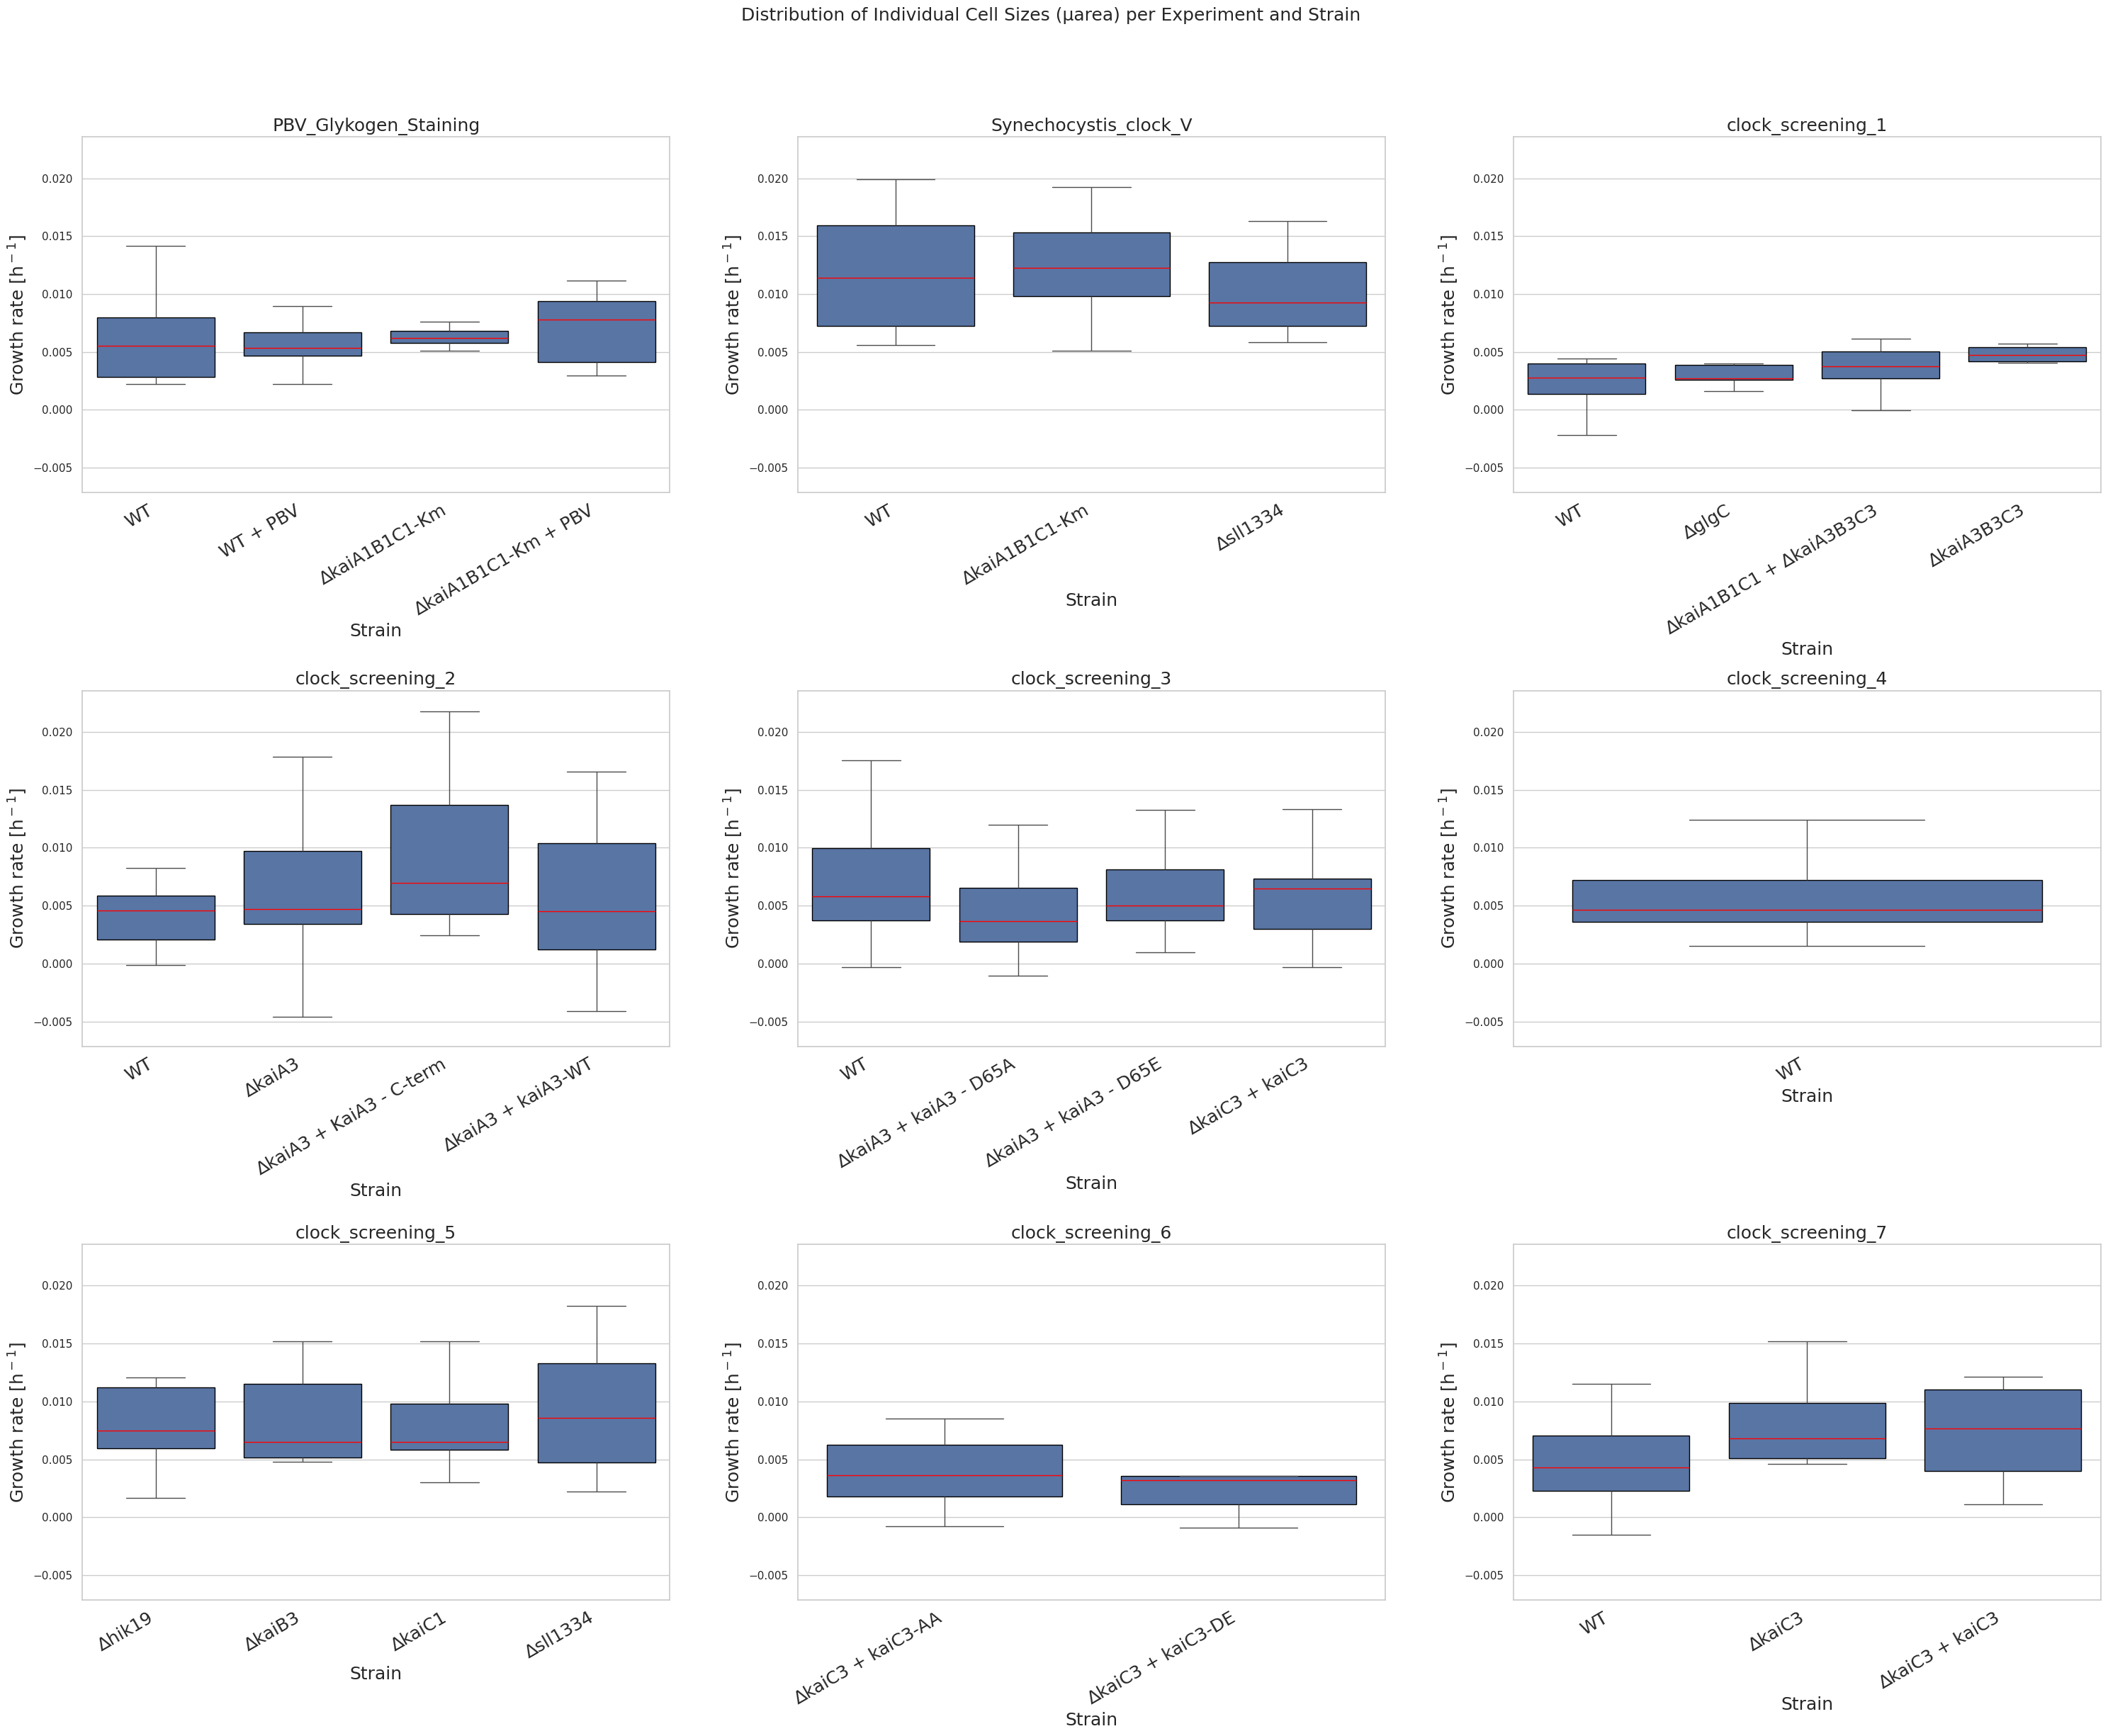

In [49]:
# --- Part 6: Generate Boxplot (true cell size distribution) ---
print("\n--- Part 6: Generating Boxplot (true cell size distribution) ---")

# 'plot_df' must have been loaded or created from a previous block (Section 4).
if 'plot_df' in locals() and not plot_df.empty:
    # IMPORTANT: Check if id_marker_color_assignment is defined.
    if 'id_marker_color_assignment' not in locals() and 'id_marker_color_assignment' not in globals():
        print("Error: 'id_marker_color_assignment' is not defined.")
        print("Please ensure the code for creating this dictionary was executed BEFORE this block.")
        print("Boxplot generation skipped.")
        exit() # Exit execution, as the dictionary is missing

    s.set_theme(style="whitegrid")

    unique_experiments = plot_df['Experiment'].unique()
    n_cols = 3 # Number of columns for subplots
    n_rows = (len(unique_experiments) + n_cols - 1) // n_cols # Calculate needed rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 8), squeeze=False) # Adjust figure size
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    # Overall Min/Max for consistent Y-axis across all plots
    min_muarea = plot_df['µarea'].min() + 0.01
    max_muarea = plot_df['µarea'].max() - 0.005 

    # Define the desired tick interval
    y_tick_interval = 0.005
    
    # Define a desired font size for tick labels
    tick_label_fontsize = 15 # You can adjust this value

    for i, experiment in enumerate(sorted(unique_experiments)):
        ax = axes[i]
        subset_exp_df = plot_df[plot_df['Experiment'] == experiment].copy()
        
        # Sort strains alphabetically for consistent order in plots
        subset_exp_df['Strain'] = pd.Categorical(subset_exp_df['Strain'], categories=sorted(subset_exp_df['Strain'].unique()), ordered=True)

        
        s.boxplot(
            data=subset_exp_df,
            x='Strain',
            y='µarea',
            # hue='Strain', # Optional: Color boxes by Strain (Seaborn Palette)
            ax=ax,
            showfliers=False, # Outliers are not shown here
            boxprops=dict(edgecolor='black'), # Black edges for boxes
            medianprops=dict(color='red') # Red median line
        )
        

        ax.set_title(experiment, fontsize=18)
        ax.set_xlabel('Strain', fontsize=18)
        ax.set_ylabel('Growth rate [h$^-$$^1$]', fontsize=18) # More precise label
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=18)
        ax.set_ylim(min_muarea, max_muarea) # Consistent Y-axis

        # Set major tick locator for Y-axis
        ax.yaxis.set_major_locator(ticker.MultipleLocator(y_tick_interval))
        
    plt.subplots_adjust(wspace=3, hspace=150) # Adjust these values as needed



    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.suptitle('Distribution of Individual Cell Sizes (µarea) per Experiment and Strain', y=1.02, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout for suptitle
    

    
    boxplot_figure_path = Path('Master_plots') / 'growth_rate_boxplot_per_experiment.png'
    plt.savefig(boxplot_figure_path, dpi=300, bbox_inches='tight')
    print(f"Boxplot saved to: {boxplot_figure_path}")
    
    plt.show()
    
else:
    print("Boxplot generation skipped: 'plot_df' is empty or not defined.")
    print("Please ensure previous sections (especially Section 4, which creates 'plot_df') were executed successfully and contain data.")

In [ ]:
print(f'All IDs were processed.')
print(f'All results have been saved in {master_results_folder}.')
print(f'All Plots have been saved in {master_plots_folder}.')